<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Forex/GBPEUR/GBPEUR_1D_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "GBPEUR=X"
data_resample = '1D'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open    High     Low   Close  Adj Close  Volume
Date                                                         
2009-01-01  1.0157  1.0551  1.0157  1.0503     1.0503       0
2009-01-02  1.0513  1.0591  1.0355  1.0429     1.0429       0
2009-01-05  1.0398  1.0827  1.0374  1.0787     1.0787       0
2009-01-06  1.0785  1.1076  1.0752  1.1038     1.1038       0
2009-01-07  1.1039  1.1139  1.0901  1.1065     1.1065       0
...            ...     ...     ...     ...        ...     ...
2018-12-26  1.1115  1.1150  1.1099  1.1113     1.1113       0
2018-12-27  1.1130  1.1134  1.1061  1.1132     1.1132       0
2018-12-28  1.1062  1.1094  1.1036  1.1059     1.1059       0
2018-12-31  1.1092  1.1199  1.1081  1.1090     1.1090       0
2019-01-01  1.1100  1.1124  1.0974  1.1079     1.1079       0

[2606 rows x 6 columns]

Open         High          Low        Close    Adj Close  Volume
count  2606.000000  2606.000000  2606.000000  2606.000000  2606.000000  2606.0
mean      1.196573     1.200819     1.192234     1.196673     1.196673     0.0
std       0.079849     0.080065     0.079444     0.079742     0.079742     0.0
min       1.015700     1.055100     1.015700     1.042900     1.042900     0.0
25%       1.137900     1.141525     1.133625     1.138000     1.138000     0.0
50%       1.175550     1.179600     1.171100     1.175600     1.175600     0.0
75%       1.239500     1.242975     1.235675     1.239475     1.239475     0.0
max       1.440600     1.441200     1.432800     1.440300     1.440300     0.0

7

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open    High     Low   Close  Adj Close  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  BBANDS_lowerband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
2009-03-12  1.0805  1.0852  1.0731  1.0794     1.0794   12          3         71             31             0               1               0                 1      3        1    11        3             0          11  1.085767  1.098185 -1.123065  1.082875  1.096584  1.098192     1.10245     1.10075  1.121355  1.101812  1.076501  1.102520  1.093089  1.101812  1.081200  1.117625                1.138838                 1.101812                1.064787                1.157351                 1.101812                1.046274                1.175864                 1.101812                1.027761                1.194377                 1.101812                1.009248  1.096584  1.083373  1.116743                1.133609                 1.096584                1.059558                1.152122                 1.096584                1.041045                1.170635                 1.096584                1.022532                1.189148                 1.096584                1.004019   
2009-03-13  1.0788  1.0895  1.0756  1.0827     1.0827   13          4         72             31             0               1               0                 1      3        1    11        4             1          11  1.085514  1.097664 -1.116070  1.080437  1.093498  1.095027     1.10245     1.10075  1.117494  1.097300  1.075982  1.094900  1.088842  1.097300  1.081050  1.115166                1.133739                 1.097300                1.060861                1.151959                 1.097300                1.042641                1.170179                 1.097300                1.024421                1.188398                 1.097300                1.006202  1.093498  1.082026  1.113875                1.129938                 1.093498                1.057059                1.148157                 1.093498                1.038839                1.166377                 1.093498                1.020620                1.184596                 1.093498                1.002400   
2009-03-16  1.0830  1.

Open         High          Low        Close    Adj Close          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000    2556.000000   2556.000000     2556.000000     2556.000000       2556.000000  2556.000000  2556.000000  2556.000000  2556.000000   2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000             2556.000000              2556.000000             2556.000000             2556.000000              2556.000000             2556.000000             2556.000000              2556.000000             2556.000000             2556.000000              2556.000000             2556.000000  2556.000000  2556.000000  2556.000000             2556.000000              2556.000000             2556.000000             2556.000000              2556.000000             2556.000000             2556.000000   
mean      1.198360     1.202475     1.194115     1.198434     1.198434    15.758607     1.999218   185.926448      30.467919      0.033255        0.966745        0.010955          0.989045     6.615806     2.537167    27.008998     1.999218      2.000000    27.008998     1.198595     1.198664     0.011037     1.198419     1.198423     1.198134     1.198350     1.198106     1.197878     1.198417     1.198424     1.198414     1.198419     1.198417     1.198426     1.198436                1.211142                 1.198417                1.185692                1.217505                 1.198417                1.179329                1.223868                 1.198417                1.172967                1.230230                 1.198417                1.166604     1.198423     1.198427     1.198434                1.211148                 1.198423                1.185698                1.217511                 1.198423                1.179335                1.223873   
std       0.079490     0.079878     0.078968     0.079431     0.079431     8.806999     1.414767   104.411507       0.781481      0.179337        0.179337        0.104110          0.104110     3.414756     1.108139    14.931190     1.414767      1.414214    14.931190     0.078923     0.078198     1.201046     0.079548     0.078964     0.079012     0.079054     0.078986     0.079602     0.079117     0.079513     0.079192     0.079167     0.079117     0.079386     0.078557                0.081025                 0.079117                0.077834                0.082201                 0.079117                0.077437                0.083516                 0.079117                0.077208                0.084965                 0.079117                0.077146     0.078964     0.079325     0.078637                0.080862                 0.078964                0.077693                0.082033                 0.078964                0.077303                0.083344   
min       1.058400     1.064800     1.054600     1.058300     1.058300     1.000000     0.0000

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
2009-03-12  0.057823  0.054198  0.048916  0.055236   0.055236   12          3         71             31             0               1               0                 1      3        1    11        3             0          11  0.029930  0.035939  0.111125  0.062016  0.067999  0.075110    0.087606    0.078746  0.172671  0.089856  0.049373  0.094674  0.069252  0.089856  0.057116  0.107565                0.136018                 0.089856                0.040500                0.165192                 0.089856                0.020364                0.196842                 0.089856                0.008635                0.226208                 0.089856                0.007577  0.067999  0.057849  0.109076                0.113775                 0.067999                0.019088                0.145137                 0.067999                0.005888                0.176854                 0.067999                0.004905                0.206062                 0.067999   
2009-03-13  0.053375  0.065622  0.055526  0.063874   0.063874   13          4         72             31             0               1               0                 1      3        1    11        4             1          11  0.029210  0.034363  0.113568  0.055537  0.059251  0.066043    0.087606    0.078746  0.162685  0.077264  0.048018  0.073691  0.057521  0.077264  0.056721  0.100307                0.122116                 0.077264                0.029806                0.150980                 0.077264                0.010689                0.182417                 0.077264                0.000000                0.211586                 0.077264                0.000000  0.059251  0.054260  0.100663                0.103849                 0.059251                0.012218                0.134793                 0.059251                0.000000                0.166179                 0.059251                0.000000                0.195087                 0.059251   
2009-03-16  0.064364  0.074655  0.069276  0.068325   0.068325   16          0         75

137920

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp9f9kyylz
  JVM stdout: /tmp/tmp9f9kyylz/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp9f9kyylz/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 3 days
H2O cluster name:           H2O_from_python_unknownUser_69gbq3
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_151932_mod...  0.591581  0.752864              0.484848  0.520997  0.271437
1  DeepLearning_grid_1_AutoML_20190822_151932_mod...  0.552206  0.694749              0.488636  0.500800  0.250800
2  DeepLearning_grid_1_AutoML_20190822_151932_mod...  0.552175  0.702683              0.477273  0.504346  0.254365
3              DeepLearning_1_AutoML_20190822_151932  0.549853  0.843795              0.452957  0.556242  0.309406
4  DeepLearning_grid_1_AutoML_20190822_151932_mod...  0.549426  0.847039              0.451246  0.548785  0.301165
5  DeepLearning_grid_1_AutoML_20190822_151932_mod...  0.545821  0.690762              0.462610  0.498808  0.248809
6  DeepLearning_grid_1_AutoML_20190822_151932_mod...  0.531219  0.692739              0.481305  0.499802  0.249802
7  DeepLearning_grid_1_AutoML_20190822_151932_mod...  0.512402  1.761833              0.500000  0.628282  0.394739
8  DeepLearning_grid_1_AutoML_20190822_151932_mod...  0.500000  0.693470              0.500000  0.500160  0.250160
9  DeepLearning_grid_1_AutoML_20190822_151932_mod...  0.491172  0.708610              0.492424  0.507597  0.257655

variable  relative_importance  scaled_importance  percentage
0          CDLMORNINGDOJISTAR             1.000000           1.000000    0.003601
1                   CDLONNECK             0.990679           0.990679    0.003568
2              CDLMORNINGSTAR             0.986980           0.986980    0.003554
3             CDLADVANCEBLOCK             0.930773           0.930773    0.003352
4                CDLTHRUSTING             0.929161           0.929161    0.003346
...                       ...                  ...                ...         ...
1016  BBANDS_upperband_20_0_2             0.211736           0.211736    0.000762
1017             MINMAX_min_8             0.211337           0.211337    0.000761
1018                  MA_24_2             0.211244           0.211244    0.000761
1019                  MA_30_1             0.210477           0.210477    0.000758
1020                CDLHARAMI             0.203543           0.203543    0.000733

[1021 rows x 4 columns]

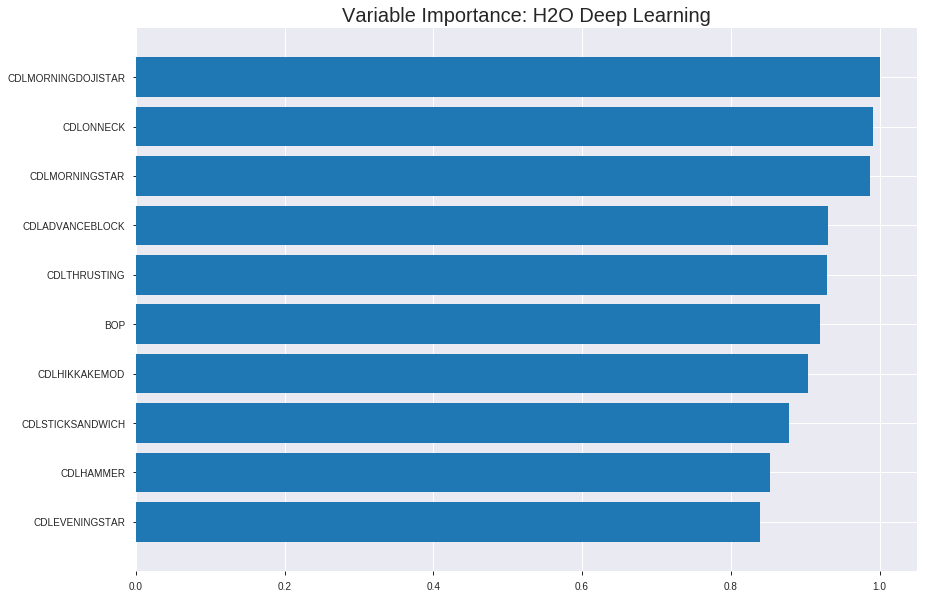

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_151932_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.22120404421621234
RMSE: 0.47032334007171317
LogLoss: 0.6378890082427048
Mean Per-Class Error: 0.3387775637632022
AUC: 0.7123168517079239
pr_auc: 0.7072206457274473
Gini: 0.42463370341584783
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17323343609650957: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      187  692   0.7873   (692.0/879.0)
1      41   868   0.0451   (41.0/909.0)
Total  228  1560  0.41     (733.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.173233     0.703119  339
max f2                       0.0838155    0.844095  372
max f0point5                 0.505318     0.671266  178
max accuracy                 0.448674     0.661074  206
max precision                0.988055     1         0
max recall                   0.0114443    1         396
max specificity              0.988055     1         0
max absolute_mcc             0.505318     0.32543   178
max min_per_class_accuracy   0.441587     0.657866  209
max mean_per_class_accuracy  0.448674     0.661222  206

Gains/Lift Table: Avg response rate: 50.84 %, avg score: 44.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.938007           1.85772   1.85772            0.944444         0.960451   0.944444                    0.960451            0.0187019       0.0187019                  85.7719   85.7719
    2        0.0201342                   0.902518           1.31133   1.58453            0.666667         0.919758   0.805556                    0.940104            0.0132013       0.0319032                  31.1331   58.4525
    3        0.0302013                   0.883673           1.85772   1.67559            0.944444         0.894922   0.851852                    0.925044            0.0187019       0.0506051                  85.7719   67.559
    4        0.0402685                   0.860423           1.42061   1.61184            0.722222         0.869945   0.819444                    0.911269            0.0143014       0.0649065                  42.0609   61.1845
    5        0.0503356                   0.838174           1.63916   1.61731            0.833333         0.849741   0.822222                    0.898963            0.0165017       0.0814081                  63.9164   61.7308
    6        0.100112                    0.749728           1.63548   1.62634            0.831461         0.787467   0.826816                    0.843526            0.0814081       0.162816                   63.548    62.6344
    7        0.150447                    0.699803           1.46432   1.57213            0.744444         0.725135   0.799257                    0.803916            0.0737074       0.236524                   46.432    57.2135
    8        0.200224                    0.648679           1.50287   1.55492            0.764045         0.671563   0.790503                    0.771012            0.0748075       0.311331                   50.2874   55.4916
    9        0.300336                    0.576117           1.20877   1.43953            0.614525         0.610485   0.731844                    0.717503            0.121012        0.432343                   20.8769   43.9534
    10       0.399888                    0.50373            1.24871   1.39203            0.634831         0.538905   0.707692                    0.673041            0.124312        0.556656                   24.8711   39.2028
    11       0.5                         0.441186           1.01097   1.31573            0.513966         0.474761   0.668904                    0.633341            0.10121         0.657866                   1.09704   31.5732
    12       0.600112                    0.374339           0.824161  1.23373            0.418994         0.404113   0.627213                    0.595101            0.0825083       0.740374                   -17.5839  23.3727
    13       0.699664                    0.312199           0.81774   1.17454            0.41573          0.342856   0.597122                    0.55921             0.0814081       0.821782                   -18.226   17.4538
    14       0.799776                    0.23657            0.769217  1.1238             0.391061         0.275846   0.571329                    0.52374             0.0770077       0.89879                    -23.0783  12.3802
    15       0.899888                    0.141361           0.64834   1.07091            0.329609         0.192702   0.544438                    0.486912            0.0649065       0.963696                   -35.166   7.09068
    16       1                           0.000348099        0.362631  1                  0.184358         0.0834368  0.508389                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2832474289090814
RMSE: 0.5322099481493008
LogLoss: 0.804731722869515
Mean Per-Class Error: 0.44632511556240373
AUC: 0.5572110939907551
pr_auc: 0.4901372782206298
Gini: 0.11442218798151016
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24211120203898653: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      47   228  0.8291   (228.0/275.0)
1      15   221  0.0636   (15.0/236.0)
Total  62   449  0.4755   (243.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.242111     0.645255  348
max f2                       0.0449256    0.813232  395
max f0point5                 0.242111     0.543799  348
max accuracy                 0.718967     0.561644  109
max precision                0.972136     0.571429  4
max recall                   0.0449256    1         395
max specificity              0.998453     0.996364  0
max absolute_mcc             0.242111     0.16391   348
max min_per_class_accuracy   0.559826     0.523636  199
max mean_per_class_accuracy  0.242111     0.553675  348

Gains/Lift Table: Avg response rate: 46.18 %, avg score: 55.17 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.97232            1.08263   1.08263            0.5              0.981393  0.5                         0.981393            0.0127119       0.0127119                  8.26271   8.26271
    2        0.0215264                   0.940886           0.866102  0.984206           0.4              0.953278  0.454545                    0.968613            0.00847458      0.0211864                  -13.3898  -1.57935
    3        0.0313112                   0.922041           0.433051  0.81197            0.2              0.92741   0.375                       0.955737            0.00423729      0.0254237                  -56.6949  -18.803
    4        0.0410959                   0.909947           0.433051  0.721751           0.2              0.914294  0.333333                    0.94587             0.00423729      0.029661                   -56.6949  -27.8249
    5        0.0508806                   0.896704           0.866102  0.749511           0.4              0.903558  0.346154                    0.937733            0.00847458      0.0381356                  -13.3898  -25.0489
    6        0.101761                    0.845485           1.24919   0.999348           0.576923         0.868704  0.461538                    0.903218            0.0635593       0.101695                   24.9185   -0.065189
    7        0.150685                    0.814105           1.38576   1.12481            0.64             0.828656  0.519481                    0.87901             0.0677966       0.169492                   38.5763   12.4807
    8        0.201566                    0.773023           1.16591   1.13518            0.538462         0.790616  0.524272                    0.856697            0.059322        0.228814                   16.5906   13.5182
    9        0.30137                     0.687349           1.18877   1.15293            0.54902          0.732717  0.532468                    0.815638            0.118644        0.347458                   18.8767   15.2928
    10       0.401174                    0.615581           0.976487  1.10903            0.45098          0.652141  0.512195                    0.774964            0.0974576       0.444915                   -2.35128  10.9033
    11       0.500978                    0.559645           0.849119  1.05725            0.392157         0.58574   0.488281                    0.737267            0.0847458       0.529661                   -15.0881  5.7253
    12       0.600783                    0.513942           1.0614    1.05794            0.490196         0.534284  0.488599                    0.703547            0.105932        0.635593                   6.13991   5.79418
    13       0.700587                    0.439311           1.0614    1.05843            0.490196         0.480009  0.488827                    0.671702            0.105932        0.741525                   6.13991   5.84343
    14       0.800391                    0.340388           1.14631   1.06939            0.529412         0.391288  0.493888                    0.636736            0.114407        0.855932                   14.6311   6.93921
    15       0.900196                    0.21904            0.891575  1.04968            0.411765         0.276599  0.484783                    0.596808            0.0889831       0.944915                   -10.8425  4.96776
    16       1                           5.82509e-07        0.551928  1                  0.254902         0.144941  0.46184                     0.551709     


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 15:22:56  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 15:22:58  3 min 19.455 sec  386 obs/sec       0.31264   1             559        0.595101         3.03815             -0.416982      0.567877        0.448693           0.688449         0.465884                         0.629202           2.57612               -0.592861        0.514861          0.419864             0.721751           0.516634
    2019-08-22 15:23:09  3 min 30.306 sec  485 obs/sec       3.07606   10            5500       0.63162          2.96772             -0.596224      0.622809        0.613437           1.52989          0.491611                         0.626095           2.29133               -0.577168        0.534877          0.486831             0.721751           0.51272
    2019-08-22 15:23:19  3 min 40.742 sec  511 obs/sec       5.90716   19            10562      0.546316         1.29283             -0.19418       0.678673        0.585302           1.74844          0.389262                         0.64781            2.11925               -0.688465        0.556471          0.498185             1.08263            0.53816
    2019-08-22 15:23:30  3 min 52.221 sec  526 obs/sec       9.05984   29            16199      0.528423         1.36342             -0.11724       0.670219        0.533478           1.42061          0.392617                         0.604281           1.63379               -0.469181        0.57396           0.476794             0.721751           0.497065
    2019-08-22 15:23:44  4 min  6.015 sec  528 obs/sec       12.8826   41            23034      0.546753         1.38606             -0.196093      0.639191        0.51959            1.52989          0.39038                          0.592247           1.62781               -0.411245        0.533683          0.451475             1.08263            0.477495
    2019-08-22 15:23:54  4 min 15.620 sec  537 obs/sec       15.6969   50            28066      0.528436         0.974366            -0.117294      0.670236        0.672028           1.74844          0.456376                         0.55235            0.982938              -0.22751         0.552119          0.499181             0.360876           0.516634
    2019-08-22 15:24:05  4 min 26.293 sec  543 obs/sec       18.8199   60            33650      0.479864         0.692643            0.0786624      0.695404        0.657997           1.63916          0.368009                         0.535564           0.84016               -0.154038        0.574961          0.491264             0.721751           0.491194
    2019-08-22 15:24:16  4 min 37.252 sec  546 obs/sec       21.9603   70            39265      0.511025         0.79968             -0.044882      0.675367        0.685995           1.85772          0.458613                         0.537015           0.817571              -0.1603          0.531941          0.481559             1.08263            0.489237
    2019-08-22 15:24:26  

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
CDLMORNINGDOJISTAR       1.0                    1.0                  0.0036011271014382115
CDLONNECK                0.9906788468360901     0.9906788468360901   0.0035675604441629994
CDLMORNINGSTAR           0.9869799613952637     0.9869799613952637   0.0035542402875569238
CDLADVANCEBLOCK          0.9307726621627808     0.9307726621627808   0.0033518306589921825
CDLTHRUSTING             0.9291605353355408     0.9291605353355408   0.003346025185383653
---                      ---                    ---                  ---
BBANDS_upperband_20_0_2  0.21173632144927979    0.21173632144927979  0.0007624894055298344
MINMAX_min_8             0.21133670210838318    0.21133670210838318  0.0007610503254910728
MA_24_2                  0.2112438678741455     0.2112438678741455   0.0007607160176142182
MA_30_1                  0.21047663688659668    0.21047663688659668  0.0007579531213118929
CDLHARAMI                0.2035432904958725     0.2035432904958725   0.0007329852597205973


See the whole table with table.as_data_frame()


('accuracy', 0.61328125)

('F1', 0.6595744680851063)

('auc', 0.5915811339198437)

('logloss', 0.7528636747915678)

('mean_per_class_error', 0.38795210166177907)

('rmse', 0.5209966079262015)

('mse', 0.27143746547060815)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


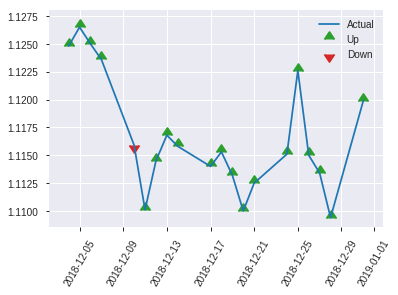


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.27143746547060815
RMSE: 0.5209966079262015
LogLoss: 0.7528636747915678
Mean Per-Class Error: 0.38795210166177907
AUC: 0.5915811339198437
pr_auc: 0.5426328619820221
Gini: 0.18316226783968736
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20815123031129698: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    128  0.9697   (128.0/132.0)
1      0    124  0        (0.0/124.0)
Total  4    252  0.5      (128.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.208151     0.659574  251
max f2                       0.208151     0.828877  251
max f0point5                 0.666419     0.599662  116
max accuracy                 0.675562     0.613281  112
max precision                0.931946     0.666667  2
max recall                   0.208151     1         251
max specificity              0.970647     0.992424  0
max absolute_mcc             0.666419     0.224818  116
max min_per_class_accuracy   0.651454     0.604839  126
max mean_per_class_accuracy  0.666419     0.612048  116

Gains/Lift Table: Avg response rate: 48.44 %, avg score: 62.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.92786            1.37634   1.37634            0.666667         0.946424  0.666667                    0.946424            0.016129        0.016129                   37.6344   37.6344
    2        0.0234375                   0.90593            0.688172  1.03226            0.333333         0.915003  0.5                         0.930714            0.00806452      0.0241935                  -31.1828  3.22581
    3        0.03125                     0.883111           1.03226   1.03226            0.5              0.884105  0.5                         0.919061            0.00806452      0.0322581                  3.22581   3.22581
    4        0.0429688                   0.862951           0.688172  0.938416           0.333333         0.871446  0.454545                    0.906075            0.00806452      0.0403226                  -31.1828  -6.15836
    5        0.0507812                   0.83788            2.06452   1.11166            1                0.853024  0.538462                    0.897913            0.016129        0.0564516                  106.452   11.1663
    6        0.101562                    0.796997           1.11166   1.11166            0.538462         0.812834  0.538462                    0.855374            0.0564516       0.112903                   11.1663   11.1663
    7        0.152344                    0.760993           0.952854  1.05873            0.461538         0.779608  0.512821                    0.830119            0.0483871       0.16129                    -4.71464  5.87262
    8        0.203125                    0.749448           1.42928   1.15136            0.692308         0.755098  0.557692                    0.811363            0.0725806       0.233871                   42.928    15.1365
    9        0.300781                    0.718184           1.15613   1.15291            0.56             0.734544  0.558442                    0.786422            0.112903        0.346774                   15.6129   15.2912
    10       0.402344                    0.684567           1.50868   1.24272            0.730769         0.69906   0.601942                    0.764369            0.153226        0.5                        50.8685   24.2718
    11       0.5                         0.650301           1.07355   1.20968            0.52             0.668119  0.585938                    0.745571            0.104839        0.604839                   7.35484   20.9677
    12       0.601562                    0.607224           0.794045  1.13951            0.384615         0.632853  0.551948                    0.72654             0.0806452       0.685484                   -20.5955  13.9506
    13       0.699219                    0.5492             0.743226  1.08416            0.36             0.584468  0.52514                     0.706698            0.0725806       0.758065                   -25.6774  8.41593
    14       0.800781                    0.490835           0.794045  1.04736            0.384615         0.520495  0.507317                    0.683082            0.0806452       0.83871                    -20.5955  4.73643
    15       0.898438                    0.388307           0.743226  1.01431            0.36             0.448491  0.491304                    0.657583            0.0725806       0.91129                    -25.6774  1.43058
    16       1                           0.0871703          0.873449  1                  0.423077         0.299118  0.484375                    0.621176        

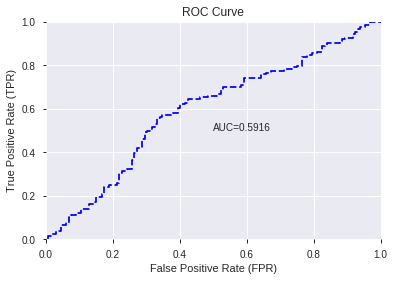

This function is available for GLM models only


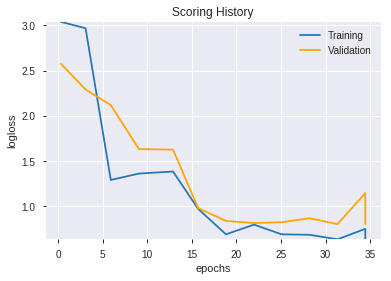

--2019-08-22 15:46:21--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.20.99
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.20.99|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  13.0MB/s    in 29s     

2019-08-22 15:46:50 (12.3 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: Unkno

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_151932_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_151932_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_a064',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_154704_model_9  0.580645  0.682943              0.477761  0.494973  0.244999
1  DeepLearning_grid_1_AutoML_20190822_154704_model_8  0.579607  0.691774              0.470186  0.497242  0.247249
2  DeepLearning_grid_1_AutoML_20190822_154704_model_2  0.570381  0.783197              0.489125  0.525225  0.275861
3  DeepLearning_grid_1_AutoML_20190822_154704_model_4  0.568304  0.898678              0.500000  0.539896  0.291488
4  DeepLearning_grid_1_AutoML_20190822_154704_model_3  0.560056  0.813829              0.488881  0.527304  0.278049
5  DeepLearning_grid_1_AutoML_20190822_154704_model_5  0.553763  0.696529              0.477273  0.501604  0.251606
6  DeepLearning_grid_1_AutoML_20190822_154704_model_6  0.552603  0.695998              0.481305  0.500803  0.250803
7               DeepLearning_1_AutoML_20190822_154704  0.542827  0.788151              0.500000  0.522462  0.272966
8  DeepLearning_grid_1_AutoML_20190822_154704_model_1  0.537085  0.923768              0.477761  0.553788  0.306682
9  DeepLearning_grid_1_AutoML_20190822_154704_model_7  0.524377  0.801136              0.492424  0.537703  0.289125

variable  relative_importance  scaled_importance  percentage
0                   BOP             1.000000           1.000000    0.039871
1            MINUS_DI_8             0.796808           0.796808    0.031770
2                   SUB             0.718455           0.718455    0.028646
3     CDLGRAVESTONEDOJI             0.678847           0.678847    0.027067
4                   DIV             0.673941           0.673941    0.026871
5        CDLRICKSHAWMAN             0.665684           0.665684    0.026542
6          STOCHF_fastk             0.650517           0.650517    0.025937
7      CDLDRAGONFLYDOJI             0.586858           0.586858    0.023399
8     CDLLONGLEGGEDDOJI             0.562181           0.562181    0.022415
9               CDLDOJI             0.557596           0.557596    0.022232
10            CDLTAKURI             0.514670           0.514670    0.020521
11   CDLEVENINGDOJISTAR             0.512778           0.512778    0.020445
12     CDLSTICKSANDWICH             0.511338           0.511338    0.020388
13        CDLHIKKAKEMOD             0.499279           0.499279    0.019907
14      CDLADVANCEBLOCK             0.498762           0.498762    0.019886
15         HT_TRENDMODE             0.498269           0.498269    0.019867
16            CORREL_14             0.494056           0.494056    0.019699
17            CDLONNECK             0.491854           0.491854    0.019611
18    CDLINVERTEDHAMMER             0.490002           0.490002    0.019537
19  CDLXSIDEGAP3METHODS             0.484329           0.484329    0.019311
20               SAREXT             0.478004           0.478004    0.019059
21   CDLMORNINGDOJISTAR             0.475651           0.475651    0.018965
22         CDLBREAKAWAY             0.469937           0.469937    0.018737
23       CDLEVENINGSTAR             0.468117           0.468117    0.018664
24         weekday_name             0.467893           0.467893    0.018656
25       CDLMORNINGSTAR             0.466959           0.466959    0.018618
26                  day             0.465339           0.465339    0.018554
27            dayofweek             0.464994           0.464994    0.018540
28     CDLABANDONEDBABY             0.462875           0.462875    0.018455
29   CDLSEPARATINGLINES             0.462433           0.462433    0.018438
30        days_in_month             0.462189           0.462189    0.018428
31         CDLTHRUSTING             0.459123           0.459123    0.018306
32              weekday             0.445876           0.445876    0.017778
33            CORREL_12             0.443615           0.443615    0.017688
34            CORREL_20             0.442967           0.442967    0.017662
35      CDLSHOOTINGSTAR             0.437747           0.437747    0.017454
36            CORREL_24             0.432880           0.432880    0.017260
37     is_quarter_start             0.430429           0.430429    0.017162
38       CDLMATCHINGLOW             0.429217           0.429217    0.017113
39       is_month_start             0.425978           0.425978    0.016984
40         is_month_end             0.422864           0.422864    0.016860
41            CORREL_30             0.422020           0.422020    0.016827
42       is_quarter_end             0.421241           0.421241    0.016795
43     CDLCOUNTERATTACK             0.412368           0.412368    0.016442
44          aroondown_8             0.408390           0.408390    0.016283
45             CORREL_8             0.407219           0.407219    0.016236
46        CDLHANGINGMAN             0.404537           0.404537    0.016129
47            CDLHAMMER             0.404065           0.404065    0.016111
48       CDLHARAMICROSS             0.399877           0.399877    0.015944
49           CDL3INSIDE             0.399609           0.399609    0.015933

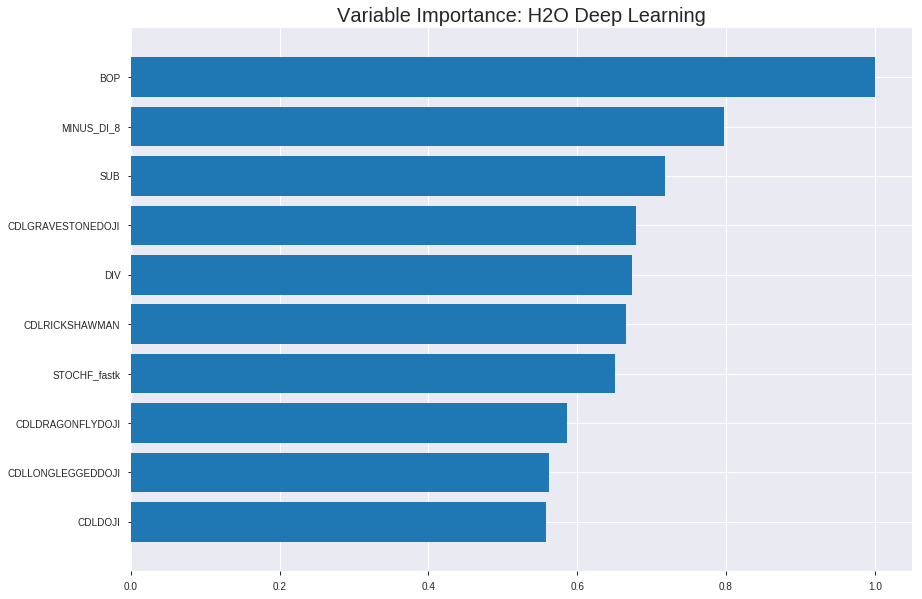

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_154704_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.23120314902636277
RMSE: 0.48083588575143055
LogLoss: 0.6544745414829419
Mean Per-Class Error: 0.36781596248362036
AUC: 0.6717003896066512
pr_auc: 0.6636988535967675
Gini: 0.3434007792133025
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43124782975217973: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      258  621   0.7065   (621.0/879.0)
1      72   837   0.0792   (72.0/909.0)
Total  330  1458  0.3876   (693.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.431248     0.707224  273
max f2                       0.310641     0.840749  381
max f0point5                 0.484095     0.637716  219
max accuracy                 0.484095     0.635347  219
max precision                0.785886     1         0
max recall                   0.285016     1         392
max specificity              0.785886     1         0
max absolute_mcc             0.484095     0.28595   219
max min_per_class_accuracy   0.499258     0.602958  187
max mean_per_class_accuracy  0.484095     0.632184  219

Gains/Lift Table: Avg response rate: 50.84 %, avg score: 48.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.700463           1.74844   1.74844            0.888889         0.730043  0.888889                    0.730043            0.0176018       0.0176018                  74.8442   74.8442
    2        0.0201342                   0.6835             1.63916   1.6938             0.833333         0.690058  0.861111                    0.71005             0.0165017       0.0341034                  63.9164   69.3803
    3        0.0302013                   0.666462           1.74844   1.71202            0.888889         0.67395   0.87037                     0.698017            0.0176018       0.0517052                  74.8442   71.2016
    4        0.0402685                   0.655026           1.52989   1.66648            0.777778         0.66223   0.847222                    0.68907             0.0154015       0.0671067                  52.9886   66.6483
    5        0.0503356                   0.636856           1.52989   1.63916            0.777778         0.64341   0.833333                    0.679938            0.0154015       0.0825083                  52.9886   63.9164
    6        0.100112                    0.579524           1.41447   1.52744            0.719101         0.602427  0.776536                    0.641399            0.070407        0.152915                   41.447    52.7444
    7        0.150447                    0.548505           1.28948   1.44783            0.655556         0.561456  0.736059                    0.614652            0.0649065       0.217822                   28.9476   44.7827
    8        0.200224                    0.52605            1.25976   1.40107            0.640449         0.537055  0.712291                    0.595361            0.0627063       0.280528                   25.9762   40.1073
    9        0.300336                    0.50381            1.04394   1.28203            0.530726         0.511287  0.651769                    0.567337            0.10451         0.385039                   4.39368   28.2028
    10       0.399888                    0.501001           1.14926   1.24897            0.58427          0.502042  0.634965                    0.551082            0.114411        0.49945                    14.9256   24.8974
    11       0.5                         0.499274           1.0769    1.21452            0.547486         0.500169  0.61745                     0.540888            0.107811        0.607261                   7.69032   21.4521
    12       0.600112                    0.49576            1.04394   1.18606            0.530726         0.497802  0.602982                    0.5337              0.10451         0.711771                   4.39368   18.6064
    13       0.699664                    0.480515           1.16031   1.1824             0.589888         0.490701  0.601119                    0.527582            0.115512        0.827283                   16.0307   18.2399
    14       0.799776                    0.443211           0.791194  1.13343            0.402235         0.465281  0.576224                    0.519783            0.0792079       0.906491                   -20.8806  13.343
    15       0.899888                    0.371184           0.571418  1.07091            0.290503         0.405802  0.544438                    0.507103            0.0572057       0.963696                   -42.8582  7.09068
    16       1                           0.236173           0.362631  1                  0.184358         0.335564  0.508389                    0.48993           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24342465065898508
RMSE: 0.49338083734472815
LogLoss: 0.6794345535213291
Mean Per-Class Error: 0.4237673343605547
AUC: 0.5690986132511556
pr_auc: 0.5039551382176873
Gini: 0.13819722650231125
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3481467570497696: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      38   237  0.8618   (237.0/275.0)
1      11   225  0.0466   (11.0/236.0)
Total  49   462  0.4853   (248.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.348147     0.644699  352
max f2                       0.30129      0.81548   391
max f0point5                 0.479595     0.551567  221
max accuracy                 0.479595     0.565558  221
max precision                0.650309     1         0
max recall                   0.30129      1         391
max specificity              0.650309     1         0
max absolute_mcc             0.479595     0.157798  221
max min_per_class_accuracy   0.497033     0.529661  163
max mean_per_class_accuracy  0.479595     0.576233  221

Gains/Lift Table: Avg response rate: 46.18 %, avg score: 46.90 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.600664           1.08263   1.08263            0.5              0.62263   0.5                         0.62263             0.0127119       0.0127119                  8.26271   8.26271
    2        0.0215264                   0.592457           0.433051  0.787365           0.2              0.595564  0.363636                    0.610328            0.00423729      0.0169492                  -56.6949  -21.2635
    3        0.0313112                   0.579882           0.866102  0.81197            0.4              0.58597   0.375                       0.602716            0.00847458      0.0254237                  -13.3898  -18.803
    4        0.0410959                   0.573523           1.7322    1.03107            0.8              0.576725  0.47619                     0.596528            0.0169492       0.0423729                  73.2203   3.10734
    5        0.0508806                   0.561967           1.29915   1.08263            0.6              0.566391  0.5                         0.590732            0.0127119       0.0550847                  29.9153   8.26271
    6        0.101761                    0.533038           1.16591   1.12427            0.538462         0.548376  0.519231                    0.569554            0.059322        0.114407                   16.5906   12.4267
    7        0.150685                    0.509282           1.12593   1.12481            0.52             0.517716  0.519481                    0.552723            0.0550847       0.169492                   12.5932   12.4807
    8        0.201566                    0.502879           1.16591   1.13518            0.538462         0.505098  0.524272                    0.540701            0.059322        0.228814                   16.5906   13.5182
    9        0.30137                     0.500647           1.10386   1.12481            0.509804         0.501704  0.519481                    0.527787            0.110169        0.338983                   10.3855   12.4807
    10       0.401174                    0.499186           1.0614    1.10903            0.490196         0.499884  0.512195                    0.520845            0.105932        0.444915                   6.13991   10.9033
    11       0.500978                    0.496826           0.849119  1.05725            0.392157         0.498133  0.488281                    0.51632             0.0847458       0.529661                   -15.0881  5.7253
    12       0.600783                    0.487591           1.14631   1.07205            0.529412         0.492998  0.495114                    0.512446            0.114407        0.644068                   14.6311   7.20477
    13       0.700587                    0.457667           1.23122   1.09472            0.568627         0.474641  0.505587                    0.50706             0.122881        0.766949                   23.1223   9.47235
    14       0.800391                    0.416782           0.849119  1.0641             0.392157         0.441381  0.491443                    0.498871            0.0847458       0.851695                   -15.0881  6.4098
    15       0.900196                    0.350078           0.934031  1.04968            0.431373         0.379793  0.484783                    0.485668            0.0932203       0.944915                   -6.59688  4.96776
    16       1                           0.152532           0.551928  1                  0.254902         0.318267  0.46184                     0.468961          


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 15:53:55  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 15:53:58  2 min 23.607 sec  430 obs/sec       0.558166  1             998        0.597128         1.06303             -0.426649      0.611151        0.616387           1.52989          0.445749                         0.614708           1.09708               -0.520322        0.572319          0.516256             1.4435             0.479452
    2019-08-22 15:54:08  2 min 34.111 sec  769 obs/sec       5.09116   9             9103       0.48615          0.665151            0.0543663      0.649007        0.63986            1.63916          0.409955                         0.494559           0.681466              0.0159122        0.560763          0.486908             0.721751           0.495108
    2019-08-22 15:54:19  2 min 44.739 sec  905 obs/sec       10.8652   19            19427      0.482304         0.656901            0.0692682      0.667286        0.65971            1.74844          0.416667                         0.49822            0.68911               0.00128966       0.559946          0.493777             0.721751           0.499022
    2019-08-22 15:54:29  2 min 54.861 sec  1002 obs/sec      17.1499   30            30664      0.480836         0.654475            0.074927       0.6717          0.663699           1.74844          0.387584                         0.493381           0.679435              0.0205965        0.569099          0.503955             1.08263            0.485323
    2019-08-22 15:54:40  3 min  5.379 sec  1095 obs/sec      24.6035   43            43991      0.477094         0.646405            0.0892701      0.674798        0.667016           1.74844          0.39821                          0.494241           0.681516              0.0171804        0.579245          0.518249             1.4435             0.516634
    2019-08-22 15:54:50  3 min 15.515 sec  1181 obs/sec      32.5872   57            58266      0.473236         0.638408            0.103937       0.683725        0.674218           1.85772          0.38311                          0.495177           0.683561              0.013451         0.580516          0.512081             1.4435             0.499022
    2019-08-22 15:55:00  3 min 25.964 sec  1251 obs/sec      41.1174   72            73518      0.46877          0.628735            0.120772       0.688295        0.682038           1.85772          0.39094                          0.496098           0.686408              0.00977955       0.579222          0.51153              0.721751           0.514677
    2019-08-22 15:55:01  3 min 26.976 sec  1250 obs/sec      41.1174   72            73518      0.480836         0.654475            0.074927       0.6717          0.663699           1.74844          0.387584                         0.493381           0.679435              0.0205965        0.569099          0.503955             1.08263            0.485323

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
BOP                1.0                    1.0                  0.039871396024642236
MINUS_DI_8         0.7968083620071411     0.7968083620071411   0.03176986175733322
SUB                0.7184550166130066     0.7184550166130066   0.0286458044932681
CDLGRAVESTONEDOJI  0.6788466572761536     0.6788466572761536   0.027066563912262098
DIV                0.6739411950111389     0.6739411950111389   0.026870976283609762
---                ---                    ---                  ---
CORREL_8           0.40721869468688965    0.40721869468688965  0.016236377844498853
CDLHANGINGMAN      0.4045366048812866     0.4045366048812866   0.016129439179685998
CDLHAMMER          0.4040648639202118     0.4040648639202118   0.01611063020900594
CDLHARAMICROSS     0.3998766839504242     0.3998766839504242   0.015943641626808062
CDL3INSIDE         0.39960920810699463    0.39960920810699463  0.015932976991527657


See the whole table with table.as_data_frame()


('accuracy', 0.578125)

('F1', 0.6594594594594595)

('auc', 0.5806451612903225)

('logloss', 0.6829433315816763)

('mean_per_class_error', 0.4193548387096775)

('rmse', 0.49497325567473804)

('mse', 0.2449985238332496)

deeplearning prediction progress: |███████████████████████████████████████| 100%


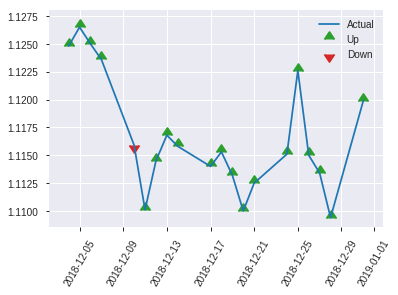


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2449985238332496
RMSE: 0.49497325567473804
LogLoss: 0.6829433315816763
Mean Per-Class Error: 0.4193548387096775
AUC: 0.5806451612903225
pr_auc: 0.5579730947751567
Gini: 0.16129032258064502
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3427725205300387: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    124  0.9394   (124.0/132.0)
1      2    122  0.0161   (2.0/124.0)
Total  10   246  0.4922   (126.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.342773     0.659459  245
max f2                       0.306171     0.82777   252
max f0point5                 0.499877     0.572626  147
max accuracy                 0.499946     0.578125  145
max precision                0.586861     0.857143  13
max recall                   0.306171     1         252
max specificity              0.690635     0.992424  0
max absolute_mcc             0.586861     0.179406  13
max min_per_class_accuracy   0.501185     0.568182  127
max mean_per_class_accuracy  0.499877     0.580645  147

Gains/Lift Table: Avg response rate: 48.44 %, avg score: 49.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117188                   0.625878           1.37634   1.37634            0.666667         0.665847  0.666667                    0.665847            0.016129        0.016129                   37.6344    37.6344
    2        0.0234375                   0.616402           1.37634   1.37634            0.666667         0.61734   0.666667                    0.641593            0.016129        0.0322581                  37.6344    37.6344
    3        0.03125                     0.606019           2.06452   1.54839            1                0.614678  0.75                        0.634864            0.016129        0.0483871                  106.452    54.8387
    4        0.0429688                   0.593636           2.06452   1.68915            1                0.598186  0.818182                    0.624861            0.0241935       0.0725806                  106.452    68.915
    5        0.0507812                   0.587797           2.06452   1.7469             1                0.591236  0.846154                    0.619688            0.016129        0.0887097                  106.452    74.6898
    6        0.101562                    0.558284           0.635236  1.19107            0.307692         0.575961  0.576923                    0.597824            0.0322581       0.120968                   -36.4764   19.1067
    7        0.152344                    0.52758            0.794045  1.05873            0.384615         0.536803  0.512821                    0.577484            0.0403226       0.16129                    -20.5955   5.87262
    8        0.203125                    0.521206           1.42928   1.15136            0.692308         0.523783  0.557692                    0.564059            0.0725806       0.233871                   42.928     15.1365
    9        0.300781                    0.508324           1.23871   1.17972            0.6              0.514143  0.571429                    0.547852            0.120968        0.354839                   23.871     17.9724
    10       0.402344                    0.502187           1.03226   1.1425             0.5              0.503983  0.553398                    0.536778            0.104839        0.459677                   3.22581    14.2499
    11       0.5                         0.501184           1.15613   1.14516            0.56             0.501636  0.554688                    0.529915            0.112903        0.572581                   15.6129    14.5161
    12       0.601562                    0.499294           0.952854  1.11269            0.461538         0.500257  0.538961                    0.524907            0.0967742       0.669355                   -4.71464   11.2694
    13       0.699219                    0.496788           0.908387  1.08416            0.44             0.498148  0.52514                     0.52117             0.0887097       0.758065                   -9.16129   8.41593
    14       0.800781                    0.482134           0.71464   1.03729            0.346154         0.490308  0.502439                    0.517256            0.0725806       0.830645                   -28.536    3.72935
    15       0.898438                    0.395421           0.990968  1.03226            0.48             0.447278  0.5                         0.50965             0.0967742       0.927419                   -0.903226  3.22581
    16       1                           0.288033           0.71464   1                  0.346154         0.351213  0.484375                    0

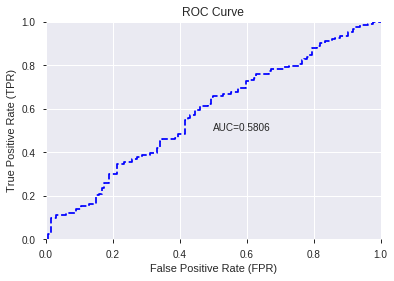

This function is available for GLM models only


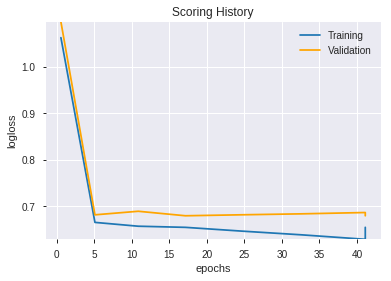

--2019-08-22 15:55:10--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.177.139
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.177.139|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_154704_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_154704_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_a064',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'MINUS_DI_8',
 'SUB',
 'CDLGRAVESTONEDOJI',
 'DIV',
 'CDLRICKSHAWMAN',
 'STOCHF_fastk',
 'CDLDRAGONFLYDOJI',
 'CDLLONGLEGGEDDOJI',
 'CDLDOJI',
 'CDLTAKURI',
 'CDLEVENINGDOJISTAR',
 'CDLSTICKSANDWICH',
 'CDLHIKKAKEMOD',
 'CDLADVANCEBLOCK',
 'HT_TRENDMODE',
 'CORREL_14',
 'CDLONNECK',
 'CDLINVERTEDHAMMER',
 'CDLXSIDEGAP3METHODS',
 'SAREXT',
 'CDLMORNINGDOJISTAR',
 'CDLBREAKAWAY',
 'CDLEVENINGSTAR',
 'weekday_name',
 'CDLMORNINGSTAR',
 'day',
 'dayofweek',
 'CDLABANDONEDBABY',
 'CDLSEPARATINGLINES',
 'days_in_month',
 'CDLTHRUSTING',
 'weekday',
 'CORREL_12',
 'CORREL_20',
 'CDLSHOOTINGSTAR',
 'CORREL_24',
 'is_quarter_start',
 'CDLMATCHINGLOW',
 'is_month_start',
 'is_month_end',
 'CORREL_30',
 'is_quarter_end',
 'CDLCOUNTERATTACK',
 'aroondown_8',
 'CORREL_8',
 'CDLHANGINGMAN',
 'CDLHAMMER',
 'CDLHARAMICROSS',
 'CDL3INSIDE']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_155521_model_1  0.593597  0.690173                   0.5  0.498321  0.248324

variable  relative_importance  scaled_importance  percentage
0                   BOP             0.155333           1.000000    0.116507
1            MINUS_DI_8             0.087637           0.564190    0.065732
2     CDLGRAVESTONEDOJI             0.078142           0.503063    0.058611
3      CDLDRAGONFLYDOJI             0.076210           0.490622    0.057161
4             CDLTAKURI             0.070270           0.452386    0.052706
5                   SUB             0.061706           0.397248    0.046282
6        CDLRICKSHAWMAN             0.049840           0.320860    0.037383
7                   DIV             0.048115           0.309756    0.036089
8             CORREL_14             0.047812           0.307803    0.035861
9          STOCHF_fastk             0.036310           0.233756    0.027234
10   CDLMORNINGDOJISTAR             0.034692           0.223341    0.026021
11    CDLINVERTEDHAMMER             0.033571           0.216121    0.025180
12         weekday_name             0.032857           0.211526    0.024644
13   CDLEVENINGDOJISTAR             0.031609           0.203492    0.023708
14            CDLHAMMER             0.028754           0.185114    0.021567
15         CDLTHRUSTING             0.025053           0.161288    0.018791
16     CDLABANDONEDBABY             0.024987           0.160861    0.018741
17  CDLXSIDEGAP3METHODS             0.024216           0.155894    0.018163
18              CDLDOJI             0.023790           0.153155    0.017844
19         CDLBREAKAWAY             0.023544           0.151574    0.017660
20            CORREL_20             0.021921           0.141120    0.016442
21        days_in_month             0.021784           0.140241    0.016339
22        CDLHIKKAKEMOD             0.021467           0.138200    0.016101
23       CDLMORNINGSTAR             0.020051           0.129086    0.015040
24      CDLADVANCEBLOCK             0.019321           0.124384    0.014492
25            CORREL_24             0.018971           0.122130    0.014229
26              weekday             0.018506           0.119137    0.013880
27            dayofweek             0.018501           0.119105    0.013877
28         HT_TRENDMODE             0.018475           0.118940    0.013857
29    CDLLONGLEGGEDDOJI             0.017437           0.112253    0.013078
30            CDLONNECK             0.016494           0.106183    0.012371
31   CDLSEPARATINGLINES             0.015160           0.097597    0.011371
32            CORREL_30             0.013178           0.084837    0.009884
33            CORREL_12             0.012667           0.081550    0.009501
34                  day             0.012136           0.078127    0.009102
35       CDLHARAMICROSS             0.011756           0.075682    0.008817
36     CDLSTICKSANDWICH             0.011261           0.072498    0.008447
37         is_month_end             0.010376           0.066799    0.007783
38       is_quarter_end             0.006963           0.044825    0.005222
39          aroondown_8             0.005907           0.038025    0.004430
40               SAREXT             0.005426           0.034930    0.004070
41      CDLSHOOTINGSTAR             0.004515           0.029064    0.003386
42     CDLCOUNTERATTACK             0.004362           0.028083    0.003272
43       CDLMATCHINGLOW             0.003913           0.025189    0.002935
44        CDLHANGINGMAN             0.003020           0.019441    0.002265
45       is_month_start             0.002377           0.015301    0.001783
46       CDLEVENINGSTAR             0.001344           0.008653    0.001008
47     is_quarter_start             0.001054           0.006783    0.000790
48           CDL3INSIDE             0.000324           0.002087    0.000243
49             CORREL_8             0.000130           0.000839    0.000098

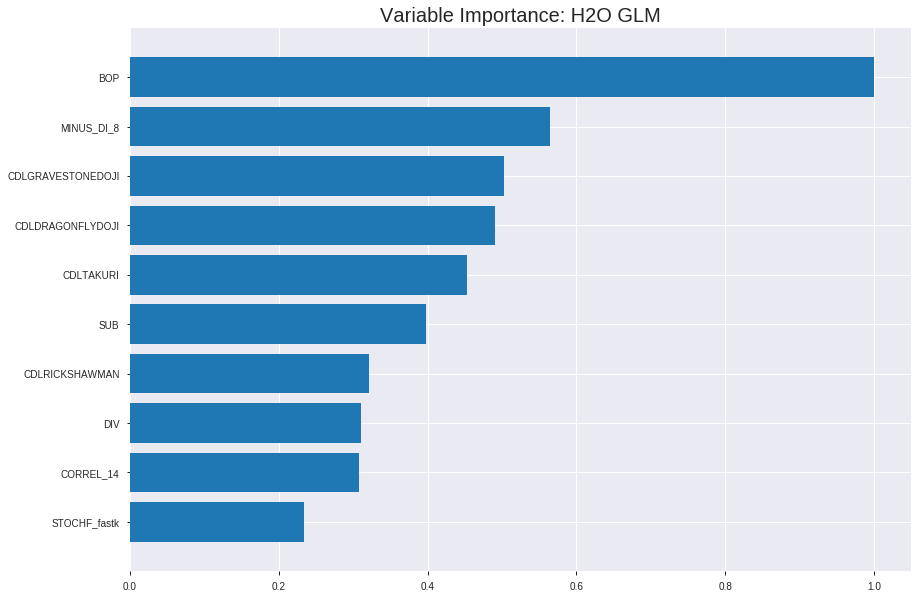

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_155521_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.23293017239929362
RMSE: 0.48262839990959255
LogLoss: 0.6580998708816247
Null degrees of freedom: 1787
Residual degrees of freedom: 1737
Null deviance: 2478.190938357651
Residual deviance: 2353.36513827269
AIC: 2455.36513827269
AUC: 0.658510959173278
pr_auc: 0.6557878115411161
Gini: 0.3170219183465559
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4517719070256971: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      271  608   0.6917   (608.0/879.0)
1      98   811   0.1078   (98.0/909.0)
Total  369  1419  0.3949   (706.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.451772     0.696735  272
max f2                       0.336453     0.841078  368
max f0point5                 0.506096     0.624874  198
max accuracy                 0.506096     0.618568  198
max precision                0.802697     1         0
max recall                   0.283382     1         388
max specificity              0.802697     1         0
max absolute_mcc             0.451772     0.24767   272
max min_per_class_accuracy   0.516118     0.600683  183
max mean_per_class_accuracy  0.506096     0.617503  198

Gains/Lift Table: Avg response rate: 50.84 %, avg score: 50.84 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.680572           1.85772   1.85772            0.944444         0.709634  0.944444                    0.709634            0.0187019       0.0187019                  85.7719   85.7719
    2        0.0201342                   0.660137           1.63916   1.74844            0.833333         0.667413  0.888889                    0.688523            0.0165017       0.0352035                  63.9164   74.8442
    3        0.0302013                   0.642628           1.63916   1.71202            0.833333         0.64831   0.87037                     0.675119            0.0165017       0.0517052                  63.9164   71.2016
    4        0.0402685                   0.633301           1.20205   1.58453            0.611111         0.638     0.805556                    0.665839            0.0121012       0.0638064                  20.2054   58.4525
    5        0.0503356                   0.625737           1.42061   1.55174            0.722222         0.629825  0.788889                    0.658637            0.0143014       0.0781078                  42.0609   55.1742
    6        0.100112                    0.601724           1.43657   1.49448            0.730337         0.612353  0.759777                    0.635624            0.0715072       0.149615                   43.6571   49.4478
    7        0.150447                    0.584419           1.33319   1.44051            0.677778         0.592224  0.732342                    0.621103            0.0671067       0.216722                   33.3187   44.0514
    8        0.200224                    0.569534           1.23766   1.39008            0.629213         0.576614  0.706704                    0.610043            0.0616062       0.278328                   23.7661   39.0084
    9        0.300336                    0.549526           0.988993  1.25639            0.502793         0.560015  0.638734                    0.593367            0.0990099       0.377338                   -1.10072  25.6387
    10       0.399888                    0.532623           1.16031   1.23247            0.589888         0.540545  0.626573                    0.580217            0.115512        0.492849                   16.0307   23.2468
    11       0.5                         0.516311           1.0769    1.20132            0.547486         0.524605  0.610738                    0.569082            0.107811        0.60066                    7.69032   20.132
    12       0.600112                    0.501007           1.13185   1.18973            0.575419         0.508704  0.604846                    0.55901             0.113311        0.713971                   13.1847   18.9731
    13       0.699664                    0.479368           0.928246  1.15252            0.47191          0.490507  0.585931                    0.549263            0.0924092       0.806381                   -7.17544  15.2525
    14       0.799776                    0.448585           0.890093  1.11968            0.452514         0.465064  0.569231                    0.538723            0.0891089       0.89549                    -10.9907  11.9675
    15       0.899888                    0.392968           0.637351  1.06602            0.324022         0.422325  0.541952                    0.525774            0.0638064       0.959296                   -36.2649  6.60169
    16       1                           0.190246           0.406586  1                  0.206704         0.352122  0.508389                    0.508389          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24520838998813593
RMSE: 0.4951852077638587
LogLoss: 0.6830781090430589
Null degrees of freedom: 510
Residual degrees of freedom: 460
Null deviance: 709.8491425809777
Residual deviance: 698.1058274420062
AIC: 800.1058274420062
AUC: 0.5702465331278891
pr_auc: 0.5005546580574951
Gini: 0.14049306625577818
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35315146205176434: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      30   245  0.8909   (245.0/275.0)
1      6    230  0.0254   (6.0/236.0)
Total  36   475  0.4912   (251.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.353151     0.646976  366
max f2                       0.322191     0.81484   386
max f0point5                 0.474795     0.545866  244
max accuracy                 0.51206      0.563601  169
max precision                0.723082     1         0
max recall                   0.240428     1         396
max specificity              0.723082     1         0
max absolute_mcc             0.353151     0.162997  366
max min_per_class_accuracy   0.503307     0.550847  188
max mean_per_class_accuracy  0.477436     0.569576  237

Gains/Lift Table: Avg response rate: 46.18 %, avg score: 48.84 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.638242           1.08263   1.08263            0.5              0.662992  0.5                         0.662992            0.0127119       0.0127119                  8.26271   8.26271
    2        0.0215264                   0.627583           0.866102  0.984206           0.4              0.632059  0.454545                    0.648932            0.00847458      0.0211864                  -13.3898  -1.57935
    3        0.0313112                   0.617437           1.29915   1.08263            0.6              0.622066  0.5                         0.640536            0.0127119       0.0338983                  29.9153   8.26271
    4        0.0410959                   0.610694           1.29915   1.13418            0.6              0.613111  0.52381                     0.634006            0.0127119       0.0466102                  29.9153   13.4181
    5        0.0508806                   0.607188           0.866102  1.08263            0.4              0.608502  0.5                         0.629101            0.00847458      0.0550847                  -13.3898  8.26271
    6        0.101761                    0.572623           1.08263   1.08263            0.5              0.587081  0.5                         0.608091            0.0550847       0.110169                   8.26271   8.26271
    7        0.150685                    0.558378           1.12593   1.09669            0.52             0.565821  0.506494                    0.594367            0.0550847       0.165254                   12.5932   9.66872
    8        0.201566                    0.547376           1.16591   1.11416            0.538462         0.552991  0.514563                    0.583923            0.059322        0.224576                   16.5906   11.416
    9        0.30137                     0.529388           1.10386   1.11075            0.509804         0.53789   0.512987                    0.568678            0.110169        0.334746                   10.3855   11.0747
    10       0.401174                    0.517116           1.18877   1.13016            0.54902          0.522182  0.521951                    0.557111            0.118644        0.45339                    18.8767   13.0157
    11       0.500978                    0.502078           0.976487  1.09954            0.45098          0.509799  0.507812                    0.547685            0.0974576       0.550847                   -2.35128  9.95432
    12       0.600783                    0.483033           1.14631   1.10731            0.529412         0.492093  0.511401                    0.53845             0.114407        0.665254                   14.6311   10.7312
    13       0.700587                    0.460906           1.01894   1.09472            0.470588         0.472008  0.505587                    0.528985            0.101695        0.766949                   1.89432   9.47235
    14       0.800391                    0.433812           0.721751  1.04822            0.333333         0.44848   0.484108                    0.518946            0.0720339       0.838983                   -27.8249  4.8216
    15       0.900196                    0.372238           0.934031  1.03556            0.431373         0.404702  0.478261                    0.50628             0.0932203       0.932203                   -6.59688  3.55564
    16       1                           0.106221           0.679295  1                  0.313725         0.326869  0.46184                     0.488374          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-22 15:55:21  0.000 sec   2            8.3       51            1.37838           1.3846
    2019-08-22 15:55:22  0.055 sec   4            5.2       51            1.37432           1.38233
    2019-08-22 15:55:22  0.103 sec   6            3.2       51            1.36852           1.3793
    2019-08-22 15:55:22  0.135 sec   8            2         51            1.36072           1.37563
    2019-08-22 15:55:22  0.181 sec   10           1.2       51            1.35096           1.37177
    2019-08-22 15:55:22  0.221 sec   12           0.77      51            1.3397            1.36845
    2019-08-22 15:55:22  0.260 sec   14           0.48      51            1.3278            1.36645
    2019-08-22 15:55:22  0.299 sec   16           0.3       51            1.3162            1.36616
    2019-08-22 15:55:22  0.339 sec   18           0.18      51            1.30573           1.36749
    2019-08-22 15:55:22  0.385 sec   20           0.11      51            1.29697           1.37011
    2019-08-22 15:55:22  0.432 sec   22           0.071     51            1.2902            1.37362
    2019-08-22 15:55:22  0.470 sec   24           0.044     51            1.2854            1.3777
    2019-08-22 15:55:22  0.509 sec   26           0.027     51            1.28226           1.382

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.609375)

('F1', 0.6526315789473685)

('auc', 0.5935972629521017)

('logloss', 0.6901729263353853)

('mean_per_class_error', 0.3912512218963832)

('rmse', 0.49832147051139336)

('mse', 0.2483242879726375)

glm prediction progress: |████████████████████████████████████████████████| 100%


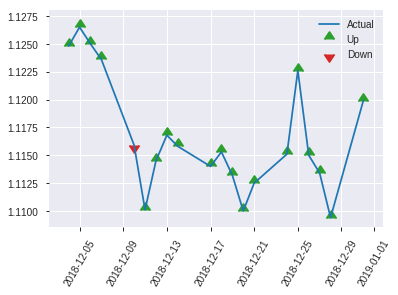


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2483242879726375
RMSE: 0.49832147051139336
LogLoss: 0.6901729263353853
Null degrees of freedom: 255
Residual degrees of freedom: 205
Null deviance: 355.23191699062966
Residual deviance: 353.36853828371727
AIC: 455.36853828371727
AUC: 0.5935972629521017
pr_auc: 0.5516509459906253
Gini: 0.18719452590420338
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29373935098248494: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    132  1        (132.0/132.0)
1      0    124  0        (0.0/124.0)
Total  0    256  0.5156   (132.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.293739     0.652632  255
max f2                       0.293739     0.824468  255
max f0point5                 0.540042     0.596405  121
max accuracy                 0.541116     0.609375  119
max precision                0.673058     0.714286  6
max recall                   0.293739     1         255
max specificity              0.75308      0.992424  0
max absolute_mcc             0.540042     0.217631  121
max min_per_class_accuracy   0.537851     0.604839  126
max mean_per_class_accuracy  0.540042     0.608749  121

Gains/Lift Table: Avg response rate: 48.44 %, avg score: 52.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.707986           1.37634   1.37634            0.666667         0.728459  0.666667                    0.728459            0.016129        0.016129                   37.6344   37.6344
    2        0.0234375                   0.67796            1.37634   1.37634            0.666667         0.691698  0.666667                    0.710079            0.016129        0.0322581                  37.6344   37.6344
    3        0.03125                     0.665801           1.03226   1.29032            0.5              0.671122  0.625                       0.70034             0.00806452      0.0403226                  3.22581   29.0323
    4        0.0429688                   0.648048           0.688172  1.1261             0.333333         0.656166  0.545455                    0.688292            0.00806452      0.0483871                  -31.1828  12.61
    5        0.0507812                   0.631081           1.03226   1.11166            0.5              0.639329  0.538462                    0.680759            0.00806452      0.0564516                  3.22581   11.1663
    6        0.101562                    0.60137            0.635236  0.873449           0.307692         0.614163  0.423077                    0.647461            0.0322581       0.0887097                  -36.4764  -12.6551
    7        0.152344                    0.586962           1.90571   1.21754            0.923077         0.593557  0.589744                    0.629493            0.0967742       0.185484                   90.5707   21.7535
    8        0.203125                    0.57789            1.11166   1.19107            0.538462         0.582474  0.576923                    0.617738            0.0564516       0.241935                   11.1663   19.1067
    9        0.300781                    0.563762           1.48645   1.28697            0.72             0.569883  0.623377                    0.602201            0.145161        0.387097                   48.6452   28.6971
    10       0.402344                    0.548098           0.952854  1.20263            0.461538         0.555666  0.582524                    0.590454            0.0967742       0.483871                   -4.71464  20.2631
    11       0.5                         0.537516           1.23871   1.20968            0.6              0.542503  0.585938                    0.581089            0.120968        0.604839                   23.871    20.9677
    12       0.601562                    0.519643           0.71464   1.1261             0.346154         0.528438  0.545455                    0.5722              0.0725806       0.677419                   -28.536   12.61
    13       0.699219                    0.505872           0.660645  1.06109            0.32             0.511678  0.513966                    0.563747            0.0645161       0.741935                   -33.9355  6.10921
    14       0.800781                    0.475867           0.873449  1.03729            0.423077         0.494377  0.502439                    0.554949            0.0887097       0.830645                   -12.6551  3.72935
    15       0.898438                    0.405056           0.825806  1.01431            0.4              0.440475  0.491304                    0.542506            0.0806452       0.91129                    -17.4194  1.43058
    16       1                           0.293739           0.873449  1                  0.423077         0.364769  0.484375                    0.524455            

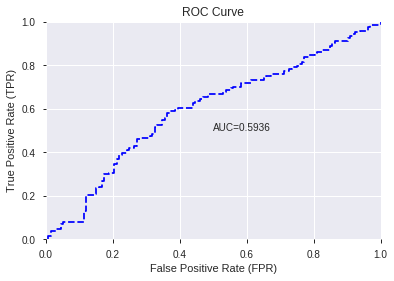

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


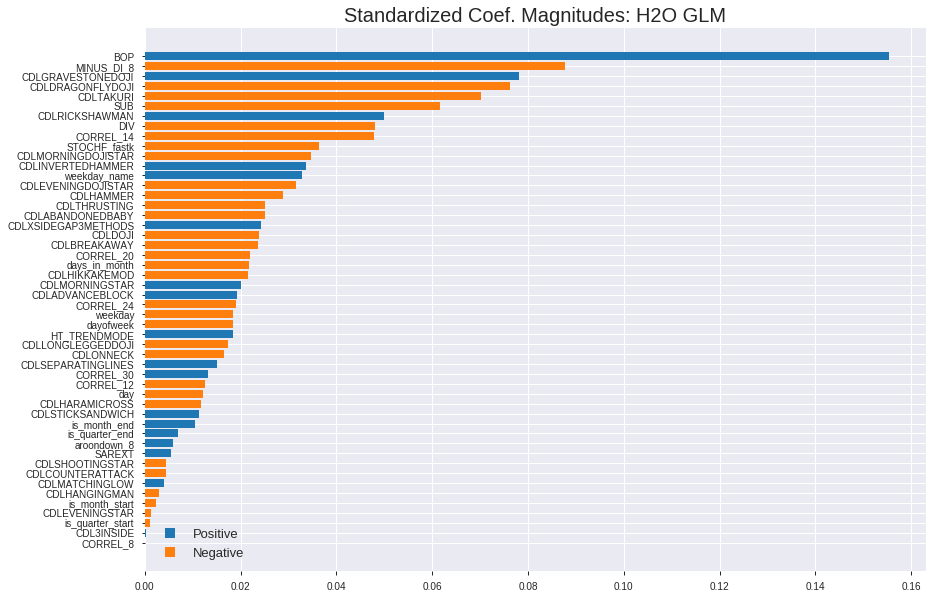

'log_likelihood'
--2019-08-22 15:55:29--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.206.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.206.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_155521_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_155521_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_a064',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'MINUS_DI_8',
 'CDLGRAVESTONEDOJI',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'SUB',
 'CDLRICKSHAWMAN',
 'DIV',
 'CORREL_14',
 'STOCHF_fastk',
 'CDLMORNINGDOJISTAR',
 'CDLINVERTEDHAMMER',
 'weekday_name',
 'CDLEVENINGDOJISTAR',
 'CDLHAMMER',
 'CDLTHRUSTING',
 'CDLABANDONEDBABY',
 'CDLXSIDEGAP3METHODS',
 'CDLDOJI',
 'CDLBREAKAWAY',
 'CORREL_20',
 'days_in_month',
 'CDLHIKKAKEMOD',
 'CDLMORNINGSTAR',
 'CDLADVANCEBLOCK',
 'CORREL_24',
 'weekday',
 'dayofweek',
 'HT_TRENDMODE',
 'CDLLONGLEGGEDDOJI',
 'CDLONNECK',
 'CDLSEPARATINGLINES',
 'CORREL_30',
 'CORREL_12',
 'day',
 'CDLHARAMICROSS',
 'CDLSTICKSANDWICH',
 'is_month_end',
 'is_quarter_end',
 'aroondown_8',
 'SAREXT',
 'CDLSHOOTINGSTAR',
 'CDLCOUNTERATTACK',
 'CDLMATCHINGLOW',
 'CDLHANGINGMAN',
 'is_month_start',
 'CDLEVENINGSTAR',
 'is_quarter_start',
 'CDL3INSIDE',
 'CORREL_8']

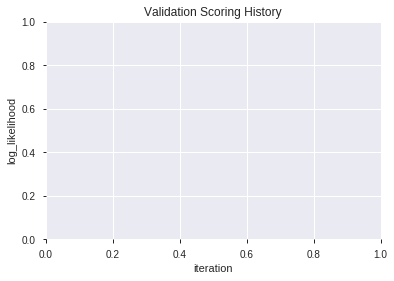

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_155538_model_2  0.625672  0.674699              0.409213  0.490838  0.240922
1  XGBoost_grid_1_AutoML_20190822_155538_model_4  0.621823  0.673331              0.436828  0.490193  0.240289
2               XGBoost_2_AutoML_20190822_155538  0.617119  0.677481              0.373656  0.492014  0.242077
3  XGBoost_grid_1_AutoML_20190822_155538_model_1  0.613575  0.679727              0.419110  0.493281  0.243326
4               XGBoost_1_AutoML_20190822_155538  0.607710  0.693723              0.436828  0.498986  0.248987
5               XGBoost_3_AutoML_20190822_155538  0.594758  0.684306              0.434262  0.495688  0.245707
6  XGBoost_grid_1_AutoML_20190822_155538_model_7  0.588710  0.694077              0.430718  0.499956  0.249956
7  XGBoost_grid_1_AutoML_20190822_155538_model_6  0.581928  0.692895              0.448192  0.499619  0.249619
8  XGBoost_grid_1_AutoML_20190822_155538_model_3  0.573925  0.693213              0.473974  0.499902  0.249902
9  XGBoost_grid_1_AutoML_20190822_155538_model_5  0.563783  0.721927              0.451491  0.511510  0.261642

variable  relative_importance  scaled_importance  percentage
0                  BOP           704.562622           1.000000    0.144070
1                  DIV           496.126648           0.704163    0.101449
2         STOCHF_fastk           450.707947           0.639699    0.092161
3               SAREXT           418.474274           0.593949    0.085570
4           MINUS_DI_8           329.547363           0.467733    0.067386
5            CORREL_30           228.567352           0.324410    0.046738
6            CORREL_12           222.689209           0.316067    0.045536
7            CORREL_14           216.632782           0.307471    0.044297
8          aroondown_8           210.165558           0.298292    0.042975
9                  day           193.092926           0.274061    0.039484
10    CDLDRAGONFLYDOJI           179.234848           0.254392    0.036650
11            CORREL_8           176.077835           0.249911    0.036005
12           CORREL_20           173.546478           0.246318    0.035487
13                 SUB           159.013214           0.225691    0.032515
14   CDLGRAVESTONEDOJI           155.069672           0.220094    0.031709
15           CORREL_24           109.373772           0.155236    0.022365
16      CDLRICKSHAWMAN           107.731476           0.152905    0.022029
17        weekday_name            82.426888           0.116990    0.016855
18           dayofweek            59.924847           0.085053    0.012254
19           CDLTAKURI            40.841259           0.057967    0.008351
20       days_in_month            38.724854           0.054963    0.007919
21     CDLSHOOTINGSTAR            33.963169           0.048205    0.006945
22       CDLHANGINGMAN            12.967016           0.018404    0.002652
23          CDL3INSIDE            12.021935           0.017063    0.002458
24     CDLADVANCEBLOCK            10.360204           0.014704    0.002118
25             weekday            10.312941           0.014637    0.002109
26             CDLDOJI             9.613133           0.013644    0.001966
27           CDLHAMMER             8.581135           0.012179    0.001755
28        HT_TRENDMODE             7.166773           0.010172    0.001465
29    is_quarter_start             7.015272           0.009957    0.001434
30    CDLABANDONEDBABY             5.204309           0.007387    0.001064
31        is_month_end             4.657035           0.006610    0.000952
32   CDLLONGLEGGEDDOJI             4.550066           0.006458    0.000930
33      is_quarter_end             3.875240           0.005500    0.000792
34  CDLEVENINGDOJISTAR             2.830917           0.004018    0.000579
35      is_month_start             2.071603           0.002940    0.000424
36   CDLINVERTEDHAMMER             1.446711           0.002053    0.000296
37      CDLMATCHINGLOW             1.250141           0.001774    0.000256

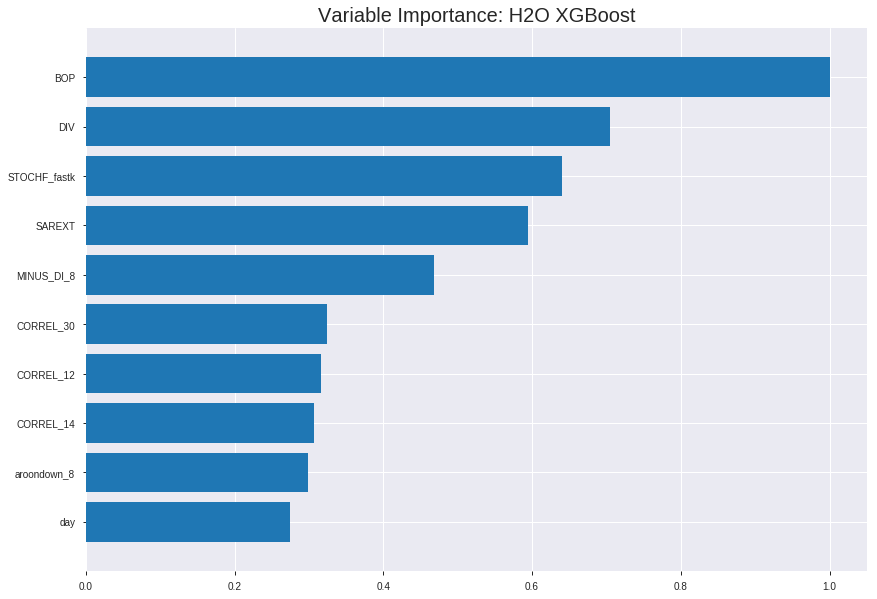

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_155538_model_2


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.19536484031904203
RMSE: 0.4420009505861294
LogLoss: 0.5795280598600994
Mean Per-Class Error: 0.24042847970803904
AUC: 0.8426723787282027
pr_auc: 0.8371782894295171
Gini: 0.6853447574564053
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47960346937179565: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      530  349   0.397    (349.0/879.0)
1      107  802   0.1177   (107.0/909.0)
Total  637  1151  0.255    (456.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.479603     0.778641  226
max f2                       0.391425     0.867526  293
max f0point5                 0.558445     0.786137  148
max accuracy                 0.505287     0.760067  202
max precision                0.792178     1         0
max recall                   0.251112     1         377
max specificity              0.792178     1         0
max absolute_mcc             0.504502     0.521899  203
max min_per_class_accuracy   0.520235     0.756876  187
max mean_per_class_accuracy  0.521317     0.759572  186

Gains/Lift Table: Avg response rate: 50.84 %, avg score: 50.85 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.755456           1.85772    1.85772            0.944444         0.770016  0.944444                    0.770016            0.0187019       0.0187019                  85.7719   85.7719
    2        0.0201342                   0.734042           1.967      1.91236            1                0.744416  0.972222                    0.757216            0.019802        0.0385039                  96.6997   91.2358
    3        0.0302013                   0.724632           1.63916    1.82129            0.833333         0.729011  0.925926                    0.747815            0.0165017       0.0550055                  63.9164   82.1293
    4        0.0402685                   0.703531           1.74844    1.80308            0.888889         0.715363  0.916667                    0.739702            0.0176018       0.0726073                  74.8442   80.308
    5        0.0503356                   0.691691           1.967      1.83586            1                0.697166  0.933333                    0.731195            0.019802        0.0924092                  96.6997   83.5864
    6        0.100112                    0.651799           1.81229    1.82414            0.921348         0.669132  0.927374                    0.700337            0.090209        0.182618                   81.2289   82.4142
    7        0.150447                    0.624589           1.7703     1.80613            0.9              0.63735   0.918216                    0.679263            0.0891089       0.271727                   77.0297   80.6127
    8        0.200224                    0.607373           1.67968    1.77469            0.853933         0.615405  0.902235                    0.663388            0.0836084       0.355336                   67.9683   77.4693
    9        0.300336                    0.576081           1.60437    1.71792            0.815642         0.591064  0.873371                    0.63928             0.160616        0.515952                   60.4366   71.7917
    10       0.399888                    0.54886            1.29291    1.61211            0.657303         0.562878  0.81958                     0.62026             0.128713        0.644664                   29.2914   61.2112
    11       0.5                         0.521151           1.09888    1.50935            0.558659         0.535657  0.767338                    0.60332             0.110011        0.754675                   9.88808   50.9351
    12       0.600112                    0.490906           0.890093   1.40605            0.452514         0.506718  0.714818                    0.587205            0.0891089       0.843784                   -10.9907  40.6045
    13       0.699664                    0.456108           0.651982   1.29875            0.331461         0.475331  0.660272                    0.571287            0.0649065       0.908691                   -34.8018  29.8752
    14       0.799776                    0.40866            0.571418   1.20771            0.290503         0.43378   0.613986                    0.554074            0.0572057       0.965897                   -42.8582  20.7708
    15       0.899888                    0.333436           0.263731   1.10269            0.134078         0.373702  0.560597                    0.534008            0.0264026       0.992299                   -73.6269  10.2692
    16       1                           0.185784           0.0769217  1                  0.0391061        0.279412  0.508389                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.24435420715182699
RMSE: 0.49432196709414705
LogLoss: 0.6814117746370513
Mean Per-Class Error: 0.42349768875192595
AUC: 0.5786055469953775
pr_auc: 0.5067864644008346
Gini: 0.15721109399075495
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.368592232465744: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      58   217  0.7891   (217.0/275.0)
1      21   215  0.089    (21.0/236.0)
Total  79   432  0.4658   (238.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.368592     0.643713  330
max f2                       0.249699     0.8125    384
max f0point5                 0.446482     0.553528  267
max accuracy                 0.493882     0.571429  198
max precision                0.641512     0.611111  17
max recall                   0.213148     1         397
max specificity              0.708658     0.996364  0
max absolute_mcc             0.368592     0.168137  330
max min_per_class_accuracy   0.498407     0.563636  190
max mean_per_class_accuracy  0.446482     0.576502  267

Gains/Lift Table: Avg response rate: 46.18 %, avg score: 48.33 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.669025           0.721751  0.721751           0.333333         0.684868  0.333333                    0.684868            0.00847458      0.00847458                 -27.8249  -27.8249
    2        0.0215264                   0.656284           1.7322    1.18105            0.8              0.660413  0.545455                    0.673752            0.0169492       0.0254237                  73.2203   18.1048
    3        0.0313112                   0.643816           1.29915   1.21796            0.6              0.648871  0.5625                      0.665977            0.0127119       0.0381356                  29.9153   21.7956
    4        0.0410959                   0.636258           1.29915   1.23729            0.6              0.639851  0.571429                    0.659756            0.0127119       0.0508475                  29.9153   23.7288
    5        0.0508806                   0.627269           0         0.999348           0                0.630793  0.461538                    0.654187            0               0.0508475                  -100      -0.065189
    6        0.101761                    0.605303           1.24919   1.12427            0.576923         0.616215  0.519231                    0.635201            0.0635593       0.114407                   24.9185   12.4267
    7        0.150685                    0.589272           1.12593   1.12481            0.52             0.597396  0.519481                    0.622926            0.0550847       0.169492                   12.5932   12.4807
    8        0.201566                    0.578513           1.08263   1.11416            0.5              0.583549  0.514563                    0.612986            0.0550847       0.224576                   8.26271   11.416
    9        0.30137                     0.545855           0.976487  1.06857            0.45098          0.563594  0.493506                    0.596629            0.0974576       0.322034                   -2.35128  6.8567
    10       0.401174                    0.519406           1.35859   1.14072            0.627451         0.531985  0.526829                    0.580547            0.135593        0.457627                   35.8591   14.0719
    11       0.500978                    0.497772           1.14631   1.14183            0.529412         0.507567  0.527344                    0.566008            0.114407        0.572034                   14.6311   14.1833
    12       0.600783                    0.472062           0.976487  1.11437            0.45098          0.485809  0.514658                    0.552685            0.0974576       0.669492                   -2.35128  11.4365
    13       0.700587                    0.441808           1.0614    1.10682            0.490196         0.455968  0.511173                    0.538907            0.105932        0.775424                   6.13991   10.682
    14       0.800391                    0.396041           0.806663  1.06939            0.372549         0.419805  0.493888                    0.524055            0.0805085       0.855932                   -19.3337  6.93921
    15       0.900196                    0.333561           0.806663  1.04026            0.372549         0.366521  0.480435                    0.50659             0.0805085       0.936441                   -19.3337  4.02634
    16       1                           0.198981           0.636839  1                  0.294118         0.273376  0.46184                     0.483314         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 15:55:47  1.359 sec   0                  0.5              0.693147            0.5             0                  1                0.491611                         0.5                0.693147              0.5               0                    1                  0.53816
    2019-08-22 15:55:47  1.513 sec   5                  0.490632         0.674552            0.73622         0.658212           1.6896           0.354586                         0.497065           0.687281              0.575054          0.525624             1.4435             0.489237
    2019-08-22 15:55:47  1.631 sec   10                 0.482994         0.659525            0.756612        0.723343           1.71043          0.337248                         0.495699           0.684519              0.575824          0.512942             1.4435             0.514677
    2019-08-22 15:55:48  1.735 sec   15                 0.475663         0.645192            0.779859        0.765579           1.86347          0.288031                         0.494369           0.681795              0.577527          0.520095             1.80438            0.475538
    2019-08-22 15:55:48  1.833 sec   20                 0.469377         0.632892            0.7907          0.777216           1.967            0.290828                         0.493717           0.680418              0.578806          0.515024             1.08263            0.489237
    2019-08-22 15:55:48  1.935 sec   25                 0.463985         0.622319            0.798879        0.786419           1.967            0.284676                         0.493816           0.680541              0.576911          0.511354             0.721751           0.489237
    2019-08-22 15:55:48  2.080 sec   30                 0.459107         0.612773            0.806797        0.796851           1.967            0.27349                          0.493732           0.680288              0.577103          0.511544             0.721751           0.493151
    2019-08-22 15:55:48  2.198 sec   35                 0.454174         0.603185            0.818492        0.810288           1.85772          0.261186                         0.494195           0.681185              0.573552          0.50849              1.08263            0.499022
    2019-08-22 15:55:48  2.305 sec   40                 0.45009          0.59524             0.827998        0.820156           1.85772          0.263423                         0.493446           0.679612              0.579052          0.511153             0.721751           0.495108
    2019-08-22 15:55:48  2.433 sec   45                 0.445816         0.586885            0.83451         0.828978           1.85772          0.262304                         0.494107           0.680942              0.57688           0.507066             1.08263            0.497065
    2019-08-22 15:55:48  2.579 sec   50                 0.442001         0.579528            0.842672        0.837178           1.85772          0.255034                         0.494322           0.681412              0.578606          0.506786             0.721751           0.465753

Variable Importances: 


variable            relative_importance    scaled_importance      percentage
------------------  ---------------------  ---------------------  ----------------------
BOP                 704.5626220703125      1.0                    0.14406997870377208
DIV                 496.12664794921875     0.7041626001836176     0.10144869081244656
STOCHF_fastk        450.70794677734375     0.6396989176816776     0.09216140944722534
SAREXT              418.4742736816406      0.5939490125831265     0.08557022159397748
MINUS_DI_8          329.54736328125        0.46773324749033096    0.06738631900497813
---                 ---                    ---                    ---
is_quarter_end      3.8752403259277344     0.005500207085270273   0.0007924147176412245
CDLEVENINGDOJISTAR  2.8309173583984375     0.004017978345317222   0.0005788700546420695
is_month_start      2.0716030597686768     0.0029402681818138502  0.00042360437433730004
CDLINVERTEDHAMMER   1.4467110633850098     0.0020533463145319024  0.00029582555980608007
CDLMATCHINGLOW      1.2501413822174072     0.0017743509846490952  0.0002556307085714121


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6171875)

('F1', 0.6687306501547987)

('auc', 0.6256720430107527)

('logloss', 0.6746987884162547)

('mean_per_class_error', 0.3775659824046921)

('rmse', 0.49083758281304685)

('mse', 0.24092153270175465)

xgboost prediction progress: |████████████████████████████████████████████| 100%


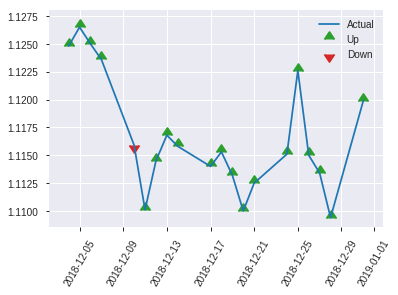


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24092153270175465
RMSE: 0.49083758281304685
LogLoss: 0.6746987884162547
Mean Per-Class Error: 0.3775659824046921
AUC: 0.6256720430107527
pr_auc: 0.5684295951721241
Gini: 0.2513440860215055
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48834824562072754: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      41   91   0.6894   (91.0/132.0)
1      16   108  0.129    (16.0/124.0)
Total  57   199  0.418    (107.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.488348     0.668731  198
max f2                       0.274561     0.826667  253
max f0point5                 0.523428     0.609453  169
max accuracy                 0.529025     0.617188  165
max precision                0.669825     0.714286  6
max recall                   0.274561     1         253
max specificity              0.694074     0.992424  0
max absolute_mcc             0.523428     0.259093  169
max min_per_class_accuracy   0.556408     0.58871   126
max mean_per_class_accuracy  0.523428     0.622434  169

Gains/Lift Table: Avg response rate: 48.44 %, avg score: 54.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117188                   0.674086           1.37634   1.37634            0.666667         0.683172  0.666667                    0.683172            0.016129        0.016129                   37.6344    37.6344
    2        0.0234375                   0.670115           1.37634   1.37634            0.666667         0.67116   0.666667                    0.677166            0.016129        0.0322581                  37.6344    37.6344
    3        0.03125                     0.669155           1.03226   1.29032            0.5              0.669817  0.625                       0.675329            0.00806452      0.0403226                  3.22581    29.0323
    4        0.0429688                   0.659887           1.37634   1.31378            0.666667         0.66494   0.636364                    0.672496            0.016129        0.0564516                  37.6344    31.3783
    5        0.0507812                   0.656848           1.03226   1.27047            0.5              0.657539  0.615385                    0.670195            0.00806452      0.0645161                  3.22581    27.0471
    6        0.101562                    0.641916           1.11166   1.19107            0.538462         0.650524  0.576923                    0.660359            0.0564516       0.120968                   11.1663    19.1067
    7        0.152344                    0.631167           1.11166   1.1646             0.538462         0.635195  0.564103                    0.651971            0.0564516       0.177419                   11.1663    16.4599
    8        0.203125                    0.614625           0.952854  1.11166            0.461538         0.622103  0.538462                    0.644504            0.0483871       0.225806                   -4.71464   11.1663
    9        0.300781                    0.600471           1.73419   1.31378            0.84             0.606133  0.636364                    0.632046            0.169355        0.395161                   73.4194    31.3783
    10       0.402344                    0.578968           0.952854  1.22267            0.461538         0.590945  0.592233                    0.621671            0.0967742       0.491935                   -4.71464   22.2675
    11       0.5                         0.555273           0.990968  1.17742            0.48             0.566212  0.570312                    0.610839            0.0967742       0.58871                    -0.903226  17.7419
    12       0.601562                    0.535882           0.952854  1.13951            0.461538         0.547956  0.551948                    0.600223            0.0967742       0.685484                   -4.71464   13.9506
    13       0.699219                    0.51381            1.15613   1.14183            0.56             0.526468  0.553073                    0.589922            0.112903        0.798387                   15.6129    14.1827
    14       0.800781                    0.476669           0.71464   1.08765            0.346154         0.496726  0.526829                    0.578102            0.0725806       0.870968                   -28.536    8.76475
    15       0.898438                    0.402397           0.743226  1.05021            0.36             0.441932  0.508696                    0.563301            0.0725806       0.943548                   -25.6774   5.02104
    16       1                           0.23755            0.555831  1                  0.269231         0.349014  0.484375                    

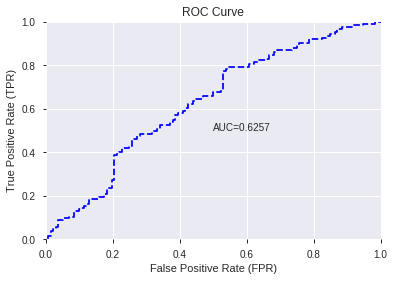

This function is available for GLM models only


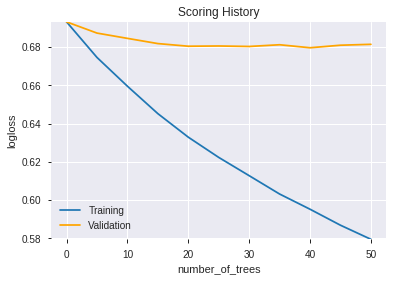

--2019-08-22 15:56:05--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.165.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.165.155|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_155538_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_155538_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_a064',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'DIV',
 'STOCHF_fastk',
 'SAREXT',
 'MINUS_DI_8',
 'CORREL_30',
 'CORREL_12',
 'CORREL_14',
 'aroondown_8',
 'day',
 'CDLDRAGONFLYDOJI',
 'CORREL_8',
 'CORREL_20',
 'SUB',
 'CDLGRAVESTONEDOJI',
 'CORREL_24',
 'CDLRICKSHAWMAN',
 'weekday_name',
 'dayofweek',
 'CDLTAKURI',
 'days_in_month',
 'CDLSHOOTINGSTAR',
 'CDLHANGINGMAN',
 'CDL3INSIDE',
 'CDLADVANCEBLOCK',
 'weekday',
 'CDLDOJI',
 'CDLHAMMER',
 'HT_TRENDMODE',
 'is_quarter_start',
 'CDLABANDONEDBABY',
 'is_month_end',
 'CDLLONGLEGGEDDOJI',
 'is_quarter_end',
 'CDLEVENINGDOJISTAR',
 'is_month_start',
 'CDLINVERTEDHAMMER',
 'CDLMATCHINGLOW']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_155616_model_1  0.563233  0.691294              0.473974  0.499071  0.249072

variable  relative_importance  scaled_importance    percentage
0                          BOP         3.939917e-02           1.000000  2.520150e-02
1             CDLDRAGONFLYDOJI         2.683051e-02           0.680992  1.716201e-02
2                    CDLTAKURI         2.569654e-02           0.652210  1.643668e-02
3            CDLGRAVESTONEDOJI         2.341665e-02           0.594344  1.497835e-02
4                          SUB         2.120806e-02           0.538287  1.356564e-02
...                        ...                  ...                ...           ...
1016  BBANDS_middleband_14_2_3         4.295831e-06           0.000109  2.747809e-06
1017   BBANDS_upperband_12_1_4         3.329079e-06           0.000084  2.129430e-06
1018   BBANDS_upperband_12_1_5         2.337552e-06           0.000059  1.495204e-06
1019                 STDDEV_12         2.073458e-06           0.000053  1.326278e-06
1020                    EMA_14         5.707535e-07           0.000014  3.650799e-07

[1021 rows x 4 columns]

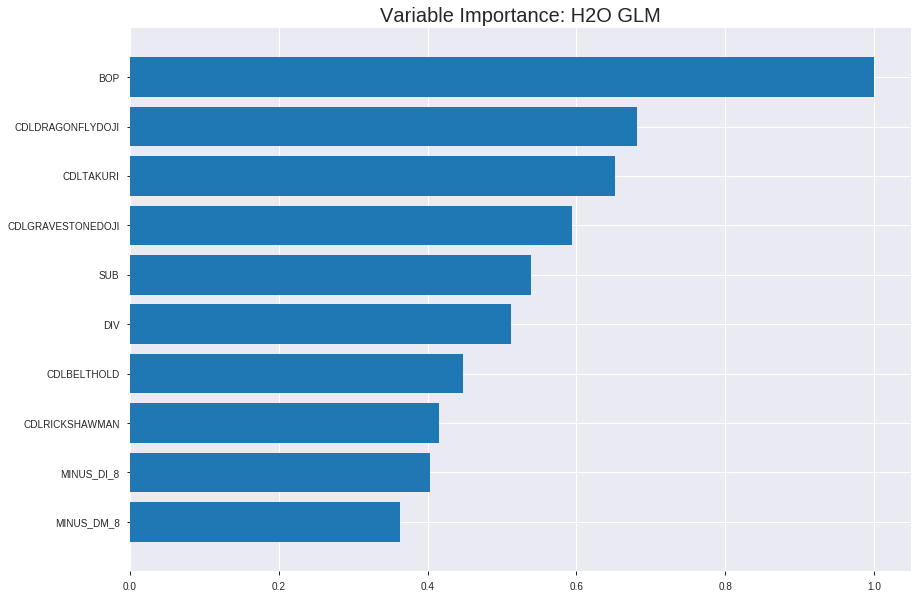

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_155616_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.23697026424294734
RMSE: 0.48679591641975317
LogLoss: 0.6667977621599153
Null degrees of freedom: 1787
Residual degrees of freedom: 766
Null deviance: 2478.190938357651
Residual deviance: 2384.468797483857
AIC: 4428.468797483857
AUC: 0.6704250629841141
pr_auc: 0.6619049608153875
Gini: 0.34085012596822817
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44342550869773206: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      146  733   0.8339   (733.0/879.0)
1      39   870   0.0429   (39.0/909.0)
Total  185  1603  0.4318   (772.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.443426     0.692675  316
max f2                       0.379376     0.840274  380
max f0point5                 0.513397     0.632839  185
max accuracy                 0.513397     0.626398  185
max precision                0.665865     1         0
max recall                   0.37245      1         385
max specificity              0.665865     1         0
max absolute_mcc             0.488585     0.258866  237
max min_per_class_accuracy   0.511207     0.624862  189
max mean_per_class_accuracy  0.513397     0.626668  185

Gains/Lift Table: Avg response rate: 50.84 %, avg score: 50.84 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.62596            1.74844   1.74844            0.888889         0.638601  0.888889                    0.638601            0.0176018       0.0176018                  74.8442   74.8442
    2        0.0201342                   0.607671           1.52989   1.63916            0.777778         0.615234  0.833333                    0.626917            0.0154015       0.0330033                  52.9886   63.9164
    3        0.0302013                   0.603136           1.42061   1.56631            0.722222         0.605134  0.796296                    0.619656            0.0143014       0.0473047                  42.0609   56.6312
    4        0.0402685                   0.595355           1.52989   1.55721            0.777778         0.599211  0.791667                    0.614545            0.0154015       0.0627063                  52.9886   55.7206
    5        0.0503356                   0.588911           1.20205   1.48618            0.611111         0.592228  0.755556                    0.610082            0.0121012       0.0748075                  20.2054   48.6175
    6        0.100112                    0.572214           1.45867   1.4725             0.741573         0.579029  0.748603                    0.594642            0.0726073       0.147415                   45.8672   47.25
    7        0.150447                    0.560608           1.35504   1.4332             0.688889         0.566152  0.728625                    0.58511             0.0682068       0.215622                   35.5042   43.3202
    8        0.200224                    0.551624           1.28186   1.39558            0.651685         0.555862  0.709497                    0.577839            0.0638064       0.279428                   28.1863   39.5579
    9        0.300336                    0.536922           1.24174   1.3443             0.631285         0.543869  0.683426                    0.566515            0.124312        0.40374                    24.1735   34.4298
    10       0.399888                    0.523704           1.13821   1.29299            0.578652         0.530314  0.657343                    0.557503            0.113311        0.517052                   13.8206   29.2991
    11       0.5                         0.511276           1.06591   1.24752            0.541899         0.517231  0.634228                    0.54944             0.106711        0.623762                   6.59144   24.7525
    12       0.600112                    0.497882           0.912071  1.19156            0.463687         0.504373  0.605778                    0.541921            0.0913091       0.715072                   -8.79289  19.1564
    13       0.699664                    0.48484            0.939296  1.15567            0.477528         0.491717  0.58753                     0.534778            0.0935094       0.808581                   -6.07038  15.567
    14       0.799776                    0.466294           0.681306  1.09629            0.346369         0.47638   0.557343                    0.527468            0.0682068       0.876788                   -31.8694  9.62912
    15       0.899888                    0.441751           0.813172  1.06479            0.413408         0.455221  0.54133                     0.519431            0.0814081       0.958196                   -18.6828  6.47944
    16       1                           0.252828           0.417575  1                  0.212291         0.409139  0.508389                    0.508389            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24881512368454622
RMSE: 0.4988137164158041
LogLoss: 0.6906165834641748
Null degrees of freedom: 510
Residual degrees of freedom: -511
Null deviance: 709.8491425809777
Residual deviance: 705.8101483003866
AIC: 2749.8101483003866
AUC: 0.5470184899845917
pr_auc: 0.4907981509957999
Gini: 0.09403697996918337
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4429954715776241: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      33   242  0.88     (242.0/275.0)
1      9    227  0.0381   (9.0/236.0)
Total  42   469  0.4912   (251.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.442995     0.643972  360
max f2                       0.371983     0.813232  395
max f0point5                 0.473845     0.545738  319
max accuracy                 0.576661     0.555773  47
max precision                0.655679     0.6       4
max recall                   0.371983     1         395
max specificity              0.707527     0.996364  0
max absolute_mcc             0.473845     0.156326  319
max min_per_class_accuracy   0.521495     0.504237  187
max mean_per_class_accuracy  0.473845     0.559461  319

Gains/Lift Table: Avg response rate: 46.18 %, avg score: 51.72 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.645691           1.08263   1.08263            0.5              0.672034  0.5                         0.672034            0.0127119       0.0127119                  8.26271   8.26271
    2        0.0215264                   0.621174           0.866102  0.984206           0.4              0.62799   0.454545                    0.652014            0.00847458      0.0211864                  -13.3898  -1.57935
    3        0.0313112                   0.612653           0.866102  0.947299           0.4              0.616095  0.4375                      0.640789            0.00847458      0.029661                   -13.3898  -5.27013
    4        0.0410959                   0.600737           0.866102  0.927966           0.4              0.607113  0.428571                    0.632771            0.00847458      0.0381356                  -13.3898  -7.20339
    5        0.0508806                   0.595206           1.7322    1.08263            0.8              0.598428  0.5                         0.626167            0.0169492       0.0550847                  73.2203   8.26271
    6        0.101761                    0.579173           1.33246   1.20755            0.615385         0.586187  0.557692                    0.606177            0.0677966       0.122881                   33.2464   20.7546
    7        0.150685                    0.568134           0.866102  1.09669            0.4              0.573575  0.506494                    0.595592            0.0423729       0.165254                   -13.3898  9.66872
    8        0.201566                    0.559184           1.08263   1.09314            0.5              0.563749  0.504854                    0.587554            0.0550847       0.220339                   8.26271   9.31381
    9        0.30137                     0.544019           1.14631   1.11075            0.529412         0.551633  0.512987                    0.575658            0.114407        0.334746                   14.6311   11.0747
    10       0.401174                    0.532345           0.849119  1.04566            0.392157         0.538099  0.482927                    0.566314            0.0847458       0.419492                   -15.0881  4.56594
    11       0.500978                    0.521044           0.849119  1.0065             0.392157         0.526441  0.464844                    0.558371            0.0847458       0.504237                   -15.0881  0.65049
    12       0.600783                    0.508014           1.18877   1.03678            0.54902          0.514892  0.478827                    0.551148            0.118644        0.622881                   18.8767   3.6783
    13       0.700587                    0.492761           1.10386   1.04634            0.509804         0.500543  0.48324                     0.543939            0.110169        0.733051                   10.3855   4.63379
    14       0.800391                    0.478194           1.27368   1.07469            0.588235         0.485829  0.496333                    0.536693            0.127119        0.860169                   27.3679   7.46861
    15       0.900196                    0.452088           0.721751  1.03556            0.333333         0.466178  0.478261                    0.528875            0.0720339       0.932203                   -27.8249  3.55564
    16       1                           0.124029           0.679295  1                  0.313725         0.412388  0.46184                     0.517249       


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-22 15:56:20  0.000 sec   2            8.3       1014          1.36825           1.38536
    2019-08-22 15:56:22  2.239 sec   4            6.1       1016          1.3635            1.38421
    2019-08-22 15:56:24  4.494 sec   6            4.4       1019          1.3577            1.38307
    2019-08-22 15:56:27  6.783 sec   8            3.2       1022          1.35075           1.38196
    2019-08-22 15:56:29  9.051 sec   10           2.3       1022          1.34268           1.3813
    2019-08-22 15:56:32  11.575 sec  12           1.7       1022          1.3336            1.38123
    2019-08-22 15:56:34  13.920 sec  14           1.2       1022          1.32369           1.38232
    2019-08-22 15:56:36  16.192 sec  16           0.9       1022          1.31323           1.38481
    2019-08-22 15:56:38  18.451 sec  18           0.66      1022          1.30249           1.38881
    2019-08-22 15:56:41  20.668 sec  20           0.48      1022          1.2917            1.3944
    2019-08-22 15:56:43  23.012 sec  22           0.35      1022          1.28104           1.40133

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5703125)

('F1', 0.6612466124661247)

('auc', 0.563233137829912)

('logloss', 0.6912943504276065)

('mean_per_class_error', 0.43279569892473113)

('rmse', 0.49907081971625344)

('mse', 0.24907168309225314)

glm prediction progress: |████████████████████████████████████████████████| 100%


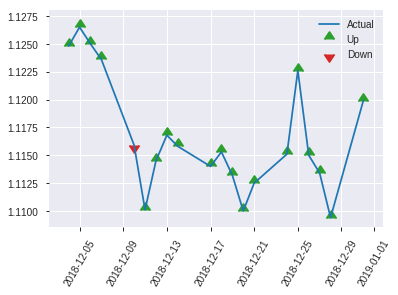


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24907168309225314
RMSE: 0.49907081971625344
LogLoss: 0.6912943504276065
Null degrees of freedom: 255
Residual degrees of freedom: -766
Null deviance: 355.23191699062966
Residual deviance: 353.9427074189345
AIC: 2397.9427074189343
AUC: 0.563233137829912
pr_auc: 0.5329354148606392
Gini: 0.12646627565982405
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.466566753865679: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      9    123  0.9318   (123.0/132.0)
1      2    122  0.0161   (2.0/124.0)
Total  11   245  0.4883   (125.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.466567     0.661247  244
max f2                       0.423839     0.828877  251
max f0point5                 0.524148     0.564721  165
max accuracy                 0.552155     0.570312  97
max precision                0.591897     0.769231  12
max recall                   0.423839     1         251
max specificity              0.658888     0.992424  0
max absolute_mcc             0.524148     0.140686  165
max min_per_class_accuracy   0.543173     0.540323  123
max mean_per_class_accuracy  0.524148     0.567204  165

Gains/Lift Table: Avg response rate: 48.44 %, avg score: 53.59 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.629136           0.688172  0.688172           0.333333         0.643098  0.333333                    0.643098            0.00806452      0.00806452                 -31.1828  -31.1828
    2        0.0234375                   0.604739           1.37634   1.03226            0.666667         0.617389  0.5                         0.630244            0.016129        0.0241935                  37.6344   3.22581
    3        0.03125                     0.598396           2.06452   1.29032            1                0.599933  0.625                       0.622666            0.016129        0.0403226                  106.452   29.0323
    4        0.0429688                   0.596188           2.06452   1.50147            1                0.597539  0.727273                    0.615813            0.0241935       0.0645161                  106.452   50.1466
    5        0.0507812                   0.591861           2.06452   1.58809            1                0.59199   0.769231                    0.612148            0.016129        0.0806452                  106.452   58.8089
    6        0.101562                    0.583697           0.794045  1.19107            0.384615         0.588295  0.576923                    0.600221            0.0403226       0.120968                   -20.5955  19.1067
    7        0.152344                    0.577466           0.476427  0.952854           0.230769         0.580696  0.461538                    0.593713            0.0241935       0.145161                   -52.3573  -4.71464
    8        0.203125                    0.572648           1.7469    1.15136            0.846154         0.575529  0.557692                    0.589167            0.0887097       0.233871                   74.6898   15.1365
    9        0.300781                    0.560169           1.32129   1.20654            0.64             0.565925  0.584416                    0.581621            0.129032        0.362903                   32.129    20.6535
    10       0.402344                    0.550727           0.873449  1.12246            0.423077         0.554724  0.543689                    0.574831            0.0887097       0.451613                   -12.6551  12.2455
    11       0.5                         0.540823           0.908387  1.08065            0.44             0.54574   0.523438                    0.56915             0.0887097       0.540323                   -9.16129  8.06452
    12       0.601562                    0.532023           0.952854  1.05907            0.461538         0.536564  0.512987                    0.563648            0.0967742       0.637097                   -4.71464  5.907
    13       0.699219                    0.515689           1.07355   1.06109            0.52             0.523897  0.513966                    0.558096            0.104839        0.741935                   7.35484   6.10921
    14       0.800781                    0.50038            0.873449  1.03729            0.423077         0.507987  0.502439                    0.551741            0.0887097       0.830645                   -12.6551  3.72935
    15       0.898438                    0.481444           0.825806  1.01431            0.4              0.491504  0.491304                    0.545193            0.0806452       0.91129                    -17.4194  1.43058
    16       1                           0.3703             0.873449  1                  0.423077         0.453495  0.484375                    0.53588          

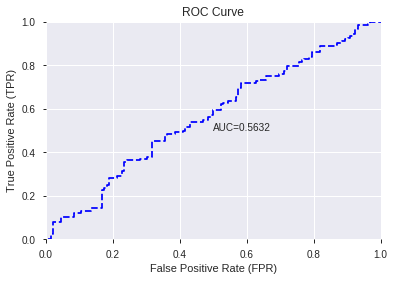

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


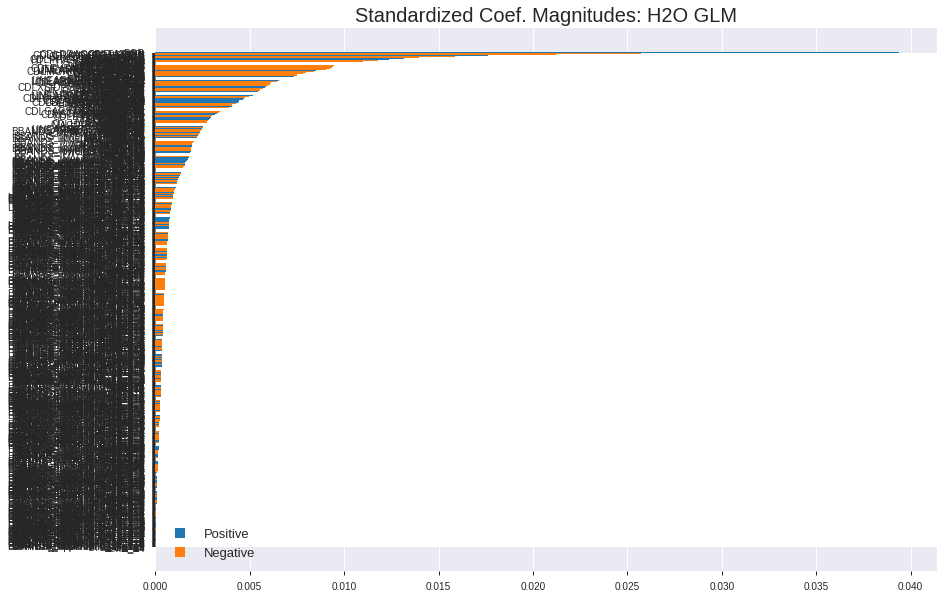

'log_likelihood'
--2019-08-22 15:57:13--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.88.107
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.88.107|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_155616_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_155616_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_a064',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

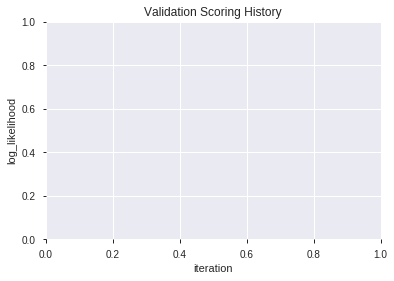

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_155723_model_7  0.624511  0.693366              0.462366  0.499386  0.249386
1               XGBoost_3_AutoML_20190822_155723  0.623167  0.681861              0.397116  0.494409  0.244440
2               XGBoost_2_AutoML_20190822_155723  0.612231  0.689599              0.430230  0.498064  0.248068
3  XGBoost_grid_1_AutoML_20190822_155723_model_4  0.607710  0.681243              0.426197  0.494149  0.244184
4  XGBoost_grid_1_AutoML_20190822_155723_model_1  0.606549  0.696271              0.454790  0.500996  0.250997
5  XGBoost_grid_1_AutoML_20190822_155723_model_5  0.604044  0.714081              0.488636  0.507985  0.258048
6               XGBoost_1_AutoML_20190822_155723  0.602578  0.694711              0.473729  0.499770  0.249770
7  XGBoost_grid_1_AutoML_20190822_155723_model_6  0.599890  0.687464              0.414589  0.496609  0.246621
8  XGBoost_grid_1_AutoML_20190822_155723_model_2  0.590420  0.681772              0.436584  0.494319  0.244352
9  XGBoost_grid_1_AutoML_20190822_155723_model_3  0.555474  0.709716              0.448436  0.507152  0.257203

variable  relative_importance  scaled_importance  percentage
0                        BOP           436.350708           1.000000    0.041330
1                        DIV           240.934830           0.552159    0.022821
2                     ULTOSC           205.027618           0.469869    0.019420
3                        SUB           165.069702           0.378296    0.015635
4          HT_PHASOR_inphase           151.602661           0.347433    0.014360
..                       ...                  ...                ...         ...
389   LINEARREG_INTERCEPT_24             2.366526           0.005423    0.000224
390                  MACDEXT             2.325420           0.005329    0.000220
391  BBANDS_lowerband_30_6_2             1.987652           0.004555    0.000188
392  BBANDS_upperband_20_1_3             1.928207           0.004419    0.000183
393   BBANDS_upperband_8_8_4             1.879382           0.004307    0.000178

[394 rows x 4 columns]

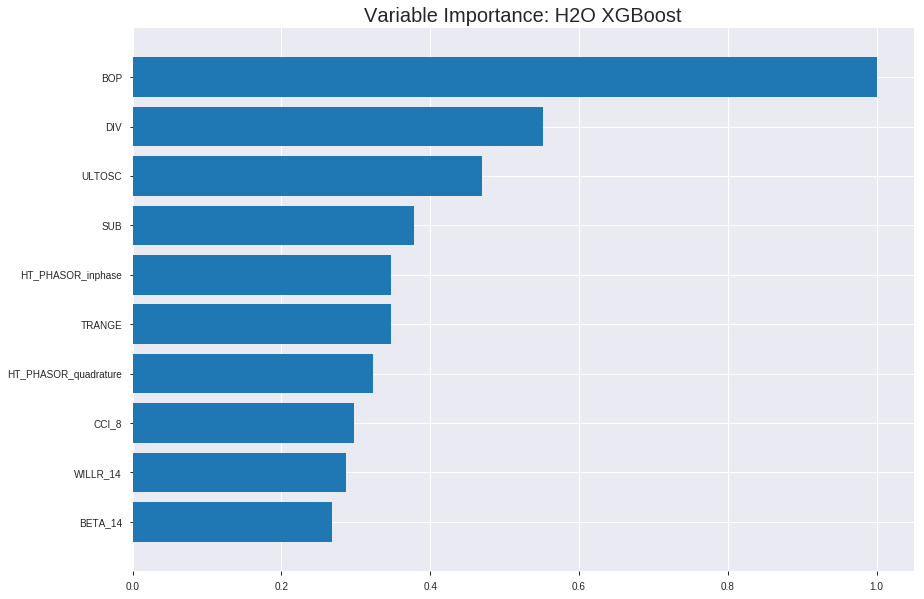

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_155723_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.11850426663197976
RMSE: 0.3442444867125395
LogLoss: 0.4104780921167206
Mean Per-Class Error: 0.06102606847715486
AUC: 0.9847755537783586
pr_auc: 0.9845415690510964
Gini: 0.9695511075567171
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4985011965036392: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      822  57   0.0648   (57.0/879.0)
1      52   857  0.0572   (52.0/909.0)
Total  874  914  0.061    (109.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.498501     0.940208  208
max f2                       0.436122     0.956969  239
max f0point5                 0.542817     0.953566  183
max accuracy                 0.498501     0.939038  208
max precision                0.912943     1         0
max recall                   0.360919     1         280
max specificity              0.912943     1         0
max absolute_mcc             0.498501     0.878044  208
max min_per_class_accuracy   0.5005       0.937294  206
max mean_per_class_accuracy  0.498501     0.938974  208

Gains/Lift Table: Avg response rate: 50.84 %, avg score: 50.60 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.848876           1.967      1.967              1                0.871042  1                           0.871042            0.019802        0.019802                   96.6997   96.6997
    2        0.0201342                   0.832759           1.967      1.967              1                0.84076   1                           0.855901            0.019802        0.039604                   96.6997   96.6997
    3        0.0302013                   0.821027           1.967      1.967              1                0.826225  1                           0.846009            0.019802        0.0594059                  96.6997   96.6997
    4        0.0402685                   0.807475           1.967      1.967              1                0.815353  1                           0.838345            0.019802        0.0792079                  96.6997   96.6997
    5        0.0503356                   0.798032           1.967      1.967              1                0.803023  1                           0.831281            0.019802        0.0990099                  96.6997   96.6997
    6        0.100112                    0.766598           1.967      1.967              1                0.780316  1                           0.805941            0.0979098       0.19692                    96.6997   96.6997
    7        0.150447                    0.740891           1.967      1.967              1                0.752314  1                           0.787999            0.0990099       0.29593                    96.6997   96.6997
    8        0.200224                    0.716199           1.967      1.967              1                0.729186  1                           0.773378            0.0979098       0.393839                   96.6997   96.6997
    9        0.300336                    0.660678           1.94502    1.95967            0.988827         0.690244  0.996276                    0.745666            0.194719        0.588559                   94.5019   95.9671
    10       0.399888                    0.600724           1.90069    1.94499            0.966292         0.632343  0.988811                    0.717454            0.189219        0.777778                   90.0693   94.4988
    11       0.5                         0.504695           1.50547    1.85699            0.765363         0.552713  0.944072                    0.684469            0.150715        0.928493                   50.5467   85.6986
    12       0.600112                    0.422544           0.571418   1.64252            0.290503         0.463292  0.835042                    0.647572            0.0572057       0.985699                   -42.8582  64.2525
    13       0.699664                    0.360701           0.132607   1.42768            0.0674157        0.389847  0.725819                    0.610901            0.0132013       0.9989                     -86.7393  42.7684
    14       0.799776                    0.294414           0.0109888  1.25035            0.00558659       0.328091  0.635664                    0.575501            0.00110011      1                          -98.9011  25.035
    15       0.899888                    0.235631           0          1.11125            0                0.267077  0.564947                    0.541189            0               1                          -100      11.1249
    16       1                           0.100965           0          1                  0                0.189696  0.508389                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25527645400766313
RMSE: 0.5052489030247004
LogLoss: 0.7087167253137179
Mean Per-Class Error: 0.41948382126348227
AUC: 0.5809090909090909
pr_auc: 0.49104712189818317
Gini: 0.16181818181818186
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3349350690841675: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      40   235  0.8545   (235.0/275.0)
1      10   226  0.0424   (10.0/236.0)
Total  50   461  0.4795   (245.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.334935     0.648494  353
max f2                       0.219448     0.813149  389
max f0point5                 0.464284     0.554556  269
max accuracy                 0.531064     0.575342  206
max precision                0.556506     0.537815  176
max recall                   0.169335     1         396
max specificity              0.862687     0.996364  0
max absolute_mcc             0.393604     0.1819    322
max min_per_class_accuracy   0.550062     0.567797  184
max mean_per_class_accuracy  0.524709     0.580516  213

Gains/Lift Table: Avg response rate: 46.18 %, avg score: 53.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.823098           0.721751  0.721751           0.333333         0.842207  0.333333                    0.842207            0.00847458      0.00847458                 -27.8249  -27.8249
    2        0.0215264                   0.809753           0.866102  0.787365           0.4              0.815446  0.363636                    0.830043            0.00847458      0.0169492                  -13.3898  -21.2635
    3        0.0313112                   0.79694            0         0.541314           0                0.801555  0.25                        0.821141            0               0.0169492                  -100      -45.8686
    4        0.0410959                   0.784282           1.7322    0.824859           0.8              0.790328  0.380952                    0.813804            0.0169492       0.0338983                  73.2203   -17.5141
    5        0.0508806                   0.774667           0.866102  0.83279            0.4              0.77878   0.384615                    0.807069            0.00847458      0.0423729                  -13.3898  -16.721
    6        0.101761                    0.720347           0.916069  0.87443            0.423077         0.73826   0.403846                    0.772664            0.0466102       0.0889831                  -8.39309  -12.557
    7        0.150685                    0.700989           1.38576   1.04045            0.64             0.710602  0.480519                    0.752514            0.0677966       0.15678                    38.5763   4.04468
    8        0.201566                    0.671422           1.24919   1.09314            0.576923         0.685231  0.504854                    0.73553             0.0635593       0.220339                   24.9185   9.31381
    9        0.30137                     0.628822           1.0614    1.08263            0.490196         0.648494  0.5                         0.706706            0.105932        0.326271                   6.13991   8.26271
    10       0.401174                    0.585978           1.23122   1.11959            0.568627         0.603412  0.517073                    0.681009            0.122881        0.449153                   23.1223   11.9595
    11       0.500978                    0.546684           1.27368   1.15029            0.588235         0.563737  0.53125                     0.657646            0.127119        0.576271                   27.3679   15.0291
    12       0.600783                    0.509541           0.934031  1.11437            0.431373         0.527882  0.514658                    0.636089            0.0932203       0.669492                   -6.59688  11.4365
    13       0.700587                    0.464284           1.14631   1.11892            0.529412         0.485754  0.51676                     0.614673            0.114407        0.783898                   14.6311   11.8916
    14       0.800391                    0.416545           0.934031  1.09586            0.431373         0.438128  0.506112                    0.592659            0.0932203       0.877119                   -6.59688  9.58622
    15       0.900196                    0.33535            0.764207  1.05909            0.352941         0.378052  0.48913                     0.568865            0.0762712       0.95339                    -23.5793  5.90917
    16       1                           0.11113            0.467016  1                  0.215686         0.26897   0.46184                     0.538934     


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 15:58:18  34.364 sec  0                  0.5              0.693147            0.5             0                  1                0.491611                         0.5                0.693147              0.5               0                    1                  0.53816
    2019-08-22 15:58:19  35.654 sec  5                  0.476473         0.646997            0.857643        0.861918           1.967            0.223714                         0.497981           0.68911               0.55849           0.488722             0.360876           0.493151
    2019-08-22 15:58:20  35.984 sec  10                 0.45517          0.606523            0.907536        0.915265           1.967            0.177852                         0.496491           0.686148              0.575108          0.499297             0.721751           0.463796
    2019-08-22 15:58:20  36.290 sec  15                 0.437441         0.57341             0.921803        0.928785           1.967            0.160515                         0.495495           0.68416               0.581402          0.499933             1.08263            0.471624
    2019-08-22 15:58:20  36.611 sec  20                 0.420407         0.54225             0.939571        0.944445           1.967            0.129754                         0.494362           0.681897              0.592766          0.509231             1.4435             0.426614
    2019-08-22 15:58:21  36.922 sec  25                 0.404662         0.513964            0.953433        0.956277           1.967            0.11745                          0.496036           0.685747              0.591441          0.503304             1.08263            0.46184
    2019-08-22 15:58:21  37.238 sec  30                 0.390698         0.489121            0.961436        0.964006           1.967            0.107383                         0.497237           0.688528              0.591356          0.502067             0.360876           0.430528
    2019-08-22 15:58:21  37.561 sec  35                 0.37753          0.466442            0.97099         0.970394           1.967            0.0934004                        0.498431           0.691388              0.589168          0.499331             0.360876           0.457926
    2019-08-22 15:58:22  37.866 sec  40                 0.366525         0.447576            0.976308        0.977256           1.967            0.0838926                        0.499051           0.693268              0.591148          0.501986             0.721751           0.471624
    2019-08-22 15:58:22  38.198 sec  45                 0.354906         0.42807             0.981182        0.980424           1.967            0.0693512                        0.501753           0.699938              0.588097          0.498781             0.721751           0.452055
    2019-08-22 15:58:22  38.524 sec  50                 0.344244         0.410478            0.984776        0.984542           1.967            0.060962                         0.505249           0.708717              0.580909          0.491047             0.721751           0.479452

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
BOP                      436.3507080078125      1.0                    0.04133047177002564
DIV                      240.93482971191406     0.552158677161125      0.02282097861898258
ULTOSC                   205.02761840820312     0.46986887988395853    0.019419902475657516
SUB                      165.0697021484375      0.37829594204641936    0.01563514975346479
HT_PHASOR_inphase        151.6026611328125      0.34743305866275387    0.014359572223034611
---                      ---                    ---                    ---
LINEARREG_INTERCEPT_24   2.366525650024414      0.005423448631099834   0.0002241536905438559
MACDEXT                  2.3254201412200928     0.00532924571576141    0.00022026023961080706
BBANDS_lowerband_30_6_2  1.9876518249511719     0.004555170390408957   0.00018826734122845407
BBANDS_upperband_20_1_3  1.9282073974609375     0.0044189395412334576  0.00018263685596239947
BBANDS_upperband_8_8_4   1.8793821334838867     0.004307044996132418   0.00017801220162488111


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.61328125)

('F1', 0.6684782608695651)

('auc', 0.6245112414467253)

('logloss', 0.6933661893591657)

('mean_per_class_error', 0.3833088954056696)

('rmse', 0.4993860985091887)

('mse', 0.24938647538422912)

xgboost prediction progress: |████████████████████████████████████████████| 100%


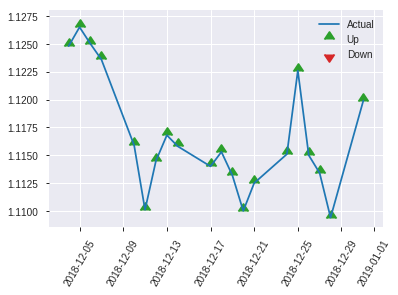


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24938647538422912
RMSE: 0.4993860985091887
LogLoss: 0.6933661893591657
Mean Per-Class Error: 0.3833088954056696
AUC: 0.6245112414467253
pr_auc: 0.5877417778051242
Gini: 0.24902248289345064
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3649595379829407: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      11   121  0.9167   (121.0/132.0)
1      1    123  0.0081   (1.0/124.0)
Total  12   244  0.4766   (122.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.36496      0.668478  243
max f2                       0.36496      0.831081  243
max f0point5                 0.576938     0.604839  154
max accuracy                 0.576938     0.613281  154
max precision                0.883556     1         0
max recall                   0.306        1         252
max specificity              0.883556     1         0
max absolute_mcc             0.576938     0.238638  154
max min_per_class_accuracy   0.60651      0.58871   125
max mean_per_class_accuracy  0.576938     0.616691  154

Gains/Lift Table: Avg response rate: 48.44 %, avg score: 59.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.807899           1.37634   1.37634            0.666667         0.835883  0.666667                    0.835883            0.016129        0.016129                   37.6344   37.6344
    2        0.0234375                   0.786956           2.06452   1.72043            1                0.795137  0.833333                    0.81551             0.0241935       0.0403226                  106.452   72.043
    3        0.03125                     0.771344           2.06452   1.80645            1                0.77296   0.875                       0.804872            0.016129        0.0564516                  106.452   80.6452
    4        0.0429688                   0.77087            0.688172  1.50147            0.333333         0.771111  0.727273                    0.795665            0.00806452      0.0645161                  -31.1828  50.1466
    5        0.0507812                   0.764951           2.06452   1.58809            1                0.768165  0.769231                    0.791434            0.016129        0.0806452                  106.452   58.8089
    6        0.101562                    0.748515           0.952854  1.27047            0.461538         0.757059  0.615385                    0.774246            0.0483871       0.129032                   -4.71464  27.0471
    7        0.152344                    0.7303             1.27047   1.27047            0.615385         0.740179  0.615385                    0.762891            0.0645161       0.193548                   27.0471   27.0471
    8        0.203125                    0.707252           0.794045  1.15136            0.384615         0.718964  0.557692                    0.751909            0.0403226       0.233871                   -20.5955  15.1365
    9        0.300781                    0.675707           1.32129   1.20654            0.64             0.690092  0.584416                    0.731838            0.129032        0.362903                   32.129    20.6535
    10       0.402344                    0.624329           1.19107   1.20263            0.576923         0.646844  0.582524                    0.710384            0.120968        0.483871                   19.1067   20.2631
    11       0.5                         0.604432           1.07355   1.17742            0.52             0.613766  0.570312                    0.691513            0.104839        0.58871                    7.35484   17.7419
    12       0.601562                    0.577708           1.27047   1.19313            0.615385         0.591305  0.577922                    0.674595            0.129032        0.717742                   27.0471   19.3129
    13       0.699219                    0.54086            0.743226  1.13029            0.36             0.559385  0.547486                    0.658504            0.0725806       0.790323                   -25.6774  13.0294
    14       0.800781                    0.50338            0.873449  1.09772            0.423077         0.522996  0.531707                    0.641318            0.0887097       0.879032                   -12.6551  9.77183
    15       0.898438                    0.428689           0.660645  1.05021            0.32             0.46579   0.508696                    0.622239            0.0645161       0.943548                   -33.9355  5.02104
    16       1                           0.204391           0.555831  1                  0.269231         0.359332  0.484375                    0.595537          

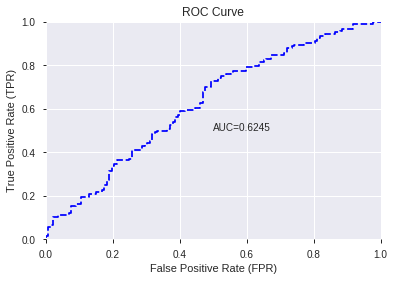

This function is available for GLM models only


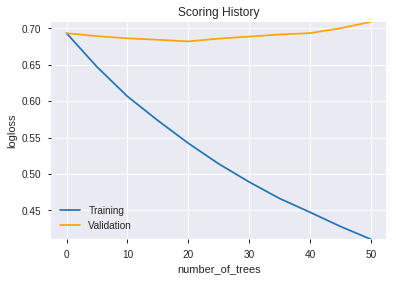

--2019-08-22 15:58:28--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.165.251
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.165.251|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_155723_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_155723_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_a064',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_155837_model_5  0.582478  0.685475              0.489125  0.496057  0.246072
1  DeepLearning_grid_1_AutoML_20190822_155837_model_8  0.577041  0.697834              0.481305  0.502221  0.252226
2  DeepLearning_grid_1_AutoML_20190822_155837_model_9  0.576124  0.680421              0.462366  0.493969  0.244005
3  DeepLearning_grid_1_AutoML_20190822_155837_model_6  0.572031  0.697766              0.481305  0.501034  0.251035
4  DeepLearning_grid_1_AutoML_20190822_155837_model_3  0.569770  0.832905              0.496212  0.522945  0.273472
5  DeepLearning_grid_1_AutoML_20190822_155837_model_2  0.568793  0.808577              0.467620  0.529658  0.280537
6  DeepLearning_grid_1_AutoML_20190822_155837_model_7  0.561645  0.826108              0.500000  0.527478  0.278233
7  DeepLearning_grid_1_AutoML_20190822_155837_model_4  0.552969  0.846965              0.474707  0.541012  0.292694
8               DeepLearning_1_AutoML_20190822_155837  0.551442  0.811598              0.500000  0.518516  0.268859
9  DeepLearning_grid_1_AutoML_20190822_155837_model_1  0.549609  1.010738              0.477761  0.558192  0.311578

variable  relative_importance  scaled_importance  percentage
0                   BOP             1.000000           1.000000    0.024181
1             CDLONNECK             0.921939           0.921939    0.022294
2             CORREL_12             0.920926           0.920926    0.022269
3               CDLDOJI             0.915892           0.915892    0.022147
4       CDLADVANCEBLOCK             0.914102           0.914102    0.022104
5          STOCHF_fastk             0.913149           0.913149    0.022081
6             CORREL_14             0.900022           0.900022    0.021764
7      CDLABANDONEDBABY             0.896278           0.896278    0.021673
8             CORREL_30             0.881299           0.881299    0.021311
9     CDLLONGLEGGEDDOJI             0.877745           0.877745    0.021225
10   CDLSEPARATINGLINES             0.874731           0.874731    0.021152
11                  DIV             0.869934           0.869934    0.021036
12         CDLBREAKAWAY             0.862268           0.862268    0.020851
13            CORREL_24             0.861504           0.861504    0.020832
14   CDLMORNINGDOJISTAR             0.852113           0.852113    0.020605
15        days_in_month             0.850012           0.850012    0.020554
16  CDLXSIDEGAP3METHODS             0.847890           0.847890    0.020503
17           MINUS_DI_8             0.831578           0.831578    0.020109
18       CDLMORNINGSTAR             0.830919           0.830919    0.020093
19         CDLTHRUSTING             0.829505           0.829505    0.020059
20               SAREXT             0.828764           0.828764    0.020041
21                  SUB             0.828466           0.828466    0.020033
22                  day             0.827387           0.827387    0.020007
23   CDLEVENINGDOJISTAR             0.827205           0.827205    0.020003
24          aroondown_8             0.824091           0.824091    0.019928
25       CDLRICKSHAWMAN             0.819028           0.819028    0.019805
26    CDLGRAVESTONEDOJI             0.815656           0.815656    0.019724
27            CDLHAMMER             0.813025           0.813025    0.019660
28       CDLHARAMICROSS             0.811261           0.811261    0.019617
29            CORREL_20             0.808065           0.808065    0.019540
30       CDLEVENINGSTAR             0.807180           0.807180    0.019519
31       is_month_start             0.805919           0.805919    0.019488
32             CORREL_8             0.800691           0.800691    0.019362
33      CDLSHOOTINGSTAR             0.799682           0.799682    0.019337
34        CDLHANGINGMAN             0.792385           0.792385    0.019161
35    CDLINVERTEDHAMMER             0.790245           0.790245    0.019109
36     CDLCOUNTERATTACK             0.788573           0.788573    0.019069
37            dayofweek             0.788513           0.788513    0.019067
38       is_quarter_end             0.786062           0.786062    0.019008
39           CDL3INSIDE             0.784752           0.784752    0.018976
40     is_quarter_start             0.781775           0.781775    0.018904
41       CDLMATCHINGLOW             0.777515           0.777515    0.018801
42            CDLTAKURI             0.776533           0.776533    0.018778
43         weekday_name             0.771756           0.771756    0.018662
44         HT_TRENDMODE             0.771388           0.771388    0.018653
45         is_month_end             0.770231           0.770231    0.018625
46              weekday             0.764089           0.764089    0.018477
47     CDLDRAGONFLYDOJI             0.757512           0.757512    0.018318
48     CDLSTICKSANDWICH             0.725579           0.725579    0.017545
49        CDLHIKKAKEMOD             0.659072           0.659072    0.015937

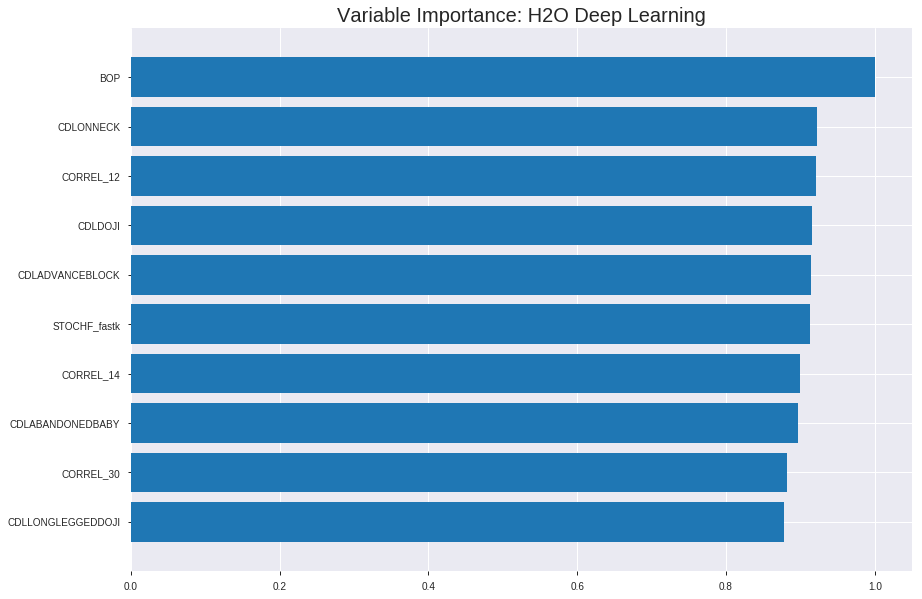

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_155837_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24134481711003755
RMSE: 0.49126857940442065
LogLoss: 0.6754306302350707
Mean Per-Class Error: 0.41787659994668414
AUC: 0.6051011813354259
pr_auc: 0.6079353041188607
Gini: 0.2102023626708518
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28987262101778133: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      28   851   0.9681   (851.0/879.0)
1      6    903   0.0066   (6.0/909.0)
Total  34   1754  0.4793   (857.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.289873     0.678183  376
max f2                       0.265429     0.839497  386
max f0point5                 0.418693     0.587478  279
max accuracy                 0.539962     0.5783    142
max precision                0.802665     1         0
max recall                   0.239441     1         393
max specificity              0.802665     1         0
max absolute_mcc             0.539962     0.18421   142
max min_per_class_accuracy   0.471236     0.561056  215
max mean_per_class_accuracy  0.539962     0.582123  142

Gains/Lift Table: Avg response rate: 50.84 %, avg score: 48.33 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.71752            1.52989   1.52989            0.777778         0.755786  0.777778                    0.755786            0.0154015       0.0154015                  52.9886   52.9886
    2        0.0201342                   0.697346           1.09278   1.31133            0.555556         0.707865  0.666667                    0.731826            0.0110011       0.0264026                  9.27759   31.1331
    3        0.0302013                   0.680059           1.20205   1.27491            0.611111         0.687779  0.648148                    0.717143            0.0121012       0.0385039                  20.2054   27.4905
    4        0.0402685                   0.669197           1.74844   1.39329            0.888889         0.674628  0.708333                    0.706514            0.0176018       0.0561056                  74.8442   39.3289
    5        0.0503356                   0.659115           1.31133   1.3769             0.666667         0.664     0.7                         0.698012            0.0132013       0.0693069                  31.1331   37.6898
    6        0.100112                    0.622829           1.37027   1.3736             0.696629         0.638565  0.698324                    0.668455            0.0682068       0.137514                   37.0267   37.3601
    7        0.150447                    0.59157            1.31133   1.35277            0.666667         0.607028  0.687732                    0.647903            0.0660066       0.20352                    31.1331   35.2767
    8        0.200224                    0.569211           1.21556   1.31866            0.617978         0.57985   0.670391                    0.630985            0.0605061       0.264026                   21.556    31.8657
    9        0.300336                    0.526781           1.14284   1.26005            0.581006         0.548585  0.640596                    0.603518            0.114411        0.378438                   14.2836   26.005
    10       0.399888                    0.496648           0.983498  1.1912             0.5              0.511652  0.605594                    0.580648            0.0979098       0.476348                   -1.65017  19.1202
    11       0.5                         0.470938           0.835149  1.11991            0.424581         0.482607  0.569351                    0.561018            0.0836084       0.559956                   -16.4851  11.9912
    12       0.600112                    0.448639           1.04394   1.10724            0.530726         0.458299  0.562908                    0.543882            0.10451         0.664466                   4.39368   10.7238
    13       0.699664                    0.427982           0.884043  1.07548            0.449438         0.439337  0.546763                    0.529007            0.0880088       0.752475                   -11.5957  7.54802
    14       0.799776                    0.400193           0.92306   1.0564             0.469274         0.415242  0.537063                    0.514766            0.0924092       0.844884                   -7.69401  5.6401
    15       0.899888                    0.370143           0.890093  1.0379             0.452514         0.385875  0.527657                    0.500427            0.0891089       0.933993                   -10.9907  3.78994
    16       1                           0.207873           0.659329  1                  0.335196         0.329485  0.508389                    0.483314           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2501004666613185
RMSE: 0.5001004565697961
LogLoss: 0.6940338950875025
Mean Per-Class Error: 0.4369722650231125
AUC: 0.5491679506933744
pr_auc: 0.49019825435349745
Gini: 0.09833590138674886
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34407125579655756: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      11   264  0.96     (264.0/275.0)
1      4    232  0.0169   (4.0/236.0)
Total  15   496  0.5245   (268.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.344071     0.63388   384
max f2                       0.227317     0.810997  399
max f0point5                 0.461024     0.527695  218
max accuracy                 0.483868     0.567515  179
max precision                0.577785     0.545455  58
max recall                   0.227317     1         399
max specificity              0.766811     0.996364  0
max absolute_mcc             0.483868     0.126717  179
max min_per_class_accuracy   0.466532     0.534545  205
max mean_per_class_accuracy  0.483868     0.563028  179

Gains/Lift Table: Avg response rate: 46.18 %, avg score: 47.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.696167           0.721751  0.721751           0.333333         0.729751  0.333333                    0.729751            0.00847458      0.00847458                 -27.8249  -27.8249
    2        0.0215264                   0.667147           0.866102  0.787365           0.4              0.680777  0.363636                    0.70749             0.00847458      0.0169492                  -13.3898  -21.2635
    3        0.0313112                   0.646223           1.29915   0.947299           0.6              0.651655  0.4375                      0.690041            0.0127119       0.029661                   29.9153   -5.27013
    4        0.0410959                   0.633527           0.866102  0.927966           0.4              0.639977  0.428571                    0.678121            0.00847458      0.0381356                  -13.3898  -7.20339
    5        0.0508806                   0.621895           0.866102  0.916069           0.4              0.626304  0.423077                    0.668157            0.00847458      0.0466102                  -13.3898  -8.39309
    6        0.101761                    0.585958           1.24919   1.08263            0.576923         0.602809  0.5                         0.635483            0.0635593       0.110169                   24.9185   8.26271
    7        0.150685                    0.572609           1.12593   1.09669            0.52             0.57822   0.506494                    0.616891            0.0550847       0.165254                   12.5932   9.66872
    8        0.201566                    0.563244           1.16591   1.11416            0.538462         0.56781   0.514563                    0.604501            0.059322        0.224576                   16.5906   11.416
    9        0.30137                     0.522384           1.10386   1.11075            0.509804         0.54192   0.512987                    0.583776            0.110169        0.334746                   10.3855   11.0747
    10       0.401174                    0.492389           1.14631   1.11959            0.529412         0.505279  0.517073                    0.564248            0.114407        0.449153                   14.6311   11.9595
    11       0.500978                    0.46646            0.934031  1.08263            0.431373         0.479009  0.5                         0.547267            0.0932203       0.542373                   -6.59688  8.26271
    12       0.600783                    0.443926           0.976487  1.06499            0.45098          0.456448  0.491857                    0.53218             0.0974576       0.639831                   -2.35128  6.49948
    13       0.700587                    0.42273            0.976487  1.05239            0.45098          0.433788  0.486034                    0.518163            0.0974576       0.737288                   -2.35128  5.23861
    14       0.800391                    0.402435           0.806663  1.02175            0.372549         0.412964  0.471883                    0.505045            0.0805085       0.817797                   -19.3337  2.17459
    15       0.900196                    0.374332           0.934031  1.01202            0.431373         0.387702  0.467391                    0.492035            0.0932203       0.911017                   -6.59688  1.2021
    16       1                           0.227317           0.891575  1                  0.411765         0.340268  0.46184                     0.476888      


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 16:02:09  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 16:02:10  1 min 13.618 sec  1130 obs/sec      1         1             1788       0.491269         0.675431            0.0343489      0.605101        0.607935           1.52989          0.479306                         0.5001             0.694034              -0.00626324      0.549168          0.490198             0.721751           0.524462
    2019-08-22 16:02:16  1 min 19.520 sec  2060 obs/sec      8         8             14304      0.468859         0.628091            0.120437       0.703123        0.701254           1.967            0.368568                         0.510834           0.722902              -0.0499208       0.531109          0.479974             0.721751           0.524462
    2019-08-22 16:02:22  1 min 25.202 sec  2369 obs/sec      16        16            28608      0.450179         0.588237            0.189126       0.767827        0.76464            1.967            0.322148                         0.505744           0.712715              -0.0291044       0.560116          0.502192             1.4435             0.524462
    2019-08-22 16:02:28  1 min 31.096 sec  2568 obs/sec      25        25            44700      0.441059         0.568248            0.221649       0.780273        0.779271           1.967            0.294743                         0.508923           0.723127              -0.0420799       0.557542          0.501052             1.4435             0.524462
    2019-08-22 16:02:34  1 min 36.833 sec  2689 obs/sec      34        34            60792      0.42345          0.529661            0.282557       0.818136        0.81979            1.967            0.275168                         0.517129           0.758439              -0.075958        0.545593          0.504081             1.4435             0.534247
    2019-08-22 16:02:39  1 min 42.562 sec  2767 obs/sec      43        43            76884      0.40975          0.499615            0.32823        0.851227        0.850269           1.967            0.255034                         0.52773            0.805453              -0.120523        0.538513          0.497631             1.4435             0.51272
    2019-08-22 16:02:40  1 min 43.139 sec  2765 obs/sec      43        43            76884      0.491269         0.675431            0.0343489      0.605101        0.607935           1.52989          0.479306                         0.5001             0.694034              -0.00626324      0.549168          0.490198             0.721751           0.524462

Variable Importances: 


variable          relative_importance    scaled_importance    percentage
----------------  ---------------------  -------------------  --------------------
BOP               1.0                    1.0                  0.02418133722171494
CDLONNECK         0.921939492225647      0.921939492225647    0.022293729759525007
CORREL_12         0.9209255576133728     0.9209255576133728   0.022269211464744837
CDLDOJI           0.9158920645713806     0.9158920645713806   0.02214749487209327
CDLADVANCEBLOCK   0.91410231590271       0.91410231590271     0.02210421635599403
---               ---                    ---                  ---
is_month_end      0.7702314257621765     0.7702314257621765   0.018625225845117485
weekday           0.7640891671180725     0.7640891671180725   0.018476697817541413
CDLDRAGONFLYDOJI  0.7575118541717529     0.7575118541717529   0.018317649595173707
CDLSTICKSANDWICH  0.7255787253379822     0.7255787253379822   0.01754546383829983
CDLHIKKAKEMOD     0.6590715050697327     0.6590715050697327   0.015937230317314414


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5859375)

('F1', 0.6541554959785524)

('auc', 0.5824780058651027)

('logloss', 0.6854747699289483)

('mean_per_class_error', 0.41373411534701854)

('rmse', 0.49605666876921867)

('mse', 0.24607221863041434)

deeplearning prediction progress: |███████████████████████████████████████| 100%


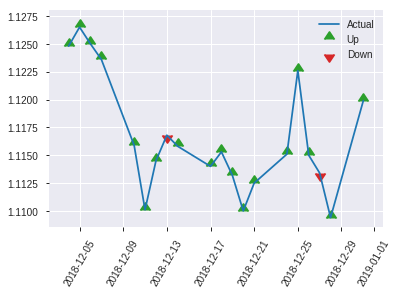


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.24607221863041434
RMSE: 0.49605666876921867
LogLoss: 0.6854747699289483
Mean Per-Class Error: 0.41373411534701854
AUC: 0.5824780058651027
pr_auc: 0.5484595614997212
Gini: 0.16495601173020535
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30945758722421207: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    127  0.9621   (127.0/132.0)
1      2    122  0.0161   (2.0/124.0)
Total  7    249  0.5039   (129.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.309458     0.654155  248
max f2                       0.258312     0.824468  255
max f0point5                 0.449081     0.574534  129
max accuracy                 0.449529     0.585938  127
max precision                0.598776     0.714286  13
max recall                   0.258312     1         255
max specificity              0.702317     0.992424  0
max absolute_mcc             0.449081     0.172469  129
max min_per_class_accuracy   0.449529     0.583333  127
max mean_per_class_accuracy  0.449081     0.586266  129

Gains/Lift Table: Avg response rate: 48.44 %, avg score: 45.44 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117188                   0.672721           1.37634   1.37634            0.666667         0.69524   0.666667                    0.69524             0.016129        0.016129                   37.6344    37.6344
    2        0.0234375                   0.63641            0.688172  1.03226            0.333333         0.648811  0.5                         0.672025            0.00806452      0.0241935                  -31.1828   3.22581
    3        0.03125                     0.615147           1.03226   1.03226            0.5              0.624395  0.5                         0.660118            0.00806452      0.0322581                  3.22581    3.22581
    4        0.0429688                   0.606941           2.06452   1.31378            1                0.609219  0.636364                    0.646236            0.0241935       0.0564516                  106.452    31.3783
    5        0.0507812                   0.59994            2.06452   1.42928            1                0.604512  0.692308                    0.639817            0.016129        0.0725806                  106.452    42.928
    6        0.101562                    0.558689           1.42928   1.42928            0.692308         0.580625  0.692308                    0.610221            0.0725806       0.145161                   42.928     42.928
    7        0.152344                    0.532239           0.794045  1.21754            0.384615         0.544744  0.589744                    0.588395            0.0403226       0.185484                   -20.5955   21.7535
    8        0.203125                    0.512311           0.794045  1.11166            0.384615         0.522761  0.538462                    0.571987            0.0403226       0.225806                   -20.5955   11.1663
    9        0.300781                    0.492578           0.990968  1.07248            0.48             0.503381  0.519481                    0.549712            0.0967742       0.322581                   -0.903226  7.24759
    10       0.402344                    0.467339           1.27047   1.12246            0.615385         0.480886  0.543689                    0.532339            0.129032        0.451613                   27.0471    12.2455
    11       0.5                         0.449425           1.40387   1.17742            0.68             0.459883  0.570312                    0.518187            0.137097        0.58871                    40.3871    17.7419
    12       0.601562                    0.430929           0.794045  1.11269            0.384615         0.440006  0.538961                    0.504988            0.0806452       0.669355                   -20.5955   11.2694
    13       0.699219                    0.410235           0.990968  1.09569            0.48             0.422671  0.530726                    0.493491            0.0967742       0.766129                   -0.903226  9.56929
    14       0.800781                    0.382714           0.71464   1.04736            0.346154         0.399426  0.507317                    0.481561            0.0725806       0.83871                    -28.536    4.73643
    15       0.898438                    0.354959           0.825806  1.02328            0.4              0.370456  0.495652                    0.469484            0.0806452       0.919355                   -17.4194   2.32819
    16       1                           0.258312           0.794045  1                  0.384615         0.320471  0.484375                    0.

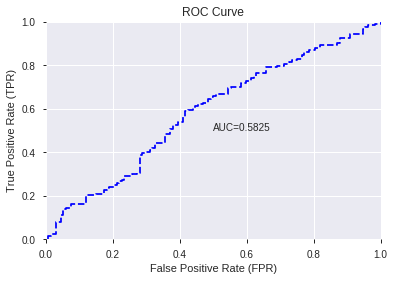

This function is available for GLM models only


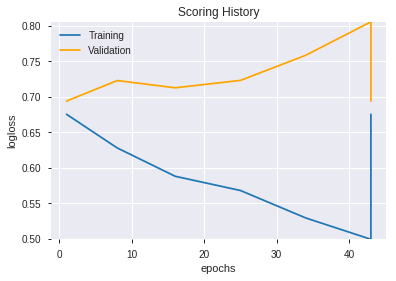

--2019-08-22 16:06:44--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.94.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.94.179|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_155837_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_155837_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_a064',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLONNECK',
 'CORREL_12',
 'CDLDOJI',
 'CDLADVANCEBLOCK',
 'STOCHF_fastk',
 'CORREL_14',
 'CDLABANDONEDBABY',
 'CORREL_30',
 'CDLLONGLEGGEDDOJI',
 'CDLSEPARATINGLINES',
 'DIV',
 'CDLBREAKAWAY',
 'CORREL_24',
 'CDLMORNINGDOJISTAR',
 'days_in_month',
 'CDLXSIDEGAP3METHODS',
 'MINUS_DI_8',
 'CDLMORNINGSTAR',
 'CDLTHRUSTING',
 'SAREXT',
 'SUB',
 'day',
 'CDLEVENINGDOJISTAR',
 'aroondown_8',
 'CDLRICKSHAWMAN',
 'CDLGRAVESTONEDOJI',
 'CDLHAMMER',
 'CDLHARAMICROSS',
 'CORREL_20',
 'CDLEVENINGSTAR',
 'is_month_start',
 'CORREL_8',
 'CDLSHOOTINGSTAR',
 'CDLHANGINGMAN',
 'CDLINVERTEDHAMMER',
 'CDLCOUNTERATTACK',
 'dayofweek',
 'is_quarter_end',
 'CDL3INSIDE',
 'is_quarter_start',
 'CDLMATCHINGLOW',
 'CDLTAKURI',
 'weekday_name',
 'HT_TRENDMODE',
 'is_month_end',
 'weekday',
 'CDLDRAGONFLYDOJI',
 'CDLSTICKSANDWICH',
 'CDLHIKKAKEMOD']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_160652_model_1  0.593597  0.690173                   0.5  0.498321  0.248324

variable  relative_importance  scaled_importance  percentage
0                   BOP             0.155333           1.000000    0.116507
1            MINUS_DI_8             0.087637           0.564190    0.065732
2     CDLGRAVESTONEDOJI             0.078142           0.503063    0.058611
3      CDLDRAGONFLYDOJI             0.076210           0.490622    0.057161
4             CDLTAKURI             0.070270           0.452386    0.052706
5                   SUB             0.061706           0.397248    0.046282
6        CDLRICKSHAWMAN             0.049840           0.320860    0.037383
7                   DIV             0.048115           0.309756    0.036089
8             CORREL_14             0.047812           0.307803    0.035861
9          STOCHF_fastk             0.036310           0.233756    0.027234
10   CDLMORNINGDOJISTAR             0.034692           0.223341    0.026021
11    CDLINVERTEDHAMMER             0.033571           0.216121    0.025180
12         weekday_name             0.032857           0.211526    0.024644
13   CDLEVENINGDOJISTAR             0.031609           0.203492    0.023708
14            CDLHAMMER             0.028754           0.185114    0.021567
15         CDLTHRUSTING             0.025053           0.161288    0.018791
16     CDLABANDONEDBABY             0.024987           0.160861    0.018741
17  CDLXSIDEGAP3METHODS             0.024216           0.155894    0.018163
18              CDLDOJI             0.023790           0.153155    0.017844
19         CDLBREAKAWAY             0.023544           0.151574    0.017660
20            CORREL_20             0.021921           0.141120    0.016442
21        days_in_month             0.021784           0.140241    0.016339
22        CDLHIKKAKEMOD             0.021467           0.138200    0.016101
23       CDLMORNINGSTAR             0.020051           0.129086    0.015040
24      CDLADVANCEBLOCK             0.019321           0.124384    0.014492
25            CORREL_24             0.018971           0.122130    0.014229
26              weekday             0.018506           0.119137    0.013880
27            dayofweek             0.018501           0.119105    0.013877
28         HT_TRENDMODE             0.018475           0.118940    0.013857
29    CDLLONGLEGGEDDOJI             0.017437           0.112253    0.013078
30            CDLONNECK             0.016494           0.106183    0.012371
31   CDLSEPARATINGLINES             0.015160           0.097597    0.011371
32            CORREL_30             0.013178           0.084837    0.009884
33            CORREL_12             0.012667           0.081550    0.009501
34                  day             0.012136           0.078127    0.009102
35       CDLHARAMICROSS             0.011756           0.075682    0.008817
36     CDLSTICKSANDWICH             0.011261           0.072498    0.008447
37         is_month_end             0.010376           0.066799    0.007783
38       is_quarter_end             0.006963           0.044825    0.005222
39          aroondown_8             0.005907           0.038025    0.004430
40               SAREXT             0.005426           0.034930    0.004070
41      CDLSHOOTINGSTAR             0.004515           0.029064    0.003386
42     CDLCOUNTERATTACK             0.004362           0.028083    0.003272
43       CDLMATCHINGLOW             0.003913           0.025189    0.002935
44        CDLHANGINGMAN             0.003020           0.019441    0.002265
45       is_month_start             0.002377           0.015301    0.001783
46       CDLEVENINGSTAR             0.001344           0.008653    0.001008
47     is_quarter_start             0.001054           0.006783    0.000790
48           CDL3INSIDE             0.000324           0.002087    0.000243
49             CORREL_8             0.000130           0.000839    0.000098

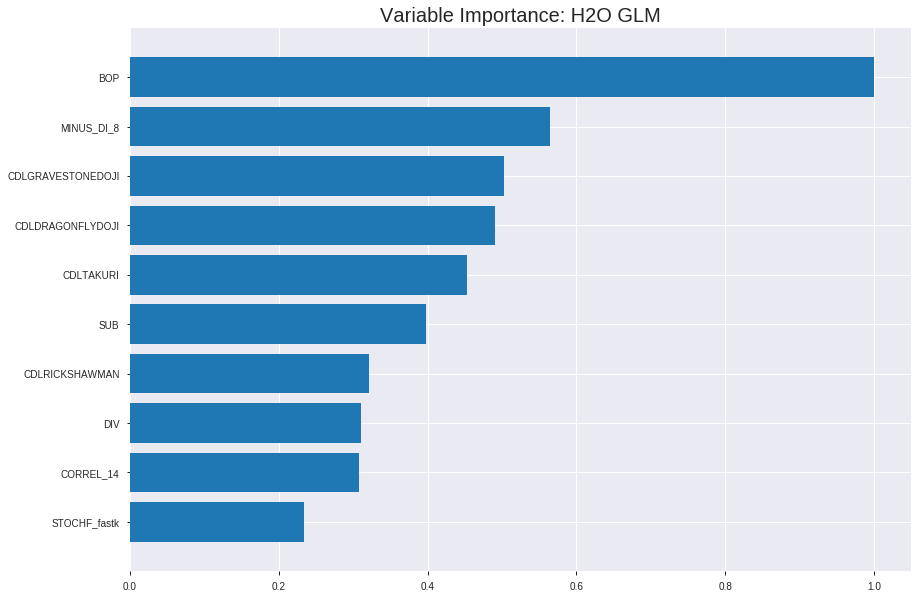

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_160652_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.23293017239929362
RMSE: 0.48262839990959255
LogLoss: 0.6580998708816247
Null degrees of freedom: 1787
Residual degrees of freedom: 1737
Null deviance: 2478.190938357651
Residual deviance: 2353.36513827269
AIC: 2455.36513827269
AUC: 0.658510959173278
pr_auc: 0.6557878115411161
Gini: 0.3170219183465559
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4517719070256971: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      271  608   0.6917   (608.0/879.0)
1      98   811   0.1078   (98.0/909.0)
Total  369  1419  0.3949   (706.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.451772     0.696735  272
max f2                       0.336453     0.841078  368
max f0point5                 0.506096     0.624874  198
max accuracy                 0.506096     0.618568  198
max precision                0.802697     1         0
max recall                   0.283382     1         388
max specificity              0.802697     1         0
max absolute_mcc             0.451772     0.24767   272
max min_per_class_accuracy   0.516118     0.600683  183
max mean_per_class_accuracy  0.506096     0.617503  198

Gains/Lift Table: Avg response rate: 50.84 %, avg score: 50.84 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.680572           1.85772   1.85772            0.944444         0.709634  0.944444                    0.709634            0.0187019       0.0187019                  85.7719   85.7719
    2        0.0201342                   0.660137           1.63916   1.74844            0.833333         0.667413  0.888889                    0.688523            0.0165017       0.0352035                  63.9164   74.8442
    3        0.0302013                   0.642628           1.63916   1.71202            0.833333         0.64831   0.87037                     0.675119            0.0165017       0.0517052                  63.9164   71.2016
    4        0.0402685                   0.633301           1.20205   1.58453            0.611111         0.638     0.805556                    0.665839            0.0121012       0.0638064                  20.2054   58.4525
    5        0.0503356                   0.625737           1.42061   1.55174            0.722222         0.629825  0.788889                    0.658637            0.0143014       0.0781078                  42.0609   55.1742
    6        0.100112                    0.601724           1.43657   1.49448            0.730337         0.612353  0.759777                    0.635624            0.0715072       0.149615                   43.6571   49.4478
    7        0.150447                    0.584419           1.33319   1.44051            0.677778         0.592224  0.732342                    0.621103            0.0671067       0.216722                   33.3187   44.0514
    8        0.200224                    0.569534           1.23766   1.39008            0.629213         0.576614  0.706704                    0.610043            0.0616062       0.278328                   23.7661   39.0084
    9        0.300336                    0.549526           0.988993  1.25639            0.502793         0.560015  0.638734                    0.593367            0.0990099       0.377338                   -1.10072  25.6387
    10       0.399888                    0.532623           1.16031   1.23247            0.589888         0.540545  0.626573                    0.580217            0.115512        0.492849                   16.0307   23.2468
    11       0.5                         0.516311           1.0769    1.20132            0.547486         0.524605  0.610738                    0.569082            0.107811        0.60066                    7.69032   20.132
    12       0.600112                    0.501007           1.13185   1.18973            0.575419         0.508704  0.604846                    0.55901             0.113311        0.713971                   13.1847   18.9731
    13       0.699664                    0.479368           0.928246  1.15252            0.47191          0.490507  0.585931                    0.549263            0.0924092       0.806381                   -7.17544  15.2525
    14       0.799776                    0.448585           0.890093  1.11968            0.452514         0.465064  0.569231                    0.538723            0.0891089       0.89549                    -10.9907  11.9675
    15       0.899888                    0.392968           0.637351  1.06602            0.324022         0.422325  0.541952                    0.525774            0.0638064       0.959296                   -36.2649  6.60169
    16       1                           0.190246           0.406586  1                  0.206704         0.352122  0.508389                    0.508389          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24520838998813593
RMSE: 0.4951852077638587
LogLoss: 0.6830781090430589
Null degrees of freedom: 510
Residual degrees of freedom: 460
Null deviance: 709.8491425809777
Residual deviance: 698.1058274420062
AIC: 800.1058274420062
AUC: 0.5702465331278891
pr_auc: 0.5005546580574951
Gini: 0.14049306625577818
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35315146205176434: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      30   245  0.8909   (245.0/275.0)
1      6    230  0.0254   (6.0/236.0)
Total  36   475  0.4912   (251.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.353151     0.646976  366
max f2                       0.322191     0.81484   386
max f0point5                 0.474795     0.545866  244
max accuracy                 0.51206      0.563601  169
max precision                0.723082     1         0
max recall                   0.240428     1         396
max specificity              0.723082     1         0
max absolute_mcc             0.353151     0.162997  366
max min_per_class_accuracy   0.503307     0.550847  188
max mean_per_class_accuracy  0.477436     0.569576  237

Gains/Lift Table: Avg response rate: 46.18 %, avg score: 48.84 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.638242           1.08263   1.08263            0.5              0.662992  0.5                         0.662992            0.0127119       0.0127119                  8.26271   8.26271
    2        0.0215264                   0.627583           0.866102  0.984206           0.4              0.632059  0.454545                    0.648932            0.00847458      0.0211864                  -13.3898  -1.57935
    3        0.0313112                   0.617437           1.29915   1.08263            0.6              0.622066  0.5                         0.640536            0.0127119       0.0338983                  29.9153   8.26271
    4        0.0410959                   0.610694           1.29915   1.13418            0.6              0.613111  0.52381                     0.634006            0.0127119       0.0466102                  29.9153   13.4181
    5        0.0508806                   0.607188           0.866102  1.08263            0.4              0.608502  0.5                         0.629101            0.00847458      0.0550847                  -13.3898  8.26271
    6        0.101761                    0.572623           1.08263   1.08263            0.5              0.587081  0.5                         0.608091            0.0550847       0.110169                   8.26271   8.26271
    7        0.150685                    0.558378           1.12593   1.09669            0.52             0.565821  0.506494                    0.594367            0.0550847       0.165254                   12.5932   9.66872
    8        0.201566                    0.547376           1.16591   1.11416            0.538462         0.552991  0.514563                    0.583923            0.059322        0.224576                   16.5906   11.416
    9        0.30137                     0.529388           1.10386   1.11075            0.509804         0.53789   0.512987                    0.568678            0.110169        0.334746                   10.3855   11.0747
    10       0.401174                    0.517116           1.18877   1.13016            0.54902          0.522182  0.521951                    0.557111            0.118644        0.45339                    18.8767   13.0157
    11       0.500978                    0.502078           0.976487  1.09954            0.45098          0.509799  0.507812                    0.547685            0.0974576       0.550847                   -2.35128  9.95432
    12       0.600783                    0.483033           1.14631   1.10731            0.529412         0.492093  0.511401                    0.53845             0.114407        0.665254                   14.6311   10.7312
    13       0.700587                    0.460906           1.01894   1.09472            0.470588         0.472008  0.505587                    0.528985            0.101695        0.766949                   1.89432   9.47235
    14       0.800391                    0.433812           0.721751  1.04822            0.333333         0.44848   0.484108                    0.518946            0.0720339       0.838983                   -27.8249  4.8216
    15       0.900196                    0.372238           0.934031  1.03556            0.431373         0.404702  0.478261                    0.50628             0.0932203       0.932203                   -6.59688  3.55564
    16       1                           0.106221           0.679295  1                  0.313725         0.326869  0.46184                     0.488374          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-22 16:06:53  0.000 sec   2            8.3       51            1.37838           1.3846
    2019-08-22 16:06:53  0.030 sec   4            5.2       51            1.37432           1.38233
    2019-08-22 16:06:53  0.059 sec   6            3.2       51            1.36852           1.3793
    2019-08-22 16:06:53  0.078 sec   8            2         51            1.36072           1.37563
    2019-08-22 16:06:53  0.100 sec   10           1.2       51            1.35096           1.37177
    2019-08-22 16:06:53  0.119 sec   12           0.77      51            1.3397            1.36845
    2019-08-22 16:06:53  0.140 sec   14           0.48      51            1.3278            1.36645
    2019-08-22 16:06:53  0.160 sec   16           0.3       51            1.3162            1.36616
    2019-08-22 16:06:53  0.178 sec   18           0.18      51            1.30573           1.36749
    2019-08-22 16:06:53  0.203 sec   20           0.11      51            1.29697           1.37011
    2019-08-22 16:06:53  0.221 sec   22           0.071     51            1.2902            1.37362
    2019-08-22 16:06:53  0.239 sec   24           0.044     51            1.2854            1.3777
    2019-08-22 16:06:53  0.256 sec   26           0.027     51            1.28226           1.382

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.609375)

('F1', 0.6526315789473685)

('auc', 0.5935972629521017)

('logloss', 0.6901729263353853)

('mean_per_class_error', 0.3912512218963832)

('rmse', 0.49832147051139336)

('mse', 0.2483242879726375)

glm prediction progress: |████████████████████████████████████████████████| 100%


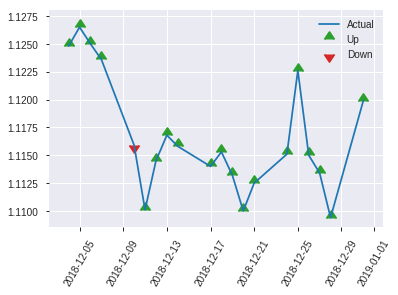


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2483242879726375
RMSE: 0.49832147051139336
LogLoss: 0.6901729263353853
Null degrees of freedom: 255
Residual degrees of freedom: 205
Null deviance: 355.23191699062966
Residual deviance: 353.36853828371727
AIC: 455.36853828371727
AUC: 0.5935972629521017
pr_auc: 0.5516509459906253
Gini: 0.18719452590420338
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29373935098248494: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    132  1        (132.0/132.0)
1      0    124  0        (0.0/124.0)
Total  0    256  0.5156   (132.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.293739     0.652632  255
max f2                       0.293739     0.824468  255
max f0point5                 0.540042     0.596405  121
max accuracy                 0.541116     0.609375  119
max precision                0.673058     0.714286  6
max recall                   0.293739     1         255
max specificity              0.75308      0.992424  0
max absolute_mcc             0.540042     0.217631  121
max min_per_class_accuracy   0.537851     0.604839  126
max mean_per_class_accuracy  0.540042     0.608749  121

Gains/Lift Table: Avg response rate: 48.44 %, avg score: 52.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.707986           1.37634   1.37634            0.666667         0.728459  0.666667                    0.728459            0.016129        0.016129                   37.6344   37.6344
    2        0.0234375                   0.67796            1.37634   1.37634            0.666667         0.691698  0.666667                    0.710079            0.016129        0.0322581                  37.6344   37.6344
    3        0.03125                     0.665801           1.03226   1.29032            0.5              0.671122  0.625                       0.70034             0.00806452      0.0403226                  3.22581   29.0323
    4        0.0429688                   0.648048           0.688172  1.1261             0.333333         0.656166  0.545455                    0.688292            0.00806452      0.0483871                  -31.1828  12.61
    5        0.0507812                   0.631081           1.03226   1.11166            0.5              0.639329  0.538462                    0.680759            0.00806452      0.0564516                  3.22581   11.1663
    6        0.101562                    0.60137            0.635236  0.873449           0.307692         0.614163  0.423077                    0.647461            0.0322581       0.0887097                  -36.4764  -12.6551
    7        0.152344                    0.586962           1.90571   1.21754            0.923077         0.593557  0.589744                    0.629493            0.0967742       0.185484                   90.5707   21.7535
    8        0.203125                    0.57789            1.11166   1.19107            0.538462         0.582474  0.576923                    0.617738            0.0564516       0.241935                   11.1663   19.1067
    9        0.300781                    0.563762           1.48645   1.28697            0.72             0.569883  0.623377                    0.602201            0.145161        0.387097                   48.6452   28.6971
    10       0.402344                    0.548098           0.952854  1.20263            0.461538         0.555666  0.582524                    0.590454            0.0967742       0.483871                   -4.71464  20.2631
    11       0.5                         0.537516           1.23871   1.20968            0.6              0.542503  0.585938                    0.581089            0.120968        0.604839                   23.871    20.9677
    12       0.601562                    0.519643           0.71464   1.1261             0.346154         0.528438  0.545455                    0.5722              0.0725806       0.677419                   -28.536   12.61
    13       0.699219                    0.505872           0.660645  1.06109            0.32             0.511678  0.513966                    0.563747            0.0645161       0.741935                   -33.9355  6.10921
    14       0.800781                    0.475867           0.873449  1.03729            0.423077         0.494377  0.502439                    0.554949            0.0887097       0.830645                   -12.6551  3.72935
    15       0.898438                    0.405056           0.825806  1.01431            0.4              0.440475  0.491304                    0.542506            0.0806452       0.91129                    -17.4194  1.43058
    16       1                           0.293739           0.873449  1                  0.423077         0.364769  0.484375                    0.524455            

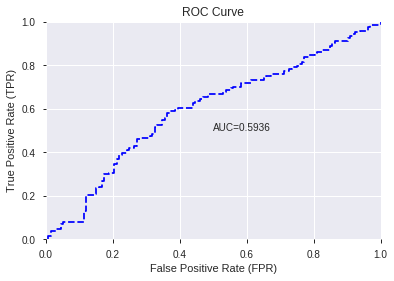

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


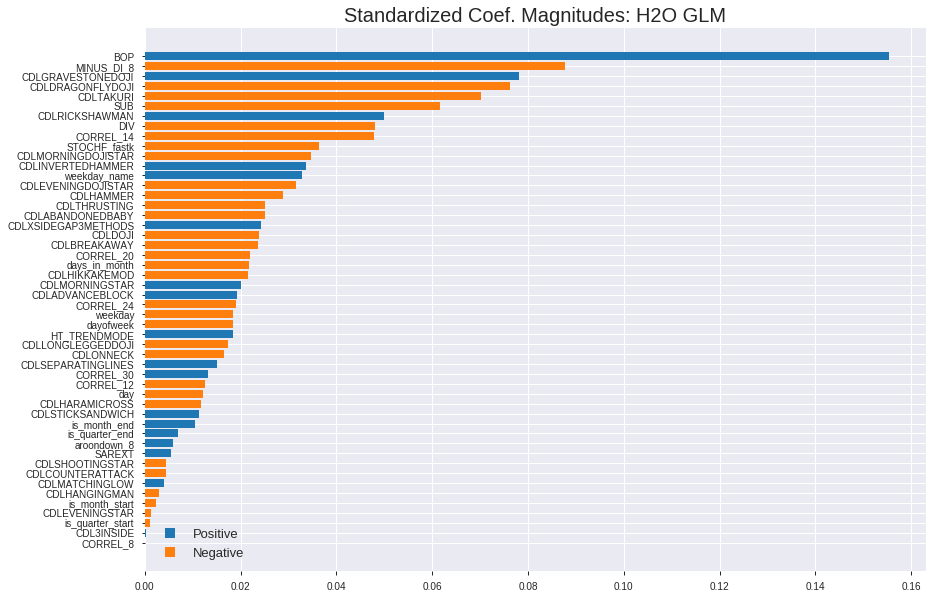

'log_likelihood'
--2019-08-22 16:06:59--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.165.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.165.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_160652_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_160652_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_a064',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'MINUS_DI_8',
 'CDLGRAVESTONEDOJI',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'SUB',
 'CDLRICKSHAWMAN',
 'DIV',
 'CORREL_14',
 'STOCHF_fastk',
 'CDLMORNINGDOJISTAR',
 'CDLINVERTEDHAMMER',
 'weekday_name',
 'CDLEVENINGDOJISTAR',
 'CDLHAMMER',
 'CDLTHRUSTING',
 'CDLABANDONEDBABY',
 'CDLXSIDEGAP3METHODS',
 'CDLDOJI',
 'CDLBREAKAWAY',
 'CORREL_20',
 'days_in_month',
 'CDLHIKKAKEMOD',
 'CDLMORNINGSTAR',
 'CDLADVANCEBLOCK',
 'CORREL_24',
 'weekday',
 'dayofweek',
 'HT_TRENDMODE',
 'CDLLONGLEGGEDDOJI',
 'CDLONNECK',
 'CDLSEPARATINGLINES',
 'CORREL_30',
 'CORREL_12',
 'day',
 'CDLHARAMICROSS',
 'CDLSTICKSANDWICH',
 'is_month_end',
 'is_quarter_end',
 'aroondown_8',
 'SAREXT',
 'CDLSHOOTINGSTAR',
 'CDLCOUNTERATTACK',
 'CDLMATCHINGLOW',
 'CDLHANGINGMAN',
 'is_month_start',
 'CDLEVENINGSTAR',
 'is_quarter_start',
 'CDL3INSIDE',
 'CORREL_8']

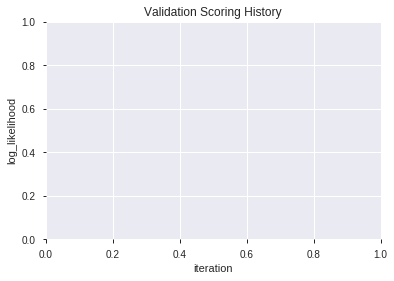

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_160709_model_2  0.625672  0.674699              0.409213  0.490838  0.240922
1  XGBoost_grid_1_AutoML_20190822_160709_model_4  0.621823  0.673331              0.436828  0.490193  0.240289
2               XGBoost_2_AutoML_20190822_160709  0.617119  0.677481              0.373656  0.492014  0.242077
3  XGBoost_grid_1_AutoML_20190822_160709_model_1  0.613575  0.679727              0.419110  0.493281  0.243326
4               XGBoost_1_AutoML_20190822_160709  0.607710  0.693723              0.436828  0.498986  0.248987
5               XGBoost_3_AutoML_20190822_160709  0.594758  0.684306              0.434262  0.495688  0.245707
6  XGBoost_grid_1_AutoML_20190822_160709_model_7  0.588710  0.694077              0.430718  0.499956  0.249956
7  XGBoost_grid_1_AutoML_20190822_160709_model_6  0.581928  0.692895              0.448192  0.499619  0.249619
8  XGBoost_grid_1_AutoML_20190822_160709_model_3  0.573925  0.693213              0.473974  0.499902  0.249902
9  XGBoost_grid_1_AutoML_20190822_160709_model_5  0.563783  0.721927              0.451491  0.511510  0.261642

variable  relative_importance  scaled_importance  percentage
0                  BOP           704.562622           1.000000    0.144070
1                  DIV           496.126648           0.704163    0.101449
2         STOCHF_fastk           450.707947           0.639699    0.092161
3               SAREXT           418.474274           0.593949    0.085570
4           MINUS_DI_8           329.547363           0.467733    0.067386
5            CORREL_30           228.567352           0.324410    0.046738
6            CORREL_12           222.689209           0.316067    0.045536
7            CORREL_14           216.632782           0.307471    0.044297
8          aroondown_8           210.165558           0.298292    0.042975
9                  day           193.092926           0.274061    0.039484
10    CDLDRAGONFLYDOJI           179.234848           0.254392    0.036650
11            CORREL_8           176.077835           0.249911    0.036005
12           CORREL_20           173.546478           0.246318    0.035487
13                 SUB           159.013214           0.225691    0.032515
14   CDLGRAVESTONEDOJI           155.069672           0.220094    0.031709
15           CORREL_24           109.373772           0.155236    0.022365
16      CDLRICKSHAWMAN           107.731476           0.152905    0.022029
17        weekday_name            82.426888           0.116990    0.016855
18           dayofweek            59.924847           0.085053    0.012254
19           CDLTAKURI            40.841259           0.057967    0.008351
20       days_in_month            38.724854           0.054963    0.007919
21     CDLSHOOTINGSTAR            33.963169           0.048205    0.006945
22       CDLHANGINGMAN            12.967016           0.018404    0.002652
23          CDL3INSIDE            12.021935           0.017063    0.002458
24     CDLADVANCEBLOCK            10.360204           0.014704    0.002118
25             weekday            10.312941           0.014637    0.002109
26             CDLDOJI             9.613133           0.013644    0.001966
27           CDLHAMMER             8.581135           0.012179    0.001755
28        HT_TRENDMODE             7.166773           0.010172    0.001465
29    is_quarter_start             7.015272           0.009957    0.001434
30    CDLABANDONEDBABY             5.204309           0.007387    0.001064
31        is_month_end             4.657035           0.006610    0.000952
32   CDLLONGLEGGEDDOJI             4.550066           0.006458    0.000930
33      is_quarter_end             3.875240           0.005500    0.000792
34  CDLEVENINGDOJISTAR             2.830917           0.004018    0.000579
35      is_month_start             2.071603           0.002940    0.000424
36   CDLINVERTEDHAMMER             1.446711           0.002053    0.000296
37      CDLMATCHINGLOW             1.250141           0.001774    0.000256

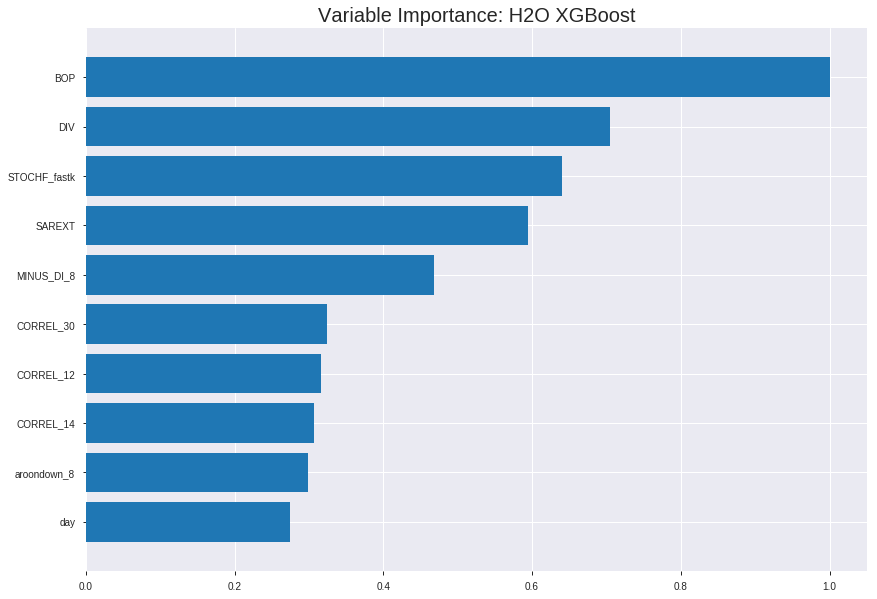

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_160709_model_2


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.19536484031904203
RMSE: 0.4420009505861294
LogLoss: 0.5795280598600994
Mean Per-Class Error: 0.24042847970803904
AUC: 0.8426723787282027
pr_auc: 0.8371782894295171
Gini: 0.6853447574564053
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47960346937179565: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      530  349   0.397    (349.0/879.0)
1      107  802   0.1177   (107.0/909.0)
Total  637  1151  0.255    (456.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.479603     0.778641  226
max f2                       0.391425     0.867526  293
max f0point5                 0.558445     0.786137  148
max accuracy                 0.505287     0.760067  202
max precision                0.792178     1         0
max recall                   0.251112     1         377
max specificity              0.792178     1         0
max absolute_mcc             0.504502     0.521899  203
max min_per_class_accuracy   0.520235     0.756876  187
max mean_per_class_accuracy  0.521317     0.759572  186

Gains/Lift Table: Avg response rate: 50.84 %, avg score: 50.85 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.755456           1.85772    1.85772            0.944444         0.770016  0.944444                    0.770016            0.0187019       0.0187019                  85.7719   85.7719
    2        0.0201342                   0.734042           1.967      1.91236            1                0.744416  0.972222                    0.757216            0.019802        0.0385039                  96.6997   91.2358
    3        0.0302013                   0.724632           1.63916    1.82129            0.833333         0.729011  0.925926                    0.747815            0.0165017       0.0550055                  63.9164   82.1293
    4        0.0402685                   0.703531           1.74844    1.80308            0.888889         0.715363  0.916667                    0.739702            0.0176018       0.0726073                  74.8442   80.308
    5        0.0503356                   0.691691           1.967      1.83586            1                0.697166  0.933333                    0.731195            0.019802        0.0924092                  96.6997   83.5864
    6        0.100112                    0.651799           1.81229    1.82414            0.921348         0.669132  0.927374                    0.700337            0.090209        0.182618                   81.2289   82.4142
    7        0.150447                    0.624589           1.7703     1.80613            0.9              0.63735   0.918216                    0.679263            0.0891089       0.271727                   77.0297   80.6127
    8        0.200224                    0.607373           1.67968    1.77469            0.853933         0.615405  0.902235                    0.663388            0.0836084       0.355336                   67.9683   77.4693
    9        0.300336                    0.576081           1.60437    1.71792            0.815642         0.591064  0.873371                    0.63928             0.160616        0.515952                   60.4366   71.7917
    10       0.399888                    0.54886            1.29291    1.61211            0.657303         0.562878  0.81958                     0.62026             0.128713        0.644664                   29.2914   61.2112
    11       0.5                         0.521151           1.09888    1.50935            0.558659         0.535657  0.767338                    0.60332             0.110011        0.754675                   9.88808   50.9351
    12       0.600112                    0.490906           0.890093   1.40605            0.452514         0.506718  0.714818                    0.587205            0.0891089       0.843784                   -10.9907  40.6045
    13       0.699664                    0.456108           0.651982   1.29875            0.331461         0.475331  0.660272                    0.571287            0.0649065       0.908691                   -34.8018  29.8752
    14       0.799776                    0.40866            0.571418   1.20771            0.290503         0.43378   0.613986                    0.554074            0.0572057       0.965897                   -42.8582  20.7708
    15       0.899888                    0.333436           0.263731   1.10269            0.134078         0.373702  0.560597                    0.534008            0.0264026       0.992299                   -73.6269  10.2692
    16       1                           0.185784           0.0769217  1                  0.0391061        0.279412  0.508389                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.24435420715182699
RMSE: 0.49432196709414705
LogLoss: 0.6814117746370513
Mean Per-Class Error: 0.42349768875192595
AUC: 0.5786055469953775
pr_auc: 0.5067864644008346
Gini: 0.15721109399075495
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.368592232465744: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      58   217  0.7891   (217.0/275.0)
1      21   215  0.089    (21.0/236.0)
Total  79   432  0.4658   (238.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.368592     0.643713  330
max f2                       0.249699     0.8125    384
max f0point5                 0.446482     0.553528  267
max accuracy                 0.493882     0.571429  198
max precision                0.641512     0.611111  17
max recall                   0.213148     1         397
max specificity              0.708658     0.996364  0
max absolute_mcc             0.368592     0.168137  330
max min_per_class_accuracy   0.498407     0.563636  190
max mean_per_class_accuracy  0.446482     0.576502  267

Gains/Lift Table: Avg response rate: 46.18 %, avg score: 48.33 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.669025           0.721751  0.721751           0.333333         0.684868  0.333333                    0.684868            0.00847458      0.00847458                 -27.8249  -27.8249
    2        0.0215264                   0.656284           1.7322    1.18105            0.8              0.660413  0.545455                    0.673752            0.0169492       0.0254237                  73.2203   18.1048
    3        0.0313112                   0.643816           1.29915   1.21796            0.6              0.648871  0.5625                      0.665977            0.0127119       0.0381356                  29.9153   21.7956
    4        0.0410959                   0.636258           1.29915   1.23729            0.6              0.639851  0.571429                    0.659756            0.0127119       0.0508475                  29.9153   23.7288
    5        0.0508806                   0.627269           0         0.999348           0                0.630793  0.461538                    0.654187            0               0.0508475                  -100      -0.065189
    6        0.101761                    0.605303           1.24919   1.12427            0.576923         0.616215  0.519231                    0.635201            0.0635593       0.114407                   24.9185   12.4267
    7        0.150685                    0.589272           1.12593   1.12481            0.52             0.597396  0.519481                    0.622926            0.0550847       0.169492                   12.5932   12.4807
    8        0.201566                    0.578513           1.08263   1.11416            0.5              0.583549  0.514563                    0.612986            0.0550847       0.224576                   8.26271   11.416
    9        0.30137                     0.545855           0.976487  1.06857            0.45098          0.563594  0.493506                    0.596629            0.0974576       0.322034                   -2.35128  6.8567
    10       0.401174                    0.519406           1.35859   1.14072            0.627451         0.531985  0.526829                    0.580547            0.135593        0.457627                   35.8591   14.0719
    11       0.500978                    0.497772           1.14631   1.14183            0.529412         0.507567  0.527344                    0.566008            0.114407        0.572034                   14.6311   14.1833
    12       0.600783                    0.472062           0.976487  1.11437            0.45098          0.485809  0.514658                    0.552685            0.0974576       0.669492                   -2.35128  11.4365
    13       0.700587                    0.441808           1.0614    1.10682            0.490196         0.455968  0.511173                    0.538907            0.105932        0.775424                   6.13991   10.682
    14       0.800391                    0.396041           0.806663  1.06939            0.372549         0.419805  0.493888                    0.524055            0.0805085       0.855932                   -19.3337  6.93921
    15       0.900196                    0.333561           0.806663  1.04026            0.372549         0.366521  0.480435                    0.50659             0.0805085       0.936441                   -19.3337  4.02634
    16       1                           0.198981           0.636839  1                  0.294118         0.273376  0.46184                     0.483314         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 16:07:15  1.000 sec   0                  0.5              0.693147            0.5             0                  1                0.491611                         0.5                0.693147              0.5               0                    1                  0.53816
    2019-08-22 16:07:15  1.133 sec   5                  0.490632         0.674552            0.73622         0.658212           1.6896           0.354586                         0.497065           0.687281              0.575054          0.525624             1.4435             0.489237
    2019-08-22 16:07:15  1.211 sec   10                 0.482994         0.659525            0.756612        0.723343           1.71043          0.337248                         0.495699           0.684519              0.575824          0.512942             1.4435             0.514677
    2019-08-22 16:07:15  1.300 sec   15                 0.475663         0.645192            0.779859        0.765579           1.86347          0.288031                         0.494369           0.681795              0.577527          0.520095             1.80438            0.475538
    2019-08-22 16:07:15  1.389 sec   20                 0.469377         0.632892            0.7907          0.777216           1.967            0.290828                         0.493717           0.680418              0.578806          0.515024             1.08263            0.489237
    2019-08-22 16:07:15  1.480 sec   25                 0.463985         0.622319            0.798879        0.786419           1.967            0.284676                         0.493816           0.680541              0.576911          0.511354             0.721751           0.489237
    2019-08-22 16:07:15  1.568 sec   30                 0.459107         0.612773            0.806797        0.796851           1.967            0.27349                          0.493732           0.680288              0.577103          0.511544             0.721751           0.493151
    2019-08-22 16:07:15  1.655 sec   35                 0.454174         0.603185            0.818492        0.810288           1.85772          0.261186                         0.494195           0.681185              0.573552          0.50849              1.08263            0.499022
    2019-08-22 16:07:15  1.745 sec   40                 0.45009          0.59524             0.827998        0.820156           1.85772          0.263423                         0.493446           0.679612              0.579052          0.511153             0.721751           0.495108
    2019-08-22 16:07:15  1.834 sec   45                 0.445816         0.586885            0.83451         0.828978           1.85772          0.262304                         0.494107           0.680942              0.57688           0.507066             1.08263            0.497065
    2019-08-22 16:07:15  1.947 sec   50                 0.442001         0.579528            0.842672        0.837178           1.85772          0.255034                         0.494322           0.681412              0.578606          0.506786             0.721751           0.465753

Variable Importances: 


variable            relative_importance    scaled_importance      percentage
------------------  ---------------------  ---------------------  ----------------------
BOP                 704.5626220703125      1.0                    0.14406997870377208
DIV                 496.12664794921875     0.7041626001836176     0.10144869081244656
STOCHF_fastk        450.70794677734375     0.6396989176816776     0.09216140944722534
SAREXT              418.4742736816406      0.5939490125831265     0.08557022159397748
MINUS_DI_8          329.54736328125        0.46773324749033096    0.06738631900497813
---                 ---                    ---                    ---
is_quarter_end      3.8752403259277344     0.005500207085270273   0.0007924147176412245
CDLEVENINGDOJISTAR  2.8309173583984375     0.004017978345317222   0.0005788700546420695
is_month_start      2.0716030597686768     0.0029402681818138502  0.00042360437433730004
CDLINVERTEDHAMMER   1.4467110633850098     0.0020533463145319024  0.00029582555980608007
CDLMATCHINGLOW      1.2501413822174072     0.0017743509846490952  0.0002556307085714121


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6171875)

('F1', 0.6687306501547987)

('auc', 0.6256720430107527)

('logloss', 0.6746987884162547)

('mean_per_class_error', 0.3775659824046921)

('rmse', 0.49083758281304685)

('mse', 0.24092153270175465)

xgboost prediction progress: |████████████████████████████████████████████| 100%


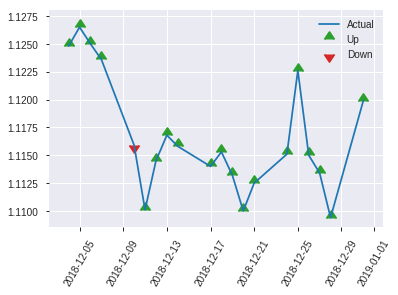


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24092153270175465
RMSE: 0.49083758281304685
LogLoss: 0.6746987884162547
Mean Per-Class Error: 0.3775659824046921
AUC: 0.6256720430107527
pr_auc: 0.5684295951721241
Gini: 0.2513440860215055
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48834824562072754: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      41   91   0.6894   (91.0/132.0)
1      16   108  0.129    (16.0/124.0)
Total  57   199  0.418    (107.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.488348     0.668731  198
max f2                       0.274561     0.826667  253
max f0point5                 0.523428     0.609453  169
max accuracy                 0.529025     0.617188  165
max precision                0.669825     0.714286  6
max recall                   0.274561     1         253
max specificity              0.694074     0.992424  0
max absolute_mcc             0.523428     0.259093  169
max min_per_class_accuracy   0.556408     0.58871   126
max mean_per_class_accuracy  0.523428     0.622434  169

Gains/Lift Table: Avg response rate: 48.44 %, avg score: 54.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117188                   0.674086           1.37634   1.37634            0.666667         0.683172  0.666667                    0.683172            0.016129        0.016129                   37.6344    37.6344
    2        0.0234375                   0.670115           1.37634   1.37634            0.666667         0.67116   0.666667                    0.677166            0.016129        0.0322581                  37.6344    37.6344
    3        0.03125                     0.669155           1.03226   1.29032            0.5              0.669817  0.625                       0.675329            0.00806452      0.0403226                  3.22581    29.0323
    4        0.0429688                   0.659887           1.37634   1.31378            0.666667         0.66494   0.636364                    0.672496            0.016129        0.0564516                  37.6344    31.3783
    5        0.0507812                   0.656848           1.03226   1.27047            0.5              0.657539  0.615385                    0.670195            0.00806452      0.0645161                  3.22581    27.0471
    6        0.101562                    0.641916           1.11166   1.19107            0.538462         0.650524  0.576923                    0.660359            0.0564516       0.120968                   11.1663    19.1067
    7        0.152344                    0.631167           1.11166   1.1646             0.538462         0.635195  0.564103                    0.651971            0.0564516       0.177419                   11.1663    16.4599
    8        0.203125                    0.614625           0.952854  1.11166            0.461538         0.622103  0.538462                    0.644504            0.0483871       0.225806                   -4.71464   11.1663
    9        0.300781                    0.600471           1.73419   1.31378            0.84             0.606133  0.636364                    0.632046            0.169355        0.395161                   73.4194    31.3783
    10       0.402344                    0.578968           0.952854  1.22267            0.461538         0.590945  0.592233                    0.621671            0.0967742       0.491935                   -4.71464   22.2675
    11       0.5                         0.555273           0.990968  1.17742            0.48             0.566212  0.570312                    0.610839            0.0967742       0.58871                    -0.903226  17.7419
    12       0.601562                    0.535882           0.952854  1.13951            0.461538         0.547956  0.551948                    0.600223            0.0967742       0.685484                   -4.71464   13.9506
    13       0.699219                    0.51381            1.15613   1.14183            0.56             0.526468  0.553073                    0.589922            0.112903        0.798387                   15.6129    14.1827
    14       0.800781                    0.476669           0.71464   1.08765            0.346154         0.496726  0.526829                    0.578102            0.0725806       0.870968                   -28.536    8.76475
    15       0.898438                    0.402397           0.743226  1.05021            0.36             0.441932  0.508696                    0.563301            0.0725806       0.943548                   -25.6774   5.02104
    16       1                           0.23755            0.555831  1                  0.269231         0.349014  0.484375                    

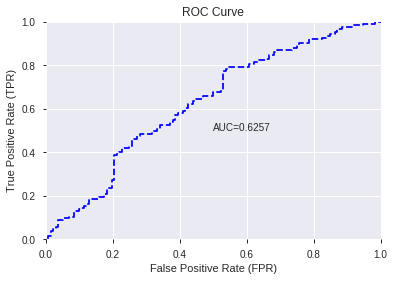

This function is available for GLM models only


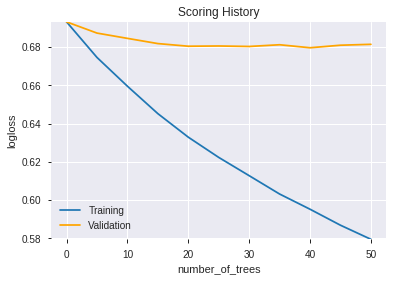

--2019-08-22 16:07:29--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.186.171
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.186.171|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_160709_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_160709_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_a064',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'DIV',
 'STOCHF_fastk',
 'SAREXT',
 'MINUS_DI_8',
 'CORREL_30',
 'CORREL_12',
 'CORREL_14',
 'aroondown_8',
 'day',
 'CDLDRAGONFLYDOJI',
 'CORREL_8',
 'CORREL_20',
 'SUB',
 'CDLGRAVESTONEDOJI',
 'CORREL_24',
 'CDLRICKSHAWMAN',
 'weekday_name',
 'dayofweek',
 'CDLTAKURI',
 'days_in_month',
 'CDLSHOOTINGSTAR',
 'CDLHANGINGMAN',
 'CDL3INSIDE',
 'CDLADVANCEBLOCK',
 'weekday',
 'CDLDOJI',
 'CDLHAMMER',
 'HT_TRENDMODE',
 'is_quarter_start',
 'CDLABANDONEDBABY',
 'is_month_end',
 'CDLLONGLEGGEDDOJI',
 'is_quarter_end',
 'CDLEVENINGDOJISTAR',
 'is_month_start',
 'CDLINVERTEDHAMMER',
 'CDLMATCHINGLOW']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [905 915 920 924] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


6

['BOP',
 'MINUS_DI_8',
 'CDLBELTHOLD',
 'CDLDRAGONFLYDOJI',
 'CDLGRAVESTONEDOJI',
 'CDLTAKURI']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_160742_model_4  0.566135  0.687688              0.466887  0.497270  0.247277
1  DeepLearning_grid_1_AutoML_20190822_160742_model_6  0.557735  0.682002              0.459311  0.494523  0.244553
2  DeepLearning_grid_1_AutoML_20190822_160742_model_3  0.547226  0.694029              0.478250  0.500112  0.250112
3  DeepLearning_grid_1_AutoML_20190822_160742_model_5  0.546493  0.688746              0.478250  0.497773  0.247778
4  DeepLearning_grid_1_AutoML_20190822_160742_model_7  0.545852  0.690355              0.470674  0.498610  0.248612
5  DeepLearning_grid_1_AutoML_20190822_160742_model_2  0.541483  0.691945              0.500000  0.499207  0.249208
6  DeepLearning_grid_1_AutoML_20190822_160742_model_1  0.539773  0.715472              0.492424  0.510137  0.260240
7               DeepLearning_1_AutoML_20190822_160742  0.535313  0.710673              0.496212  0.507790  0.257850

variable  relative_importance  scaled_importance  percentage
0                BOP             1.000000           1.000000    0.193280
1  CDLGRAVESTONEDOJI             0.987815           0.987815    0.190925
2   CDLDRAGONFLYDOJI             0.927906           0.927906    0.179346
3          CDLTAKURI             0.851879           0.851879    0.164651
4         MINUS_DI_8             0.807647           0.807647    0.156102
5        CDLBELTHOLD             0.598599           0.598599    0.115697

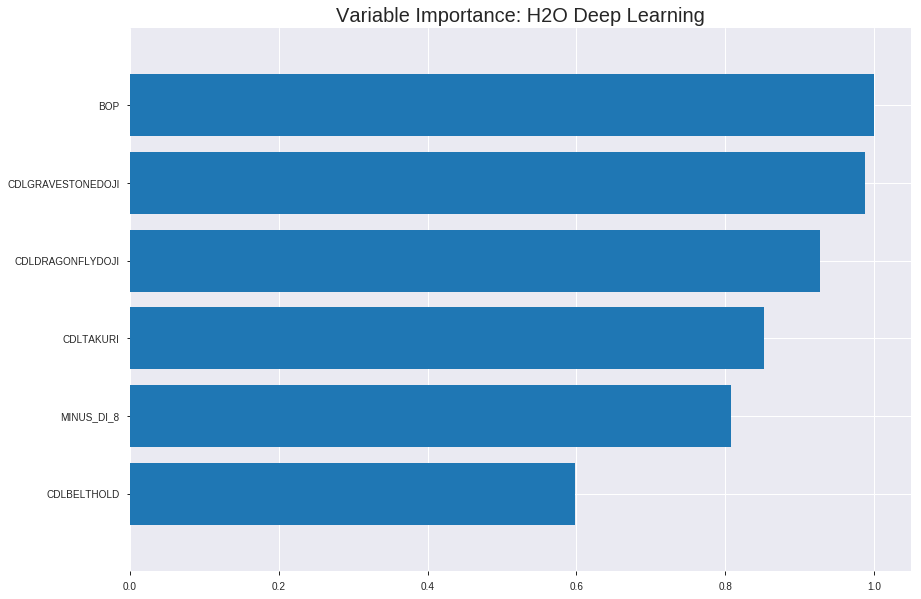

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_160742_model_4


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.23283762257677276
RMSE: 0.4825325093470623
LogLoss: 0.65698631374126
Mean Per-Class Error: 0.39412849134742833
AUC: 0.6477395179791017
pr_auc: 0.6511606500862825
Gini: 0.29547903595820335
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.350029810973274: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      163  716   0.8146   (716.0/879.0)
1      50   859   0.055    (50.0/909.0)
Total  213  1575  0.4284   (766.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.35003      0.691626  304
max f2                       0.214341     0.839044  382
max f0point5                 0.508274     0.613076  170
max accuracy                 0.508274     0.606264  170
max precision                0.884097     1         0
max recall                   0.158682     1         399
max specificity              0.884097     1         0
max absolute_mcc             0.508274     0.211982  170
max min_per_class_accuracy   0.512424     0.588168  166
max mean_per_class_accuracy  0.508274     0.605872  170

Gains/Lift Table: Avg response rate: 50.84 %, avg score: 50.02 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain         cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  -----------  -----------------
    1        0.0100671                   0.859184           1.63916   1.63916            0.833333         0.868327  0.833333                    0.868327            0.0165017       0.0165017                  63.9164      63.9164
    2        0.0201342                   0.841409           1.85772   1.74844            0.944444         0.849333  0.888889                    0.85883             0.0187019       0.0352035                  85.7719      74.8442
    3        0.0302013                   0.819051           1.52989   1.67559            0.777778         0.832358  0.851852                    0.850006            0.0154015       0.0506051                  52.9886      67.559
    4        0.0402685                   0.791468           1.63916   1.66648            0.833333         0.806379  0.847222                    0.839099            0.0165017       0.0671067                  63.9164      66.6483
    5        0.0503356                   0.768289           1.20205   1.5736             0.611111         0.783059  0.8                         0.827891            0.0121012       0.0792079                  20.2054      57.3597
    6        0.100112                    0.66275            1.39237   1.48349            0.707865         0.70235   0.75419                     0.765471            0.0693069       0.148515                   39.2368      48.3489
    7        0.150447                    0.6561             1.15834   1.3747             0.588889         0.659436  0.698885                    0.729995            0.0583058       0.206821                   15.8343      37.4704
    8        0.200224                    0.58785            1.30396   1.35712            0.662921         0.644716  0.689944                    0.708794            0.0649065       0.271727                   30.3964      35.7118
    9        0.300336                    0.51477            1.18679   1.30034            0.603352         0.52945   0.66108                     0.649013            0.118812        0.390539                   18.6791      30.0342
    10       0.399888                    0.513475           1.1161    1.25448            0.567416         0.513974  0.637762                    0.615395            0.111111        0.50165                    11.6105      25.4476
    11       0.5                         0.512354           0.945038  1.19252            0.480447         0.512945  0.606264                    0.594882            0.0946095       0.59626                    -5.49625     19.2519
    12       0.600112                    0.479043           0.999982  1.1604             0.50838          0.497167  0.589935                    0.578581            0.10011         0.69637                    -0.00184376  16.04
    13       0.699664                    0.446536           0.839841  1.11479            0.426966         0.46184   0.566747                    0.56197             0.0836084       0.779978                   -16.0159     11.4789
    14       0.799776                    0.410236           0.912071  1.08941            0.463687         0.428208  0.553846                    0.545226            0.0913091       0.871287                   -8.79289     8.94136
    15       0.899888                    0.329539           0.813172  1.05868            0.413408         0.376979  0.538222                    0.526509            0.0814081       0.952695                   -18.6828     5.86819
    16       1                           0.158682           0.472519  1                  0.240223         0.26340



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24618001133522063
RMSE: 0.49616530646068013
LogLoss: 0.6858860161597429
Mean Per-Class Error: 0.43790446841294295
AUC: 0.5683513097072419
pr_auc: 0.5026336628922153
Gini: 0.1367026194144838
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32702589187642056: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      40   235  0.8545   (235.0/275.0)
1      14   222  0.0593   (14.0/236.0)
Total  54   457  0.4873   (249.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.327026     0.640693  346
max f2                       0.196381     0.812113  397
max f0point5                 0.398367     0.540089  283
max accuracy                 0.497717     0.565558  124
max precision                0.65363      0.6       41
max recall                   0.196381     1         397
max specificity              0.715762     0.996364  0
max absolute_mcc             0.327026     0.13968   346
max min_per_class_accuracy   0.469805     0.559322  166
max mean_per_class_accuracy  0.47387      0.562096  159

Gains/Lift Table: Avg response rate: 46.18 %, avg score: 46.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.668475           0.360876  0.360876           0.166667         0.700235  0.166667                    0.700235            0.00423729      0.00423729                 -63.9124  -63.9124
    2        0.0215264                   0.664241           1.7322    0.984206           0.8              0.665408  0.454545                    0.684404            0.0169492       0.0211864                  73.2203   -1.57935
    3        0.0313112                   0.663611           0.433051  0.81197            0.2              0.663796  0.375                       0.677964            0.00423729      0.0254237                  -56.6949  -18.803
    4        0.0410959                   0.662473           0.866102  0.824859           0.4              0.663153  0.380952                    0.674438            0.00847458      0.0338983                  -13.3898  -17.5141
    5        0.0508806                   0.661971           1.7322    0.999348           0.8              0.662129  0.461538                    0.672071            0.0169492       0.0508475                  73.2203   -0.065189
    6        0.101761                    0.65512            1.49902   1.24919            0.692308         0.658565  0.576923                    0.665318            0.0762712       0.127119                   49.9022   24.9185
    7        0.150685                    0.528546           1.12593   1.20917            0.52             0.598198  0.558442                    0.643526            0.0550847       0.182203                   12.5932   20.9168
    8        0.201566                    0.514638           0.916069  1.13518            0.423077         0.51778   0.524272                    0.611784            0.0466102       0.228814                   -8.39309  13.5182
    9        0.30137                     0.513412           0.976487  1.08263            0.45098          0.513866  0.5                         0.579356            0.0974576       0.326271                   -2.35128  8.26271
    10       0.401174                    0.497582           1.35859   1.15128            0.627451         0.510229  0.531707                    0.562159            0.135593        0.461864                   35.8591   15.1282
    11       0.500978                    0.467767           1.01894   1.12492            0.470588         0.481036  0.519531                    0.545998            0.101695        0.563559                   1.89432   12.4917
    12       0.600783                    0.441995           0.934031  1.09321            0.431373         0.454246  0.504886                    0.530755            0.0932203       0.65678                    -6.59688  9.32065
    13       0.700587                    0.416907           0.934031  1.07053            0.431373         0.430678  0.494413                    0.516499            0.0932203       0.75                       -6.59688  7.05307
    14       0.800391                    0.391165           0.976487  1.0588             0.45098          0.403115  0.488998                    0.50236             0.0974576       0.847458                   -2.35128  5.8804
    15       0.900196                    0.322402           0.934031  1.04497            0.431373         0.36255   0.482609                    0.48686             0.0932203       0.940678                   -6.59688  4.49705
    16       1                           0.188781           0.594384  1                  0.27451          0.262533  0.46184                     0.464471     


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 16:09:15  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 16:09:22  7.116 sec         327 obs/sec       1.20973   1             2163       0.660673         1.68821             -0.746449      0.563346        0.564097           1.63916          0.450783                         0.694814           1.82452               -0.94238         0.539669          0.485273             1.08263            0.499022
    2019-08-22 16:09:27  12.908 sec        367 obs/sec       2.45022   2             4381       0.694362         2.3677              -0.929096      0.584796        0.603544           1.63916          0.486018                         0.672993           2.31791               -0.822292        0.533513          0.498793             1.80438            0.500978
    2019-08-22 16:09:32  18.029 sec        398 obs/sec       3.69016   3             6598       0.574973         0.944398            -0.322747      0.529951        0.546761           0.983498         0.480984                         0.614532           1.0664                -0.51945         0.490108          0.471346             1.4435             0.530333
    2019-08-22 16:09:41  26.072 sec        454 obs/sec       6.14038   5             10979      0.626026         1.16602             -0.568075      0.601118        0.596574           1.52989          0.467002                         0.608079           1.12656               -0.487707        0.578906          0.525808             0.721751           0.491194
    2019-08-22 16:09:47  32.626 sec        510 obs/sec       8.6387    7             15446      0.536582         0.801625            -0.152003      0.625571        0.627292           1.63916          0.427852                         0.563705           0.863715              -0.2785          0.57349           0.520422             0.360876           0.48728
    2019-08-22 16:09:53  38.051 sec        564 obs/sec       11.1152   9             19874      0.502531         0.714212            -0.0104355     0.639982        0.631516           1.42061          0.434004                         0.518783           0.762421              -0.0828525       0.569153          0.512868             1.08263            0.516634
    2019-08-22 16:09:59  44.543 sec        643 obs/sec       14.8294   12            26515      0.494868         0.683103            0.0201453      0.592392        0.603499           1.74844          0.467562                         0.499223           0.692945              -0.00273714      0.571225          0.520655             0.721751           0.534247
    2019-08-22 16:10:05  50.117 sec        717 obs/sec       18.585    15            33230      0.503068         0.702743            -0.0125935     0.572924        0.596603           1.63916          0.462528                         0.514186           0.726904              -0.0637457       0.535778          0.498983             0.360876           0.536204
    2019-08-22 16:10:10 

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ------------
BOP                1                      1                    0.19328
CDLGRAVESTONEDOJI  0.987815               0.987815             0.190925
CDLDRAGONFLYDOJI   0.927906               0.927906             0.179346
CDLTAKURI          0.851879               0.851879             0.164651
MINUS_DI_8         0.807647               0.807647             0.156102
CDLBELTHOLD        0.598599               0.598599             0.115697

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5859375)

('F1', 0.6611570247933884)

('auc', 0.5661351417399805)

('logloss', 0.6876875411994783)

('mean_per_class_error', 0.4193548387096774)

('rmse', 0.4972697330460239)

('mse', 0.24727718740366386)

deeplearning prediction progress: |███████████████████████████████████████| 100%


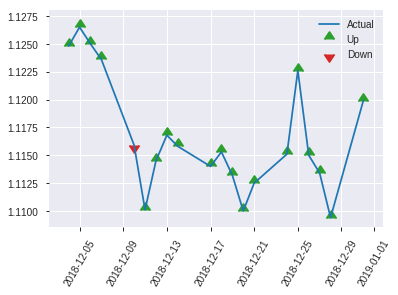


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.24727718740366386
RMSE: 0.4972697330460239
LogLoss: 0.6876875411994783
Mean Per-Class Error: 0.4193548387096774
AUC: 0.5661351417399805
pr_auc: 0.5467687993526925
Gini: 0.13227028347996095
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33031930528999753: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      13   119  0.9015   (119.0/132.0)
1      4    120  0.0323   (4.0/124.0)
Total  17   239  0.4805   (123.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.330319     0.661157  237
max f2                       0.246413     0.825566  253
max f0point5                 0.348883     0.556084  230
max accuracy                 0.513826     0.585938  83
max precision                0.663555     0.75      3
max recall                   0.246413     1         253
max specificity              0.683224     0.992424  0
max absolute_mcc             0.513826     0.171673  83
max min_per_class_accuracy   0.51239      0.522727  126
max mean_per_class_accuracy  0.513826     0.580645  83

Gains/Lift Table: Avg response rate: 48.44 %, avg score: 48.97 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.664125           1.37634   1.37634            0.666667         0.671486  0.666667                    0.671486            0.016129        0.016129                   37.6344   37.6344
    2        0.0234375                   0.662927           1.37634   1.37634            0.666667         0.66325   0.666667                    0.667368            0.016129        0.0322581                  37.6344   37.6344
    3        0.03125                     0.661639           1.03226   1.29032            0.5              0.66203   0.625                       0.666034            0.00806452      0.0403226                  3.22581   29.0323
    4        0.0429688                   0.659333           0.688172  1.1261             0.333333         0.660389  0.545455                    0.664494            0.00806452      0.0483871                  -31.1828  12.61
    5        0.0507812                   0.65889            1.03226   1.11166            0.5              0.659201  0.538462                    0.66368             0.00806452      0.0564516                  3.22581   11.1663
    6        0.101562                    0.63952            1.58809   1.34988            0.769231         0.653908  0.653846                    0.658794            0.0806452       0.137097                   58.8089   34.9876
    7        0.152344                    0.531366           1.27047   1.32341            0.615385         0.552323  0.641026                    0.623304            0.0645161       0.201613                   27.0471   32.3408
    8        0.203125                    0.517654           0.952854  1.23077            0.461538         0.520984  0.596154                    0.597724            0.0483871       0.25                       -4.71464  23.0769
    9        0.300781                    0.513949           1.23871   1.23335            0.6              0.514673  0.597403                    0.570759            0.120968        0.370968                   23.871    23.3347
    10       0.402344                    0.513467           0.794045  1.12246            0.384615         0.51369   0.543689                    0.556353            0.0806452       0.451613                   -20.5955  12.2455
    11       0.5                         0.51239            0.743226  1.04839            0.36             0.513021  0.507812                    0.54789             0.0725806       0.524194                   -25.6774  4.83871
    12       0.601562                    0.491334           1.19107   1.07248            0.576923         0.505191  0.519481                    0.540681            0.120968        0.645161                   19.1067   7.24759
    13       0.699219                    0.469817           0.825806  1.03802            0.4              0.480226  0.502793                    0.532238            0.0806452       0.725806                   -17.4194  3.80249
    14       0.800781                    0.441059           0.71464   0.99701            0.346154         0.456301  0.482927                    0.522607            0.0725806       0.798387                   -28.536   -0.298977
    15       0.898438                    0.355053           1.32129   1.03226            0.64             0.409182  0.5                         0.510278            0.129032        0.927419                   32.129    3.22581
    16       1                           0.226686           0.71464   1                  0.346154         0.307465  0.484375                    0.48968          

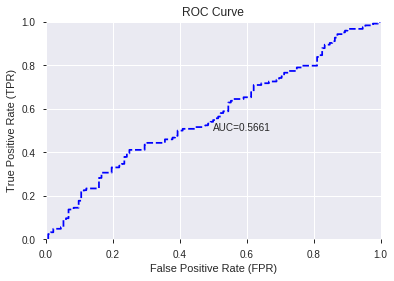

This function is available for GLM models only


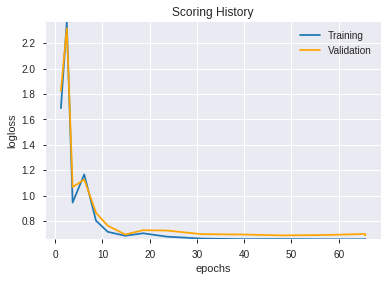

--2019-08-22 16:12:46--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.145.195
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.145.195|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_160742_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_160742_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_a064',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLGRAVESTONEDOJI',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'MINUS_DI_8',
 'CDLBELTHOLD']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_161258_model_1  0.546065  0.69638              0.478006  0.501406  0.251408

variable  relative_importance  scaled_importance  percentage
0   CDLDRAGONFLYDOJI             0.617824           1.000000    0.344512
1                BOP             0.388721           0.629178    0.216759
2          CDLTAKURI             0.343323           0.555698    0.191445
3  CDLGRAVESTONEDOJI             0.196819           0.318569    0.109751
4         MINUS_DI_8             0.165031           0.267116    0.092025
5        CDLBELTHOLD             0.081613           0.132098    0.045509

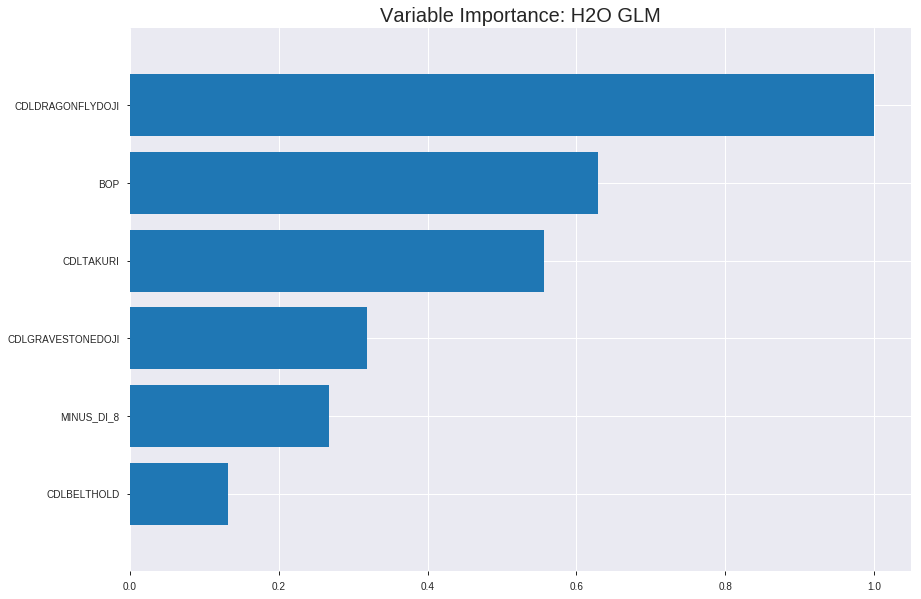

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_161258_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.23434775195547555
RMSE: 0.48409477579857807
LogLoss: 0.6609028237398957
Null degrees of freedom: 1787
Residual degrees of freedom: 1781
Null deviance: 2478.190938357651
Residual deviance: 2363.388497693867
AIC: 2377.388497693867
AUC: 0.636891106630572
pr_auc: 0.6338580085074316
Gini: 0.27378221326114405
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35873643444528613: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      197  682   0.7759   (682.0/879.0)
1      76   833   0.0836   (76.0/909.0)
Total  273  1515  0.4239   (758.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.358736     0.687294  300
max f2                       0.25678      0.838602  365
max f0point5                 0.49184      0.608935  220
max accuracy                 0.508532     0.598434  198
max precision                0.797041     0.9       6
max recall                   0.121255     1         398
max specificity              0.827369     0.998862  0
max absolute_mcc             0.49184      0.202335  220
max min_per_class_accuracy   0.517254     0.586359  187
max mean_per_class_accuracy  0.508532     0.597514  198

Gains/Lift Table: Avg response rate: 50.84 %, avg score: 50.84 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.788787           1.52989   1.52989            0.777778         0.80177   0.777778                    0.80177             0.0154015       0.0154015                  52.9886   52.9886
    2        0.0201342                   0.764147           1.63916   1.58453            0.833333         0.777108  0.805556                    0.789439            0.0165017       0.0319032                  63.9164   58.4525
    3        0.0302013                   0.748206           1.63916   1.60274            0.833333         0.756816  0.814815                    0.778565            0.0165017       0.0484048                  63.9164   60.2738
    4        0.0402685                   0.720027           1.31133   1.52989            0.666667         0.731067  0.777778                    0.76669             0.0132013       0.0616062                  31.1331   52.9886
    5        0.0503356                   0.700095           1.85772   1.59545            0.944444         0.710213  0.811111                    0.755395            0.0187019       0.080308                   85.7719   59.5453
    6        0.100112                    0.672112           1.32607   1.46151            0.674157         0.686723  0.743017                    0.721251            0.0660066       0.146315                   32.6065   46.1512
    7        0.150447                    0.64263            1.22391   1.38202            0.622222         0.658357  0.702602                    0.700208            0.0616062       0.207921                   22.3909   38.2016
    8        0.200224                    0.58195            1.21556   1.34063            0.617978         0.615952  0.681564                    0.679262            0.0605061       0.268427                   21.556    34.0635
    9        0.300336                    0.546038           1.06591   1.24906            0.541899         0.558138  0.635009                    0.638887            0.106711        0.375138                   6.59144   24.9061
    10       0.399888                    0.530485           1.06085   1.20221            0.539326         0.537947  0.611189                    0.613758            0.105611        0.480748                   6.08522   20.2206
    11       0.5                         0.516798           1.05493   1.17272            0.536313         0.523117  0.596197                    0.595609            0.105611        0.586359                   5.49256   17.2717
    12       0.600112                    0.500884           1.05493   1.15307            0.536313         0.509107  0.586207                    0.581179            0.105611        0.691969                   5.49256   15.3067
    13       0.699664                    0.482772           0.972448  1.12737            0.494382         0.492953  0.573141                    0.568626            0.0968097       0.788779                   -2.75522  12.7367
    14       0.799776                    0.443241           0.857127  1.09354            0.435754         0.468973  0.555944                    0.556152            0.0858086       0.874587                   -14.2873  9.35401
    15       0.899888                    0.318355           0.725261  1.05257            0.368715         0.365234  0.535115                    0.534912            0.0726073       0.947195                   -27.4739  5.25694
    16       1                           0.0830712          0.527463  1                  0.268156         0.269938  0.508389                    0.508385         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24631760335721278
RMSE: 0.4963039425162899
LogLoss: 0.685592828360169
Null degrees of freedom: 510
Residual degrees of freedom: 504
Null deviance: 709.8491425809777
Residual deviance: 700.6758705840928
AIC: 714.6758705840928
AUC: 0.5690909090909091
pr_auc: 0.5175125553673697
Gini: 0.13818181818181818
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28986345813250414: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      24   251  0.9127   (251.0/275.0)
1      5    231  0.0212   (5.0/236.0)
Total  29   482  0.501    (256.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.289863     0.643454  372
max f2                       0.265465     0.816044  391
max f0point5                 0.302628     0.536389  363
max accuracy                 0.544043     0.573386  92
max precision                0.650951     0.653846  23
max recall                   0.265465     1         391
max specificity              0.701771     0.996364  0
max absolute_mcc             0.302628     0.143563  363
max min_per_class_accuracy   0.499412     0.56      190
max mean_per_class_accuracy  0.503644     0.56725   180

Gains/Lift Table: Avg response rate: 46.18 %, avg score: 48.80 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.693269           0.721751  0.721751           0.333333         0.697108  0.333333                    0.697108            0.00847458      0.00847458                 -27.8249  -27.8249
    2        0.0215264                   0.683227           1.7322    1.18105            0.8              0.686406  0.545455                    0.692244            0.0169492       0.0254237                  73.2203   18.1048
    3        0.0313112                   0.669724           1.29915   1.21796            0.6              0.674997  0.5625                      0.686854            0.0127119       0.0381356                  29.9153   21.7956
    4        0.0410959                   0.660663           1.7322    1.3404             0.8              0.664558  0.619048                    0.681546            0.0169492       0.0550847                  73.2203   34.0395
    5        0.0508806                   0.650664           1.7322    1.41574            0.8              0.654446  0.653846                    0.676334            0.0169492       0.0720339                  73.2203   41.5743
    6        0.101761                    0.615491           1.16591   1.29082            0.538462         0.635291  0.596154                    0.655813            0.059322        0.131356                   16.5906   29.0825
    7        0.150685                    0.558289           1.03932   1.20917            0.48             0.577377  0.558442                    0.630346            0.0508475       0.182203                   3.9322    20.9168
    8        0.201566                    0.54636            1.33246   1.24029            0.615385         0.552207  0.572816                    0.610622            0.0677966       0.25                       33.2464   24.0291
    9        0.30137                     0.527938           0.976487  1.15293            0.45098          0.537146  0.532468                    0.586289            0.0974576       0.347458                   -2.35128  15.2928
    10       0.401174                    0.511421           1.14631   1.15128            0.529412         0.519501  0.531707                    0.569674            0.114407        0.461864                   14.6311   15.1282
    11       0.500978                    0.499007           1.01894   1.12492            0.470588         0.504906  0.519531                    0.556771            0.101695        0.563559                   1.89432   12.4917
    12       0.600783                    0.485854           0.551928  1.02973            0.254902         0.492504  0.47557                     0.546094            0.0550847       0.618644                   -44.8072  2.973
    13       0.700587                    0.473264           1.0614    1.03424            0.490196         0.479966  0.477654                    0.536674            0.105932        0.724576                   6.13991   3.42415
    14       0.800391                    0.450202           1.10386   1.04292            0.509804         0.463255  0.481663                    0.527519            0.110169        0.834746                   10.3855   4.2922
    15       0.900196                    0.316231           1.0614    1.04497            0.490196         0.373626  0.482609                    0.510457            0.105932        0.940678                   6.13991   4.49705
    16       1                           0.243742           0.594384  1                  0.27451          0.285816  0.46184                     0.488037           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-22 16:12:58  0.000 sec   2            .83E1     7             1.3808525413141384  1.3867664765743966
     2019-08-22 16:12:58  0.004 sec   4            .52E1     7             1.3780804096423591  1.3855588321524097
     2019-08-22 16:12:58  0.009 sec   6            .32E1     7             1.374111375443079   1.3839129706870266
     2019-08-22 16:12:58  0.013 sec   8            .2E1      7             1.3687500627312357  1.381858034643156
     2019-08-22 16:12:58  0.018 sec   10           .12E1     7             1.3620646374921785  1.3795776548869052
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-22 16:12:58  0.081 sec   34           .61E-3    7             1.3216146031374227  1.3711887097357158
     2019-08-22 16:12:58  0.084 sec   35           .38E-3    7             1.321466146510522   1.371192507126597
     2019-08-22 16:12:58  0.086 sec   36           .23E-3    7             1.321354582762624   1.3711951867984544
     2019-08-22 16:12:58  0.090 sec   37           .15E-3    7             1.3212728879527778  1.371197712508944
     2019-08-22 16:12:58  0.100 sec   38           .9E-4     7             1.3212142959441893  1.3711990847959523


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.55859375)

('F1', 0.6576086956521738)

('auc', 0.5460654936461388)

('logloss', 0.6963803851434294)

('mean_per_class_error', 0.4473362658846529)

('rmse', 0.5014063330071509)

('mse', 0.2514083107796779)

glm prediction progress: |████████████████████████████████████████████████| 100%


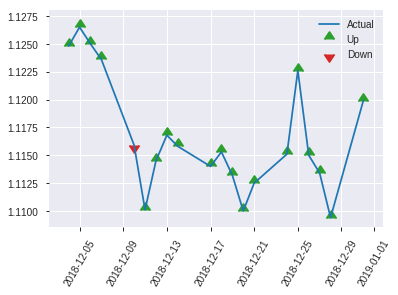


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2514083107796779
RMSE: 0.5014063330071509
LogLoss: 0.6963803851434294
Null degrees of freedom: 255
Residual degrees of freedom: 249
Null deviance: 355.23191699062966
Residual deviance: 356.5467571934359
AIC: 370.5467571934359
AUC: 0.5460654936461388
pr_auc: 0.5502790059879568
Gini: 0.09213098729227753
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29957220224867837: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      9    123  0.9318   (123.0/132.0)
1      3    121  0.0242   (3.0/124.0)
Total  12   244  0.4922   (126.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.299572     0.657609  243
max f2                       0.264097     0.826667  253
max f0point5                 0.304422     0.551471  240
max accuracy                 0.538526     0.558594  68
max precision                0.704951     1         0
max recall                   0.264097     1         253
max specificity              0.704951     1         0
max absolute_mcc             0.679302     0.140385  7
max min_per_class_accuracy   0.517974     0.508065  126
max mean_per_class_accuracy  0.5365       0.552664  78

Gains/Lift Table: Avg response rate: 48.44 %, avg score: 50.14 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117188                   0.695967           2.06452   2.06452            1                0.70306   1                           0.70306             0.0241935       0.0241935                  106.452    106.452
    2        0.0234375                   0.684845           1.37634   1.72043            0.666667         0.689443  0.833333                    0.696252            0.016129        0.0403226                  37.6344    72.043
    3        0.03125                     0.676482           2.06452   1.80645            1                0.681093  0.875                       0.692462            0.016129        0.0564516                  106.452    80.6452
    4        0.0429688                   0.668096           0.688172  1.50147            0.333333         0.672019  0.727273                    0.686887            0.00806452      0.0645161                  -31.1828   50.1466
    5        0.0507812                   0.658223           1.03226   1.42928            0.5              0.658924  0.692308                    0.682585            0.00806452      0.0725806                  3.22581    42.928
    6        0.101562                    0.592271           1.27047   1.34988            0.615385         0.631273  0.653846                    0.656929            0.0645161       0.137097                   27.0471    34.9876
    7        0.152344                    0.556994           1.11166   1.27047            0.538462         0.564741  0.615385                    0.6262              0.0564516       0.193548                   11.1663    27.0471
    8        0.203125                    0.551496           0.952854  1.19107            0.461538         0.554595  0.576923                    0.608298            0.0483871       0.241935                   -4.71464   19.1067
    9        0.300781                    0.537209           1.07355   1.15291            0.52             0.541315  0.558442                    0.586551            0.104839        0.346774                   7.35484    15.2912
    10       0.402344                    0.528631           0.952854  1.10241            0.461538         0.533531  0.533981                    0.573167            0.0967742       0.443548                   -4.71464   10.2412
    11       0.5                         0.517218           0.660645  1.01613            0.32             0.523511  0.492188                    0.563469            0.0645161       0.508065                   -33.9355   1.6129
    12       0.601562                    0.507525           1.11166   1.03226            0.538462         0.513187  0.5                         0.554979            0.112903        0.620968                   11.1663    3.22581
    13       0.699219                    0.496729           0.990968  1.02649            0.48             0.502952  0.497207                    0.547713            0.0967742       0.717742                   -0.903226  2.64913
    14       0.800781                    0.47871            0.873449  1.00708            0.423077         0.488177  0.487805                    0.540162            0.0887097       0.806452                   -12.6551   0.708104
    15       0.898438                    0.318512           0.990968  1.00533            0.48             0.398142  0.486957                    0.524725            0.0967742       0.903226                   -0.903226  0.532959
    16       1                           0.25548            0.952854  1                  0.461538         0.294767  0.484375                    0

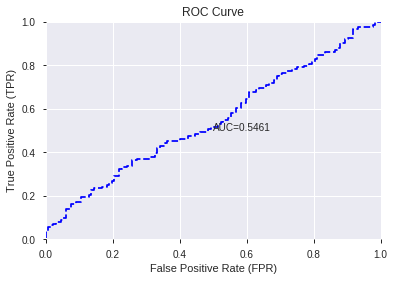

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


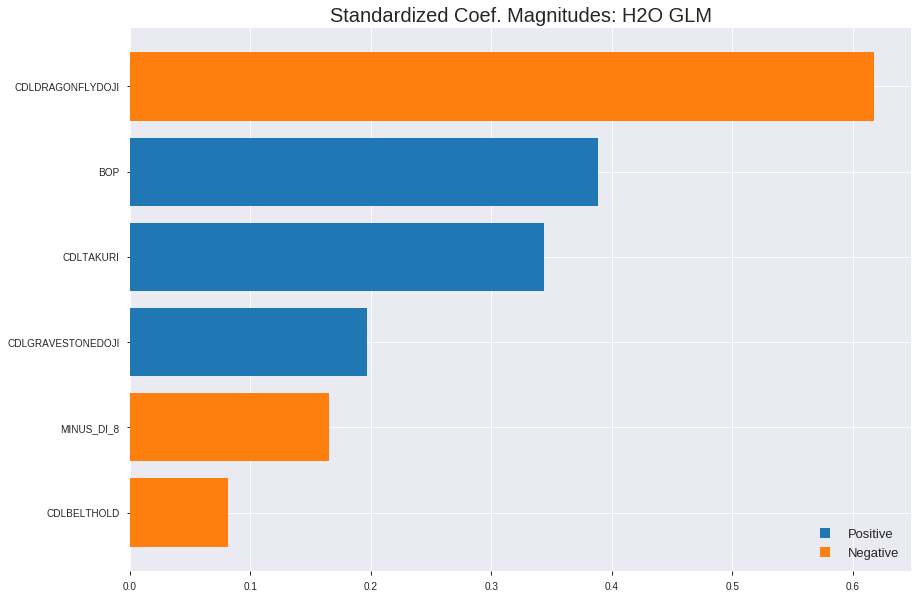

'log_likelihood'
--2019-08-22 16:13:04--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.185.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.185.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_161258_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_161258_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_a064',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['CDLDRAGONFLYDOJI',
 'BOP',
 'CDLTAKURI',
 'CDLGRAVESTONEDOJI',
 'MINUS_DI_8',
 'CDLBELTHOLD']

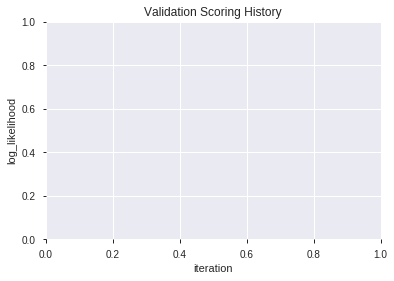

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_1_AutoML_20190822_161316  0.565677  0.691159              0.466887  0.498920  0.248921
1  XGBoost_grid_1_AutoML_20190822_161316_model_1  0.564180  0.688248              0.478006  0.497551  0.247557
2  XGBoost_grid_1_AutoML_20190822_161316_model_4  0.560606  0.689652              0.477761  0.498261  0.248264
3  XGBoost_grid_1_AutoML_20190822_161316_model_7  0.559323  0.694212              0.477761  0.500373  0.250373
4  XGBoost_grid_1_AutoML_20190822_161316_model_2  0.555810  0.691698              0.477761  0.499324  0.249324
5  XGBoost_grid_1_AutoML_20190822_161316_model_3  0.553947  0.692764              0.473974  0.499767  0.249767
6               XGBoost_3_AutoML_20190822_161316  0.552358  0.690831              0.485093  0.498884  0.248886
7  XGBoost_grid_1_AutoML_20190822_161316_model_6  0.547257  0.694843              0.470919  0.500659  0.250659
8               XGBoost_2_AutoML_20190822_161316  0.543438  0.699119              0.474218  0.502722  0.252730
9  XGBoost_grid_1_AutoML_20190822_161316_model_5  0.525751  0.720121              0.462854  0.511853  0.261993

variable  relative_importance  scaled_importance  percentage
0                BOP          1089.310547           1.000000    0.442884
1         MINUS_DI_8           985.384705           0.904595    0.400631
2   CDLDRAGONFLYDOJI           161.672684           0.148417    0.065732
3  CDLGRAVESTONEDOJI           122.796890           0.112729    0.049926
4          CDLTAKURI            59.187996           0.054335    0.024064
5        CDLBELTHOLD            41.231792           0.037851    0.016764

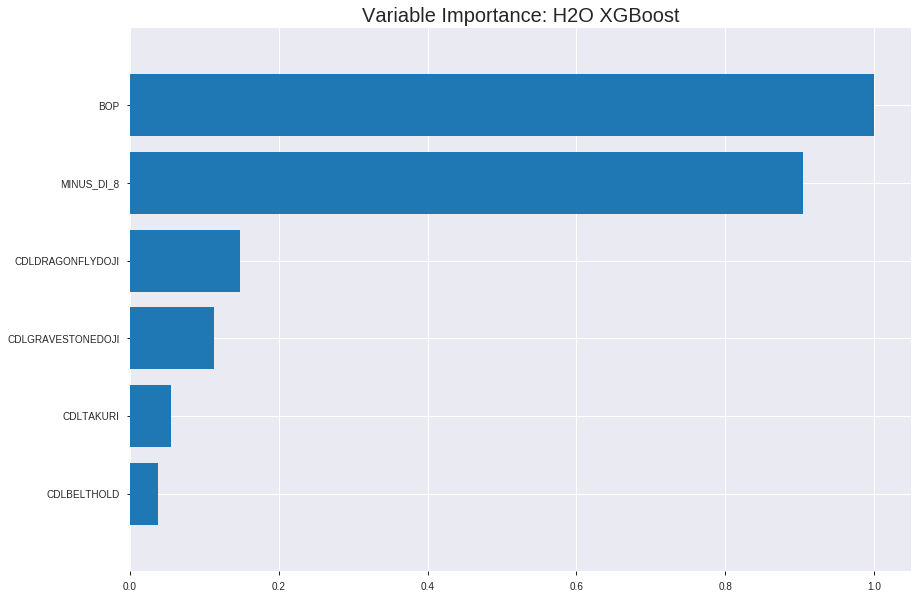

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20190822_161316


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.21575158840746228
RMSE: 0.464490676340723
LogLoss: 0.6215854717959516
Mean Per-Class Error: 0.3314391166079065
AUC: 0.7319767812958771
pr_auc: 0.7357545319302413
Gini: 0.46395356259175413
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42605237662792206: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      307  572   0.6507   (572.0/879.0)
1      91   818   0.1001   (91.0/909.0)
Total  398  1390  0.3708   (663.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.426052     0.711614  274
max f2                       0.308968     0.846516  350
max f0point5                 0.549195     0.676003  158
max accuracy                 0.523641     0.668345  184
max precision                0.797986     1         0
max recall                   0.213856     1         393
max specificity              0.797986     1         0
max absolute_mcc             0.523641     0.337143  184
max min_per_class_accuracy   0.521539     0.664391  186
max mean_per_class_accuracy  0.523641     0.668561  184

Gains/Lift Table: Avg response rate: 50.84 %, avg score: 51.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.754636           1.967     1.967              1                0.776761  1                           0.776761            0.019802        0.019802                   96.6997   96.6997
    2        0.0201342                   0.73192            1.74844   1.85772            0.888889         0.742877  0.944444                    0.759819            0.0176018       0.0374037                  74.8442   85.7719
    3        0.0302013                   0.715335           1.74844   1.82129            0.888889         0.72368   0.925926                    0.747772            0.0176018       0.0550055                  74.8442   82.1293
    4        0.0402685                   0.704853           1.74844   1.80308            0.888889         0.710503  0.916667                    0.738455            0.0176018       0.0726073                  74.8442   80.308
    5        0.0503356                   0.688367           1.74844   1.79215            0.888889         0.697079  0.911111                    0.73018             0.0176018       0.090209                   74.8442   79.2153
    6        0.100112                    0.659766           1.59128   1.69228            0.808989         0.673255  0.860335                    0.701877            0.0792079       0.169417                   59.1278   69.2276
    7        0.150447                    0.639701           1.52989   1.63795            0.777778         0.649466  0.832714                    0.684341            0.0770077       0.246425                   52.9886   63.7945
    8        0.200224                    0.615571           1.41447   1.58239            0.719101         0.625397  0.804469                    0.669688            0.070407        0.316832                   41.447    58.2388
    9        0.300336                    0.576423           1.25272   1.4725             0.636872         0.595935  0.748603                    0.645104            0.125413        0.442244                   25.2724   47.25
    10       0.399888                    0.54666            1.16031   1.39478            0.589888         0.560639  0.709091                    0.624076            0.115512        0.557756                   16.0307   39.4779
    11       0.5                         0.52169            1.04394   1.32453            0.530726         0.533319  0.673378                    0.605904            0.10451         0.662266                   4.39368   32.4532
    12       0.600112                    0.488707           0.945038  1.26122            0.480447         0.506874  0.641193                    0.589384            0.0946095       0.756876                   -5.49625  26.1224
    13       0.699664                    0.456028           0.784589  1.19341            0.398876         0.473531  0.606715                    0.5729              0.0781078       0.834983                   -21.5411  19.3406
    14       0.799776                    0.409907           0.758228  1.13893            0.385475         0.437345  0.579021                    0.555932            0.0759076       0.910891                   -24.1772  13.8932
    15       0.902125                    0.341123           0.601922  1.07801            0.306011         0.374476  0.548047                    0.535345            0.0616062       0.972497                   -39.8078  7.80069
    16       1                           0.194753           0.281     1                  0.142857         0.286009  0.508389                    0.510941            



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25086421135355386
RMSE: 0.5008634657804
LogLoss: 0.6944992977432353
Mean Per-Class Error: 0.4538674884437597
AUC: 0.5370570107858244
pr_auc: 0.47823728675502764
Gini: 0.0741140215716487
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2687819302082062: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      22   253  0.92     (253.0/275.0)
1      3    233  0.0127   (3.0/236.0)
Total  25   486  0.501    (256.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.268782     0.645429  374
max f2                       0.230196     0.816044  390
max f0point5                 0.394559     0.53719   320
max accuracy                 0.673632     0.545988  8
max precision                0.673632     0.7       8
max recall                   0.230196     1         390
max specificity              0.709362     0.996364  0
max absolute_mcc             0.268782     0.155515  374
max min_per_class_accuracy   0.496646     0.521186  203
max mean_per_class_accuracy  0.394559     0.546133  320

Gains/Lift Table: Avg response rate: 46.18 %, avg score: 48.75 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.681827           1.08263   1.08263            0.5              0.691709  0.5                         0.691709            0.0127119       0.0127119                  8.26271   8.26271
    2        0.0215264                   0.670498           1.7322    1.37789            0.8              0.673741  0.636364                    0.683541            0.0169492       0.029661                   73.2203   37.7889
    3        0.0313112                   0.660067           0.433051  1.08263            0.2              0.66488   0.5                         0.67771             0.00423729      0.0338983                  -56.6949  8.26271
    4        0.0410959                   0.652976           0.866102  1.03107            0.4              0.655958  0.47619                     0.672531            0.00847458      0.0423729                  -13.3898  3.10734
    5        0.0508806                   0.648206           0.433051  0.916069           0.2              0.65025   0.423077                    0.668246            0.00423729      0.0466102                  -56.6949  -8.39309
    6        0.101761                    0.624533           1.16591   1.04099            0.538462         0.638941  0.480769                    0.653594            0.059322        0.105932                   16.5906   4.09876
    7        0.150685                    0.595557           1.12593   1.06857            0.52             0.609542  0.493506                    0.639291            0.0550847       0.161017                   12.5932   6.8567
    8        0.201566                    0.57291            0.916069  1.03007            0.423077         0.586826  0.475728                    0.626048            0.0466102       0.207627                   -8.39309  3.00724
    9        0.30137                     0.550611           1.01894   1.02639            0.470588         0.560099  0.474026                    0.604207            0.101695        0.309322                   1.89432   2.63867
    10       0.401174                    0.521939           0.934031  1.00341            0.431373         0.535002  0.463415                    0.586991            0.0932203       0.402542                   -6.59688  0.34105
    11       0.500978                    0.496318           1.23122   1.0488             0.568627         0.5084    0.484375                    0.571334            0.122881        0.525424                   23.1223   4.8795
    12       0.600783                    0.468252           1.10386   1.05794            0.509804         0.478766  0.488599                    0.555956            0.110169        0.635593                   10.3855   5.79418
    13       0.702544                    0.439175           1.08263   1.06152            0.5              0.453342  0.490251                    0.541093            0.110169        0.745763                   8.26271   6.15174
    14       0.800391                    0.411461           0.952712  1.04822            0.44             0.426489  0.484108                    0.527082            0.0932203       0.838983                   -4.72881  4.8216
    15       0.900196                    0.343361           1.01894   1.04497            0.470588         0.383099  0.482609                    0.511119            0.101695        0.940678                   1.89432   4.49705
    16       1                           0.197567           0.594384  1                  0.27451          0.274009  0.46184                     0.487455           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 16:13:16  0.006 sec   0                  0.5              0.693147            0.5             0                  1                0.491611                         0.5                0.693147              0.5               0                    1                  0.53816
    2019-08-22 16:13:16  0.083 sec   5                  0.49338          0.679972            0.678852        0.672185           1.71766          0.39094                          0.498085           0.689311              0.544969          0.49036              1.35328            0.500978
    2019-08-22 16:13:16  0.162 sec   10                 0.487089         0.667508            0.701587        0.693319           1.74844          0.370246                         0.4968             0.686684              0.549391          0.494997             1.08263            0.500978
    2019-08-22 16:13:16  0.250 sec   15                 0.481723         0.656878            0.715124        0.707603           1.86347          0.37528                          0.496308           0.685624              0.550578          0.492356             1.08263            0.500978
    2019-08-22 16:13:17  0.315 sec   20                 0.478709         0.650813            0.713251        0.708055           1.967            0.360179                         0.496551           0.685965              0.545023          0.489289             0.721751           0.500978
    2019-08-22 16:13:17  0.387 sec   25                 0.475607         0.644548            0.717416        0.717407           1.967            0.368009                         0.497465           0.687716              0.539037          0.480713             0.721751           0.497065
    2019-08-22 16:13:17  0.456 sec   30                 0.473149         0.639498            0.717077        0.718355           1.967            0.373043                         0.498326           0.689402              0.537504          0.480351             1.08263            0.502935
    2019-08-22 16:13:17  0.530 sec   35                 0.470794         0.634675            0.721153        0.720324           1.967            0.364094                         0.498639           0.68997               0.537789          0.480216             1.08263            0.502935
    2019-08-22 16:13:17  0.612 sec   40                 0.468318         0.62952             0.72456         0.726545           1.967            0.365213                         0.499767           0.692257              0.53621           0.476521             1.08263            0.504892
    2019-08-22 16:13:17  0.686 sec   45                 0.466905         0.626564            0.725743        0.729433           1.967            0.369687                         0.500191           0.693132              0.537504          0.476624             1.08263            0.499022
    2019-08-22 16:13:17  0.776 sec   50                 0.464491         0.621585            0.731977        0.735755           1.967            0.370805                         0.500863           0.694499              0.537057          0.478237             1.08263            0.500978

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ------------
BOP                1089.31                1                    0.442884
MINUS_DI_8         985.385                0.904595             0.400631
CDLDRAGONFLYDOJI   161.673                0.148417             0.0657317
CDLGRAVESTONEDOJI  122.797                0.112729             0.0499259
CDLTAKURI          59.188                 0.0543353            0.0240642
CDLBELTHOLD        41.2318                0.0378513            0.0167637

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5859375)

('F1', 0.6611570247933884)

('auc', 0.5656769305962854)

('logloss', 0.6911587900411263)

('mean_per_class_error', 0.4171554252199414)

('rmse', 0.49891974692773544)

('mse', 0.2489209138744356)

xgboost prediction progress: |████████████████████████████████████████████| 100%


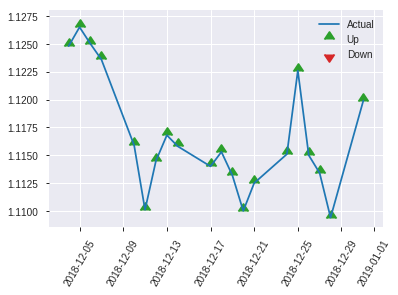


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2489209138744356
RMSE: 0.49891974692773544
LogLoss: 0.6911587900411263
Mean Per-Class Error: 0.4171554252199414
AUC: 0.5656769305962854
pr_auc: 0.5180641997831462
Gini: 0.13135386119257086
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35023391246795654: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      13   119  0.9015   (119.0/132.0)
1      4    120  0.0323   (4.0/124.0)
Total  17   239  0.4805   (123.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.350234     0.661157  227
max f2                       0.229195     0.82777   239
max f0point5                 0.5384       0.56391   96
max accuracy                 0.5384       0.585938  96
max precision                0.600316     0.625     47
max recall                   0.229195     1         239
max specificity              0.71845      0.992424  0
max absolute_mcc             0.5384       0.169134  96
max min_per_class_accuracy   0.520459     0.548387  118
max mean_per_class_accuracy  0.5384       0.582845  96

Gains/Lift Table: Avg response rate: 48.44 %, avg score: 51.08 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.683742           0         0                  0                0.703096  0                           0.703096            0               0                          -100      -100
    2        0.0234375                   0.675156           0.688172  0.344086           0.333333         0.677365  0.166667                    0.69023             0.00806452      0.00806452                 -31.1828  -65.5914
    3        0.03125                     0.657396           1.03226   0.516129           0.5              0.661422  0.25                        0.683028            0.00806452      0.016129                   3.22581   -48.3871
    4        0.0429688                   0.650481           1.37634   0.750733           0.666667         0.652711  0.363636                    0.67476             0.016129        0.0322581                  37.6344   -24.9267
    5        0.0507812                   0.645058           1.03226   0.794045           0.5              0.647365  0.384615                    0.670545            0.00806452      0.0403226                  3.22581   -20.5955
    6        0.101562                    0.629245           1.11166   0.952854           0.538462         0.635965  0.461538                    0.653255            0.0564516       0.0967742                  11.1663   -4.71464
    7        0.152344                    0.615409           1.42928   1.11166            0.692308         0.622618  0.538462                    0.643043            0.0725806       0.169355                   42.928    11.1663
    8        0.203125                    0.598387           1.42928   1.19107            0.692308         0.604688  0.576923                    0.633454            0.0725806       0.241935                   42.928    19.1067
    9        0.300781                    0.566748           1.07355   1.15291            0.52             0.582288  0.558442                    0.616842            0.104839        0.346774                   7.35484   15.2912
    10       0.402344                    0.537695           1.34988   1.20263            0.653846         0.550509  0.582524                    0.600098            0.137097        0.483871                   34.9876   20.2631
    11       0.5                         0.518451           0.660645  1.09677            0.32             0.528173  0.53125                     0.58605             0.0645161       0.548387                   -33.9355  9.67742
    12       0.605469                    0.500482           0.841099  1.05224            0.407407         0.507921  0.509677                    0.57244             0.0887097       0.637097                   -15.8901  5.22373
    13       0.699219                    0.480072           0.946237  1.03802            0.458333         0.489922  0.502793                    0.561377            0.0887097       0.725806                   -5.37634  3.80249
    14       0.800781                    0.440552           0.952854  1.02722            0.461538         0.460965  0.497561                    0.548641            0.0967742       0.822581                   -4.71464  2.72227
    15       0.898438                    0.373815           1.07355   1.03226            0.52             0.413735  0.5                         0.533978            0.104839        0.927419                   7.35484   3.22581
    16       1                           0.200226           0.71464   1                  0.346154         0.305755  0.484375                    0.510799       

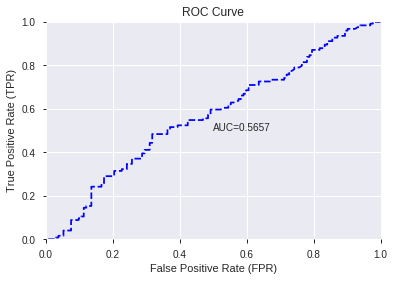

This function is available for GLM models only


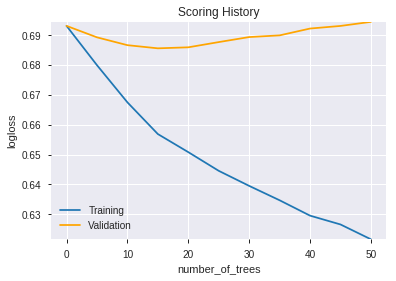

--2019-08-22 16:13:32--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.97.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.97.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_1_AutoML_20190822_161316',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_1_AutoML_20190822_161316',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_a064',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_90_sid_a064',
   'type

['BOP',
 'MINUS_DI_8',
 'CDLDRAGONFLYDOJI',
 'CDLGRAVESTONEDOJI',
 'CDLTAKURI',
 'CDLBELTHOLD']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

972

['fama',
 'SAREXT',
 'DEMA_8',
 'EMA_8',
 'KAMA_8',
 'MIDPOINT_8',
 'MIDPRICE_8',
 'SAR_0.08',
 'SMA_8',
 'TEMA_8',
 'TRIMA_8',
 'WMA_8',
 'MA_8_0',
 'MAVP_8_0',
 'T3_8_0',
 'BBANDS_upperband_8_0_2',
 'BBANDS_middleband_8_0_2',
 'BBANDS_lowerband_8_0_2',
 'BBANDS_upperband_8_0_3',
 'BBANDS_middleband_8_0_3',
 'BBANDS_lowerband_8_0_3',
 'BBANDS_upperband_8_0_4',
 'BBANDS_middleband_8_0_4',
 'BBANDS_lowerband_8_0_4',
 'BBANDS_upperband_8_0_5',
 'BBANDS_middleband_8_0_5',
 'BBANDS_lowerband_8_0_5',
 'MA_8_1',
 'MAVP_8_1',
 'T3_8_1',
 'BBANDS_upperband_8_1_2',
 'BBANDS_middleband_8_1_2',
 'BBANDS_lowerband_8_1_2',
 'BBANDS_upperband_8_1_3',
 'BBANDS_middleband_8_1_3',
 'BBANDS_lowerband_8_1_3',
 'BBANDS_upperband_8_1_4',
 'BBANDS_middleband_8_1_4',
 'BBANDS_lowerband_8_1_4',
 'BBANDS_upperband_8_1_5',
 'BBANDS_middleband_8_1_5',
 'BBANDS_lowerband_8_1_5',
 'MA_8_2',
 'MAVP_8_2',
 'T3_8_2',
 'BBANDS_upperband_8_2_2',
 'BBANDS_middleband_8_2_2',
 'BBANDS_lowerband_8_2_2',
 'BBANDS_upperband_

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_161500_model_4  0.594636  0.722970              0.443426  0.509310  0.259397
1  DeepLearning_grid_1_AutoML_20190822_161500_model_3  0.562256  0.887277              0.477273  0.568176  0.322824
2  DeepLearning_grid_1_AutoML_20190822_161500_model_2  0.553336  0.690387              0.470186  0.498698  0.248700
3  DeepLearning_grid_1_AutoML_20190822_161500_model_8  0.541300  0.692069              0.492424  0.499461  0.249461
4  DeepLearning_grid_1_AutoML_20190822_161500_model_1  0.537879  2.580870              0.488636  0.673941  0.454197
5  DeepLearning_grid_1_AutoML_20190822_161500_model_6  0.531769  0.691774              0.484848  0.499313  0.249314
6  DeepLearning_grid_1_AutoML_20190822_161500_model_7  0.514266  0.711076              0.496212  0.508642  0.258716
7  DeepLearning_grid_1_AutoML_20190822_161500_model_9  0.500000  0.692661              0.500000  0.499757  0.249757
8               DeepLearning_1_AutoML_20190822_161500  0.500000  0.693708              0.500000  0.500280  0.250280
9  DeepLearning_grid_1_AutoML_20190822_161500_model_5  0.485948  0.693125              0.500000  0.499989  0.249989

variable  relative_importance  scaled_importance  percentage
0            CDLSTICKSANDWICH             1.000000           1.000000    0.001997
1         CDLXSIDEGAP3METHODS             0.977581           0.977581    0.001952
2                CDLTHRUSTING             0.975877           0.975877    0.001948
3                CDLBREAKAWAY             0.962866           0.962866    0.001922
4          CDLSEPARATINGLINES             0.957493           0.957493    0.001912
..                        ...                  ...                ...         ...
963  BBANDS_middleband_30_1_3             0.464581           0.464581    0.000928
964    BBANDS_upperband_8_7_4             0.463869           0.463869    0.000926
965                 MAVP_24_5             0.463005           0.463005    0.000924
966                 CDLHARAMI             0.458229           0.458229    0.000915
967  BBANDS_middleband_12_1_2             0.457423           0.457423    0.000913

[968 rows x 4 columns]

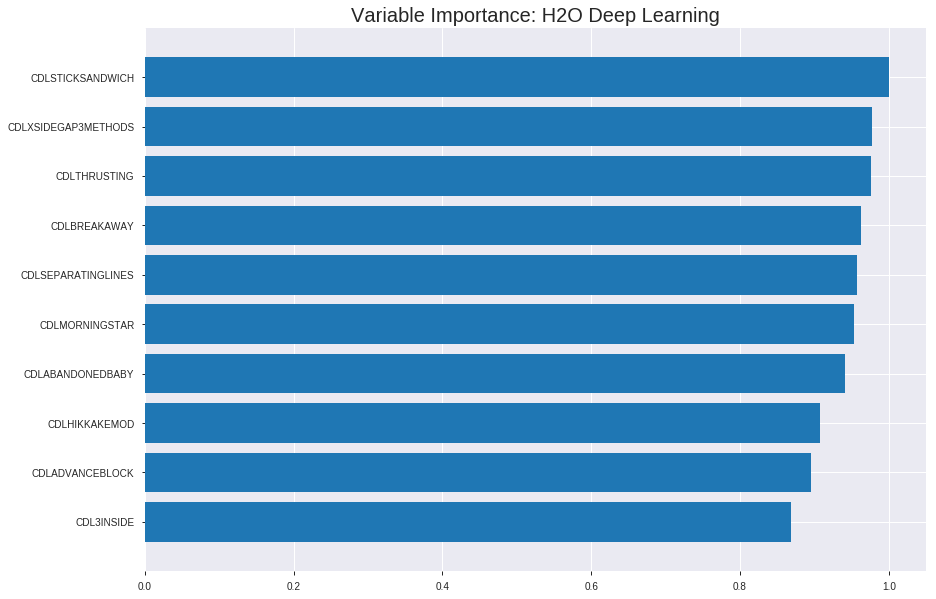

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_161500_model_4


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24377511903048407
RMSE: 0.49373587982896694
LogLoss: 0.9002227453737509
Mean Per-Class Error: 0.332054877842733
AUC: 0.697756977062894
pr_auc: 0.6075096378698642
Gini: 0.39551395412578794
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2697725584270422: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      349  530   0.603    (530.0/879.0)
1      78   831   0.0858   (78.0/909.0)
Total  427  1361  0.34     (608.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.269773     0.732159  297
max f2                       0.0873727    0.854334  364
max f0point5                 0.407713     0.666193  248
max accuracy                 0.407713     0.670582  248
max precision                0.861577     0.669884  71
max recall                   0.0163556    1         392
max specificity              0.999652     0.973834  0
max absolute_mcc             0.269773     0.364939  297
max min_per_class_accuracy   0.602541     0.646189  169
max mean_per_class_accuracy  0.407713     0.667945  248

Gains/Lift Table: Avg response rate: 50.84 %, avg score: 57.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.999817           1.42061   1.42061            0.722222         0.999876   0.722222                    0.999876            0.0143014       0.0143014                  42.0609   42.0609
    2        0.0201342                   0.999639           0.983498  1.20205            0.5              0.999731   0.611111                    0.999804            0.00990099      0.0242024                  -1.65017  20.2054
    3        0.0302013                   0.999334           1.20205   1.20205            0.611111         0.999486   0.611111                    0.999698            0.0121012       0.0363036                  20.2054   20.2054
    4        0.0402685                   0.999055           1.09278   1.17473            0.555556         0.999202   0.597222                    0.999574            0.0110011       0.0473047                  9.27759   17.4734
    5        0.0503356                   0.998627           1.20205   1.1802             0.611111         0.998866   0.6                         0.999432            0.0121012       0.0594059                  20.2054   18.0198
    6        0.100112                    0.992733           1.19346   1.18679            0.606742         0.996484   0.603352                    0.997966            0.0594059       0.118812                   19.3459   18.6791
    7        0.150447                    0.971265           1.20205   1.1919             0.611111         0.983005   0.605948                    0.992961            0.0605061       0.179318                   20.2054   19.1898
    8        0.200224                    0.94222            1.43657   1.25272            0.730337         0.959079   0.636872                    0.984537            0.0715072       0.250825                   43.6571   25.2724
    9        0.300336                    0.849177           1.39558   1.30034            0.709497         0.897794   0.66108                     0.955623            0.139714        0.390539                   39.5579   30.0342
    10       0.399888                    0.725515           1.33712   1.3095             0.679775         0.789086   0.665734                    0.914163            0.133113        0.523652                   33.7116   30.9497
    11       0.5                         0.604783           1.19778   1.28713            0.608939         0.669512   0.654362                    0.865178            0.119912        0.643564                   19.778    28.7129
    12       0.600112                    0.494037           1.08789   1.25389            0.553073         0.549061   0.637465                    0.812443            0.108911        0.752475                   8.7892    25.3892
    13       0.699664                    0.359816           1.06085   1.22642            0.539326         0.425976   0.623501                    0.757454            0.105611        0.858086                   6.08522   22.6425
    14       0.799776                    0.220315           0.769217  1.16919            0.391061         0.291842   0.594406                    0.699171            0.0770077       0.935094                   -23.0783  16.9194
    15       0.899888                    0.0819479          0.494496  1.09413            0.251397         0.145225   0.556246                    0.637545            0.049505        0.984598                   -50.5504  9.41343
    16       1                           0.000370459        0.153843  1                  0.0782123        0.0334133  0.508389                   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3265256402715466
RMSE: 0.5714242209353281
LogLoss: 1.0028094006749706
Mean Per-Class Error: 0.4617719568567026
AUC: 0.5236748844375964
pr_auc: 0.4710891470923177
Gini: 0.04734976887519271
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0021600304200496603: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    270  0.9818   (270.0/275.0)
1      0    236  0        (0.0/236.0)
Total  5    506  0.5284   (270.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.00216003   0.636119  396
max f2                       0.00216003   0.813793  396
max f0point5                 0.129974     0.534314  350
max accuracy                 0.736252     0.545988  116
max precision                0.97407      0.526316  13
max recall                   0.00216003   1         396
max specificity              0.992576     0.992727  0
max absolute_mcc             0.129974     0.118405  350
max min_per_class_accuracy   0.546433     0.512727  197
max mean_per_class_accuracy  0.129974     0.538228  350

Gains/Lift Table: Avg response rate: 46.18 %, avg score: 53.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117417                   0.988256           0.721751  0.721751           0.333333         0.990702   0.333333                    0.990702            0.00847458      0.00847458                 -27.8249   -27.8249
    2        0.0215264                   0.985542           1.29915   0.984206           0.6              0.986618   0.454545                    0.988845            0.0127119       0.0211864                  29.9153    -1.57935
    3        0.0313112                   0.979189           0.866102  0.947299           0.4              0.982382   0.4375                      0.986826            0.00847458      0.029661                   -13.3898   -5.27013
    4        0.0410959                   0.97197            1.29915   1.03107            0.6              0.974592   0.47619                     0.983913            0.0127119       0.0423729                  29.9153    3.10734
    5        0.0508806                   0.966231           0         0.83279            0                0.968685   0.384615                    0.980984            0               0.0423729                  -100       -16.721
    6        0.101761                    0.933324           1.24919   1.04099            0.576923         0.952777   0.480769                    0.966881            0.0635593       0.105932                   24.9185    4.09876
    7        0.150685                    0.884559           1.12593   1.06857            0.52             0.910558   0.493506                    0.948594            0.0550847       0.161017                   12.5932    6.8567
    8        0.201566                    0.833092           0.999348  1.05109            0.461538         0.86197    0.485437                    0.926728            0.0508475       0.211864                   -0.065189  5.10943
    9        0.30137                     0.732477           1.18877   1.09669            0.54902          0.782149   0.506494                    0.878848            0.118644        0.330508                   18.8767    9.66872
    10       0.401174                    0.640415           0.806663  1.02453            0.372549         0.691116   0.473171                    0.832144            0.0805085       0.411017                   -19.3337   2.45349
    11       0.500978                    0.546433           1.0614    1.03188            0.490196         0.592419   0.476562                    0.784386            0.105932        0.516949                   6.13991    3.1879
    12       0.600783                    0.435902           0.849119  1.00152            0.392157         0.485067   0.462541                    0.734662            0.0847458       0.601695                   -15.0881   0.151825
    13       0.700587                    0.336304           1.10386   1.0161             0.509804         0.377766   0.469274                    0.683819            0.110169        0.711864                   10.3855    1.6097
    14       0.800391                    0.255315           1.10386   1.02704            0.509804         0.300817   0.474328                    0.636061            0.110169        0.822034                   10.3855    2.70399
    15       0.900196                    0.0969916          1.10386   1.03556            0.509804         0.177733   0.478261                    0.585246            0.110169        0.932203                   10.3855    3.55564
    16       1                           2.68505e-09        0.679295  1                  0.313725         0.0410139  0.46184  


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 16:19:40  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 16:19:44  6.240 sec         139 obs/sec       0.300895  1             538        0.677559         2.81286             -0.836862      0.588247        0.570774           1.09278          0.491611                         0.632211           2.43135               -0.608132        0.550424          0.520638             1.4435             0.53816
    2019-08-22 16:20:07  28.966 sec        155 obs/sec       2.11186   7             3776       0.622942         2.24275             -0.552663      0.586731        0.585834           1.31133          0.491611                         0.585335           1.37227               -0.3785          0.580778          0.514387             1.4435             0.51272
    2019-08-22 16:20:31  52.667 sec        163 obs/sec       4.19295   14            7497       0.575572         1.40914             -0.325507      0.619304        0.551141           1.42061          0.461969                         0.662219           2.66173               -0.764415        0.533136          0.462219             1.08263            0.497065
    2019-08-22 16:20:56  1 min 17.742 sec  172 obs/sec       6.60626   22            11812      0.608295         2.03809             -0.48051       0.591385        0.544904           1.63916          0.491611                         0.685258           2.51333               -0.889318        0.53832           0.490001             1.08263            0.528376
    2019-08-22 16:21:19  1 min 41.109 sec  179 obs/sec       9.01063   30            16111      0.527469         1.11404             -0.113208      0.681244        0.577301           1.42061          0.381432                         0.630313           1.83432               -0.59849         0.545054          0.472379             1.4435             0.493151
    2019-08-22 16:21:42  2 min  4.448 sec  184 obs/sec       11.4659   38            20501      0.493736         0.900223            0.0246249      0.697757        0.60751            1.42061          0.340045                         0.571424           1.00281               -0.313755        0.523675          0.471089             0.721751           0.528376
    2019-08-22 16:22:07  2 min 29.372 sec  190 obs/sec       14.1963   47            25383      0.506945         0.860848            -0.0282622     0.715317        0.730673           1.967            0.426174                         0.586706           1.03601               -0.384961        0.506888          0.464004             1.08263            0.528376
    2019-08-22 16:22:31  2 min 53.507 sec  194 obs/sec       16.9088   56            30233      0.467798         0.709238            0.124413       0.761267        0.724571           1.85772          0.294183                         0.619103           1.34678               -0.542135        0.567265          0.502645             0.721751           0.526419
    2019-08-22 16:22:56  

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
CDLSTICKSANDWICH          1.0                    1.0                  0.0019965051890205605
CDLXSIDEGAP3METHODS       0.9775810241699219     0.9775810241699219   0.0019517455874432832
CDLTHRUSTING              0.9758769869804382     0.9758769869804382   0.001948343468352195
CDLBREAKAWAY              0.962866485118866      0.962866485118866    0.0019223679338738044
CDLSEPARATINGLINES        0.9574926495552063     0.9574926495552063   0.0019116390432860147
---                       ---                    ---                  ---
BBANDS_middleband_30_1_3  0.46458062529563904    0.46458062529563904  0.0009275376291211601
BBANDS_upperband_8_7_4    0.46386945247650146    0.46386945247650146  0.0009261177688974615
MAVP_24_5                 0.4630054533481598     0.4630054533481598   0.0009243927901544181
CDLHARAMI                 0.45822852849960327    0.45822852849960327  0.0009148556349067138
BBANDS_middleband_12_1_2  0.45742282271385193    0.45742282271385193  0.0009132470391246374


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5859375)

('F1', 0.6776859504132231)

('auc', 0.5946358748778103)

('logloss', 0.7229702450011604)

('mean_per_class_error', 0.41739980449657865)

('rmse', 0.5093103854827393)

('mse', 0.25939706876057655)

deeplearning prediction progress: |███████████████████████████████████████| 100%


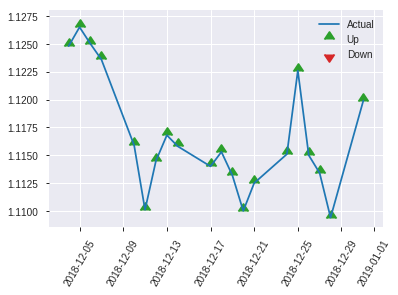


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.25939706876057655
RMSE: 0.5093103854827393
LogLoss: 0.7229702450011604
Mean Per-Class Error: 0.41739980449657865
AUC: 0.5946358748778103
pr_auc: 0.5371724515381197
Gini: 0.18927174975562067
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.14505437341313843: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      16   116  0.8788   (116.0/132.0)
1      1    123  0.0081   (1.0/124.0)
Total  17   239  0.457    (117.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.145054     0.677686  237
max f2                       0.145054     0.836735  237
max f0point5                 0.282031     0.574468  202
max accuracy                 0.537525     0.585938  98
max precision                0.796046     0.625     15
max recall                   0.103617     1         246
max specificity              0.927685     0.992424  0
max absolute_mcc             0.145054     0.227101  237
max min_per_class_accuracy   0.478145     0.572581  125
max mean_per_class_accuracy  0.537525     0.5826    98

Gains/Lift Table: Avg response rate: 48.44 %, avg score: 46.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117188                   0.880229           0         0                  0                0.897512  0                           0.897512            0               0                          -100       -100
    2        0.0234375                   0.852693           2.06452   1.03226            1                0.861636  0.5                         0.879574            0.0241935       0.0241935                  106.452    3.22581
    3        0.03125                     0.836897           0         0.774194           0                0.846379  0.375                       0.871275            0               0.0241935                  -100       -22.5806
    4        0.0429688                   0.82607            1.37634   0.938416           0.666667         0.829273  0.454545                    0.85982             0.016129        0.0403226                  37.6344    -6.15836
    5        0.0507812                   0.817171           2.06452   1.11166            1                0.824385  0.538462                    0.854369            0.016129        0.0564516                  106.452    11.1663
    6        0.101562                    0.749428           1.11166   1.11166            0.538462         0.777976  0.538462                    0.816172            0.0564516       0.112903                   11.1663    11.1663
    7        0.152344                    0.694684           1.27047   1.1646             0.615385         0.721384  0.564103                    0.784576            0.0645161       0.177419                   27.0471    16.4599
    8        0.203125                    0.63892            1.11166   1.15136            0.538462         0.663981  0.557692                    0.754427            0.0564516       0.233871                   11.1663    15.1365
    9        0.300781                    0.587709           1.23871   1.17972            0.6              0.61347   0.571429                    0.708662            0.120968        0.354839                   23.871     17.9724
    10       0.402344                    0.534767           1.19107   1.18259            0.576923         0.563464  0.572816                    0.67201             0.120968        0.475806                   19.1067    18.2587
    11       0.5                         0.474071           0.990968  1.14516            0.48             0.505309  0.554688                    0.639451            0.0967742       0.572581                   -0.903226  14.5161
    12       0.601562                    0.423393           1.03226   1.1261             0.5              0.449584  0.545455                    0.607396            0.104839        0.677419                   3.22581    12.61
    13       0.699219                    0.354498           0.990968  1.10723            0.48             0.390389  0.536313                    0.577088            0.0967742       0.774194                   -0.903226  10.7227
    14       0.800781                    0.279916           0.952854  1.08765            0.461538         0.31749   0.526829                    0.544163            0.0967742       0.870968                   -4.71464   8.76475
    15       0.898438                    0.16868            0.660645  1.04123            0.32             0.227088  0.504348                    0.509698            0.0645161       0.935484                   -33.9355   4.12342
    16       1                           0.00668681         0.635236  1                  0.307692         0.115288  0.484375                    0.4

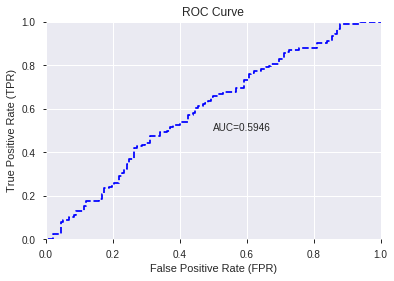

This function is available for GLM models only


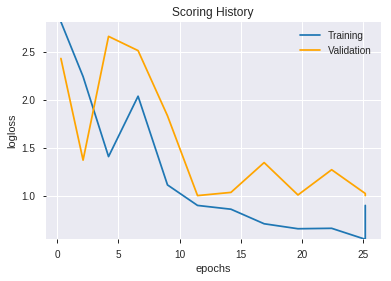

--2019-08-22 16:38:54--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.165.43
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.165.43|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_161500_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_161500_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_a064',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLSTICKSANDWICH',
 'CDLXSIDEGAP3METHODS',
 'CDLTHRUSTING',
 'CDLBREAKAWAY',
 'CDLSEPARATINGLINES',
 'CDLMORNINGSTAR',
 'CDLABANDONEDBABY',
 'CDLHIKKAKEMOD',
 'CDLADVANCEBLOCK',
 'CDL3INSIDE',
 'CDLHARAMICROSS',
 'CDLMORNINGDOJISTAR',
 'CDLONNECK',
 'CDLEVENINGSTAR',
 'CDLCOUNTERATTACK',
 'BOP',
 'CDLEVENINGDOJISTAR',
 'DIV',
 'CDL3OUTSIDE',
 'SUB',
 'CDLMATCHINGLOW',
 'CDLHAMMER',
 'CDLINVERTEDHAMMER',
 'CDLDRAGONFLYDOJI',
 'CDLHANGINGMAN',
 'STOCHF_fastk',
 'CDLRICKSHAWMAN',
 'CDLMARUBOZU',
 'CDLLONGLEGGEDDOJI',
 'CDLTAKURI',
 'CDLENGULFING',
 'CDLGRAVESTONEDOJI',
 'CDLSHOOTINGSTAR',
 'SAREXT',
 'MINUS_DI_8',
 'CDLDOJI',
 'STOCHRSI_fastk',
 'CORREL_14',
 'CDLGAPSIDESIDEWHITE',
 'STOCH_slowd',
 'HT_PHASOR_inphase',
 'CORREL_12',
 'TRANGE',
 'HT_PHASOR_quadrature',
 'aroondown_12',
 'DX_12',
 'MINUS_DI_12',
 'CORREL_8',
 'CORREL_20',
 'ULTOSC',
 'MINUS_DM_8',
 'DX_8',
 'ADXR_8',
 'CDLHIKKAKE',
 'ADX_8',
 'WILLR_8',
 'PLUS_DM_8',
 'STOCH_slowk',
 'aroondown_8',
 'BETA_20',
 'HT_TRENDM

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_163903_model_1  0.543316  0.693665              0.477517  0.500259  0.250259

variable  relative_importance  scaled_importance    percentage
0                         BOP         2.272299e-02           1.000000  2.456375e-02
1            CDLDRAGONFLYDOJI         1.661112e-02           0.731027  1.795677e-02
2                   CDLTAKURI         1.599314e-02           0.703831  1.728873e-02
3           CDLGRAVESTONEDOJI         1.420657e-02           0.625207  1.535743e-02
4                         SUB         1.206648e-02           0.531025  1.304397e-02
..                        ...                  ...                ...           ...
963   BBANDS_lowerband_12_1_4         1.364701e-06           0.000060  1.475254e-06
964   BBANDS_lowerband_14_1_3         1.130513e-06           0.000050  1.222095e-06
965  BBANDS_middleband_30_1_4         4.088888e-07           0.000018  4.420125e-07
966  BBANDS_middleband_14_0_2         3.782153e-07           0.000017  4.088541e-07
967  BBANDS_middleband_30_1_5         1.781465e-07           0.000008  1.925780e-07

[968 rows x 4 columns]

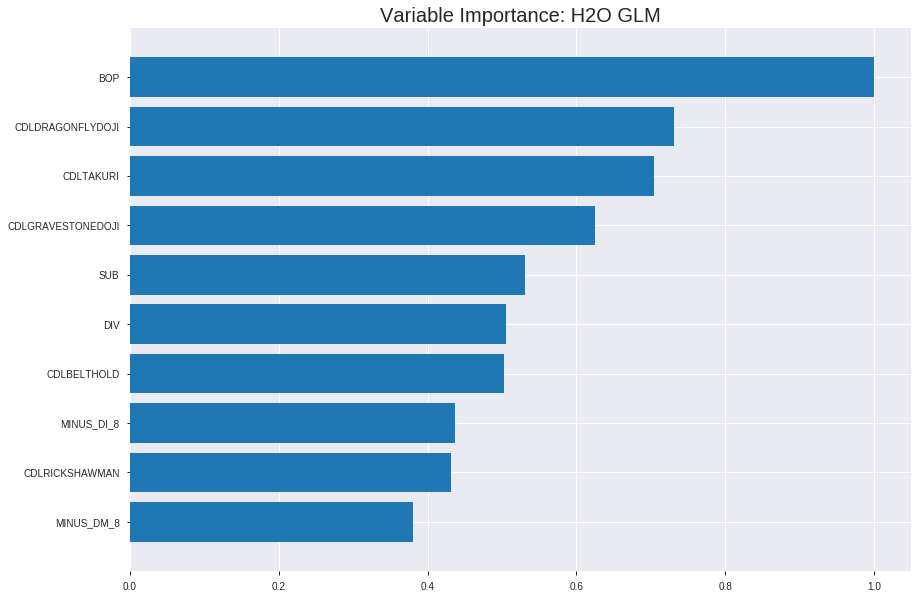

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_163903_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24148593871325585
RMSE: 0.4914121882017741
LogLoss: 0.6760170446473003
Null degrees of freedom: 1787
Residual degrees of freedom: 819
Null deviance: 2478.190938357651
Residual deviance: 2417.436951658746
AIC: 4355.436951658746
AUC: 0.6482301244914025
pr_auc: 0.6396556899157232
Gini: 0.296460248982805
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46817800493809125: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      169  710   0.8077   (710.0/879.0)
1      63   846   0.0693   (63.0/909.0)
Total  232  1556  0.4323   (773.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.468178     0.68641   306
max f2                       0.412148     0.840266  385
max f0point5                 0.506413     0.622791  203
max accuracy                 0.506971     0.616331  201
max precision                0.61898      1         0
max recall                   0.412148     1         385
max specificity              0.61898      1         0
max absolute_mcc             0.506413     0.232129  203
max min_per_class_accuracy   0.510212     0.610561  192
max mean_per_class_accuracy  0.506971     0.615716  201

Gains/Lift Table: Avg response rate: 50.84 %, avg score: 50.84 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.587101           1.74844   1.74844            0.888889         0.598826  0.888889                    0.598826            0.0176018       0.0176018                  74.8442   74.8442
    2        0.0201342                   0.578041           1.31133   1.52989            0.666667         0.582615  0.777778                    0.590721            0.0132013       0.0308031                  31.1331   52.9886
    3        0.0302013                   0.573645           1.52989   1.52989            0.777778         0.575722  0.777778                    0.585721            0.0154015       0.0462046                  52.9886   52.9886
    4        0.0402685                   0.570054           1.63916   1.55721            0.833333         0.571856  0.791667                    0.582255            0.0165017       0.0627063                  63.9164   55.7206
    5        0.0503356                   0.564842           1.20205   1.48618            0.611111         0.567004  0.755556                    0.579205            0.0121012       0.0748075                  20.2054   48.6175
    6        0.100112                    0.554468           1.34817   1.41756            0.685393         0.559049  0.72067                     0.569183            0.0671067       0.141914                   34.8166   41.7556
    7        0.150447                    0.547028           1.33319   1.38933            0.677778         0.550678  0.70632                     0.562992            0.0671067       0.209021                   33.3187   38.9329
    8        0.200224                    0.539505           1.21556   1.34613            0.617978         0.543118  0.684358                    0.558051            0.0605061       0.269527                   21.556    34.6129
    9        0.300336                    0.528542           1.10987   1.26738            0.564246         0.533921  0.64432                     0.550008            0.111111        0.380638                   10.987    26.7376
    10       0.399888                    0.519415           1.18241   1.24622            0.601124         0.523922  0.633566                    0.543514            0.117712        0.49835                    18.2408   24.6223
    11       0.5                         0.510169           1.09888   1.21672            0.558659         0.515113  0.618568                    0.537827            0.110011        0.608361                   9.88808   21.6722
    12       0.600112                    0.500878           0.978004  1.1769             0.497207         0.505657  0.598322                    0.53246             0.0979098       0.706271                   -2.19961  17.6898
    13       0.699664                    0.490146           0.80669   1.12422            0.410112         0.495648  0.571543                    0.527223            0.080308        0.786579                   -19.331   12.4223
    14       0.799776                    0.478429           0.824161  1.08666            0.418994         0.484611  0.552448                    0.521889            0.0825083       0.869087                   -17.5839  8.66625
    15       0.899888                    0.460873           0.780205  1.05257            0.396648         0.470646  0.535115                    0.516188            0.0781078       0.947195                   -21.9795  5.25694
    16       1                           0.316391           0.527463  1                  0.268156         0.438289  0.508389                    0.508389         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24969502184299586
RMSE: 0.49969492877454325
LogLoss: 0.6924841879875457
Null degrees of freedom: 510
Residual degrees of freedom: -458
Null deviance: 709.8491425809777
Residual deviance: 707.7188401232718
AIC: 2645.7188401232715
AUC: 0.5377195685670262
pr_auc: 0.4797890810410131
Gini: 0.07543913713405237
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4680929968588513: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      44   231  0.84     (231.0/275.0)
1      14   222  0.0593   (14.0/236.0)
Total  58   453  0.4795   (245.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.468093     0.644412  348
max f2                       0.416339     0.814355  393
max f0point5                 0.475585     0.543587  336
max accuracy                 0.537906     0.549902  114
max precision                0.572307     0.566667  27
max recall                   0.416339     1         393
max specificity              0.633157     0.996364  0
max absolute_mcc             0.468093     0.158232  348
max min_per_class_accuracy   0.517959     0.509091  199
max mean_per_class_accuracy  0.475585     0.554291  336

Gains/Lift Table: Avg response rate: 46.18 %, avg score: 51.51 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.601904           1.08263   1.08263            0.5              0.613274  0.5                         0.613274            0.0127119       0.0127119                  8.26271   8.26271
    2        0.0215264                   0.591578           0.433051  0.787365           0.2              0.593734  0.363636                    0.604392            0.00423729      0.0169492                  -56.6949  -21.2635
    3        0.0313112                   0.579966           0.866102  0.81197            0.4              0.585942  0.375                       0.598626            0.00847458      0.0254237                  -13.3898  -18.803
    4        0.0410959                   0.57778            1.7322    1.03107            0.8              0.578949  0.47619                     0.593941            0.0169492       0.0423729                  73.2203   3.10734
    5        0.0508806                   0.573415           1.29915   1.08263            0.6              0.575286  0.5                         0.590354            0.0127119       0.0550847                  29.9153   8.26271
    6        0.101761                    0.558277           0.83279   0.957709           0.384615         0.566748  0.442308                    0.578551            0.0423729       0.0974576                  -16.721   -4.22914
    7        0.150685                    0.552616           1.29915   1.06857            0.6              0.555247  0.493506                    0.570984            0.0635593       0.161017                   29.9153   6.8567
    8        0.201566                    0.544926           1.24919   1.11416            0.576923         0.548734  0.514563                    0.565368            0.0635593       0.224576                   24.9185   11.416
    9        0.30137                     0.534769           0.976487  1.06857            0.45098          0.539822  0.493506                    0.556908            0.0974576       0.322034                   -2.35128  6.8567
    10       0.401174                    0.526007           1.01894   1.05622            0.470588         0.53033   0.487805                    0.550296            0.101695        0.423729                   1.89432   5.62216
    11       0.500978                    0.517959           0.891575  1.02342            0.411765         0.522357  0.472656                    0.54473             0.0889831       0.512712                   -10.8425  2.34209
    12       0.600783                    0.509217           1.01894   1.02268            0.470588         0.513726  0.472313                    0.539579            0.101695        0.614407                   1.89432   2.26771
    13       0.700587                    0.49791            1.10386   1.03424            0.509804         0.503796  0.477654                    0.534482            0.110169        0.724576                   10.3855   3.42415
    14       0.800391                    0.483056           1.23122   1.0588             0.568627         0.490422  0.488998                    0.528988            0.122881        0.847458                   23.1223   5.8804
    15       0.900196                    0.465736           0.976487  1.04968            0.45098          0.475686  0.484783                    0.523078            0.0974576       0.944915                   -2.35128  4.96776
    16       1                           0.2313             0.551928  1                  0.254902         0.443331  0.46184                     0.515119           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-22 16:39:06  0.000 sec   2            8.3       967           1.36892           1.38668
    2019-08-22 16:39:08  1.993 sec   4            6.1       967           1.36434           1.38598
    2019-08-22 16:39:10  3.993 sec   6            4.4       969           1.35875           1.3854
    2019-08-22 16:39:13  6.046 sec   8            3.2       969           1.35203           1.38497
    2019-08-22 16:39:15  8.118 sec   10           2.3       969           1.34421           1.3851
    2019-08-22 16:39:17  10.131 sec  12           1.7       969           1.33538           1.38594
    2019-08-22 16:39:19  12.158 sec  14           1.2       969           1.32572           1.38801
    2019-08-22 16:39:21  14.266 sec  16           0.9       969           1.3155            1.39152
    2019-08-22 16:39:23  16.275 sec  18           0.66      969           1.30496           1.39653

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.55859375)

('F1', 0.6612903225806452)

('auc', 0.5433162267839687)

('logloss', 0.6936647368077817)

('mean_per_class_error', 0.4533235581622679)

('rmse', 0.5002587552792622)

('mse', 0.2502588222335568)

glm prediction progress: |████████████████████████████████████████████████| 100%


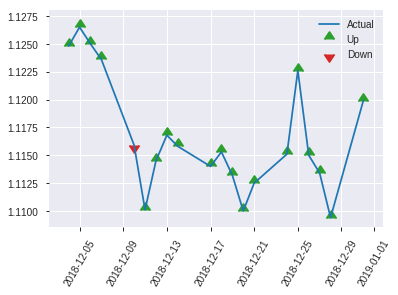


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2502588222335568
RMSE: 0.5002587552792622
LogLoss: 0.6936647368077817
Null degrees of freedom: 255
Residual degrees of freedom: -713
Null deviance: 355.23191699062966
Residual deviance: 355.1563452455842
AIC: 2293.1563452455844
AUC: 0.5433162267839687
pr_auc: 0.5365116744239247
Gini: 0.08663245356793747
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47930905299458026: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    125  0.947    (125.0/132.0)
1      1    123  0.0081   (1.0/124.0)
Total  8    248  0.4922   (126.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.479309     0.66129   247
max f2                       0.457546     0.82777   252
max f0point5                 0.5172       0.554299  189
max accuracy                 0.567515     0.558594  16
max precision                0.567515     0.823529  16
max recall                   0.457546     1         252
max specificity              0.605507     0.992424  0
max absolute_mcc             0.567515     0.180994  16
max min_per_class_accuracy   0.534659     0.522727  127
max mean_per_class_accuracy  0.5172       0.546676  189

Gains/Lift Table: Avg response rate: 48.44 %, avg score: 53.26 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117188                   0.590623           0.688172  0.688172           0.333333         0.599564  0.333333                    0.599564            0.00806452      0.00806452                 -31.1828   -31.1828
    2        0.0234375                   0.581512           2.06452   1.37634            1                0.583987  0.666667                    0.591776            0.0241935       0.0322581                  106.452    37.6344
    3        0.03125                     0.572019           2.06452   1.54839            1                0.577088  0.75                        0.588104            0.016129        0.0483871                  106.452    54.8387
    4        0.0429688                   0.569619           2.06452   1.68915            1                0.570595  0.818182                    0.583329            0.0241935       0.0725806                  106.452    68.915
    5        0.0507812                   0.568482           1.03226   1.58809            0.5              0.569244  0.769231                    0.581162            0.00806452      0.0806452                  3.22581    58.8089
    6        0.101562                    0.563827           1.11166   1.34988            0.538462         0.566281  0.653846                    0.573721            0.0564516       0.137097                   11.1663    34.9876
    7        0.152344                    0.560995           0.794045  1.1646             0.384615         0.562203  0.564103                    0.569882            0.0403226       0.177419                   -20.5955   16.4599
    8        0.203125                    0.557292           0.952854  1.11166            0.461538         0.55905   0.538462                    0.567174            0.0483871       0.225806                   -4.71464   11.1663
    9        0.300781                    0.547571           0.908387  1.04566            0.44             0.551499  0.506494                    0.562085            0.0887097       0.314516                   -9.16129   4.5664
    10       0.402344                    0.539246           1.11166   1.06232            0.538462         0.543331  0.514563                    0.557351            0.112903        0.427419                   11.1663    6.23238
    11       0.5                         0.5346             0.990968  1.04839            0.48             0.537332  0.507812                    0.553441            0.0967742       0.524194                   -0.903226  4.83871
    12       0.601562                    0.528237           1.03226   1.04566            0.5              0.531641  0.506494                    0.54976             0.104839        0.629032                   3.22581    4.5664
    13       0.699219                    0.520339           0.990968  1.03802            0.48             0.524872  0.502793                    0.546284            0.0967742       0.725806                   -0.903226  3.80249
    14       0.800781                    0.5097             1.03226   1.03729            0.5              0.515277  0.502439                    0.542352            0.104839        0.830645                   3.22581    3.72935
    15       0.898438                    0.499278           0.825806  1.01431            0.4              0.505459  0.491304                    0.538342            0.0806452       0.91129                    -17.4194   1.43058
    16       1                           0.427055           0.873449  1                  0.423077         0.481344  0.484375                    0.

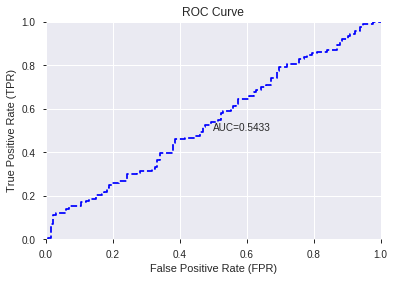

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


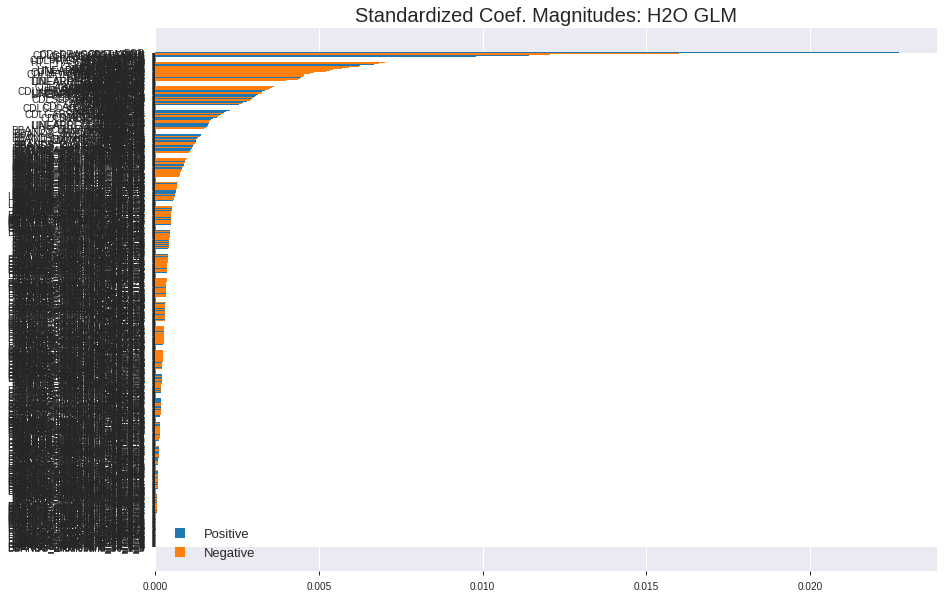

'log_likelihood'
--2019-08-22 16:39:52--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.108.43
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.108.43|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_163903_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_163903_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_a064',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'CDLGRAVESTONEDOJI',
 'SUB',
 'DIV',
 'CDLBELTHOLD',
 'MINUS_DI_8',
 'CDLRICKSHAWMAN',
 'MINUS_DM_8',
 'TRANGE',
 'MINUS_DI_12',
 'CORREL_14',
 'CDLINVERTEDHAMMER',
 'BETA_8',
 'MINUS_DI_14',
 'BETA_20',
 'CCI_8',
 'HT_PHASOR_quadrature',
 'BETA_14',
 'CDLHAMMER',
 'BETA_12',
 'aroondown_20',
 'CDLMARUBOZU',
 'MINUS_DI_20',
 'CCI_14',
 'CCI_12',
 'MINUS_DM_12',
 'STOCH_slowd',
 'MINUS_DI_24',
 'AROONOSC_20',
 'LINEARREG_SLOPE_8',
 'LINEARREG_ANGLE_8',
 'MINUS_DI_30',
 'BETA_30',
 'MINUS_DM_14',
 'CCI_20',
 'CDLEVENINGDOJISTAR',
 'CDLENGULFING',
 'BETA_24',
 'CDLMORNINGDOJISTAR',
 'CORREL_20',
 'CDLLONGLINE',
 'ROC_8',
 'CDLTHRUSTING',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'STOCHRSI_fastk',
 'CDL3OUTSIDE',
 'MOM_8',
 'CORREL_24',
 'LINEARREG_SLOPE_12',
 'LINEARREG_ANGLE_12',
 'STOCHF_fastd',
 'STOCH_slowk',
 'CORREL_12',
 'ULTOSC',
 'aroondown_24',
 'AROONOSC_14',
 'STOCHF_fastk',
 'PLUS_DM_8',
 'aroondown_14',
 'VAR_30',
 'PLUS_DI_8',
 'STDDEV

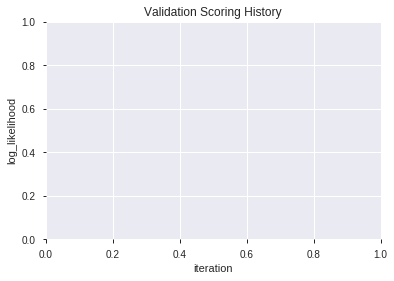

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_164003_model_5  0.609848  0.717237              0.428275  0.509672  0.259765
1  XGBoost_grid_1_AutoML_20190822_164003_model_4  0.608504  0.681599              0.425464  0.494337  0.244369
2  XGBoost_grid_1_AutoML_20190822_164003_model_6  0.608321  0.680307              0.462121  0.493517  0.243559
3               XGBoost_2_AutoML_20190822_164003  0.595430  0.694270              0.447458  0.499780  0.249781
4               XGBoost_1_AutoML_20190822_164003  0.588771  0.698810              0.439638  0.501968  0.251972
5               XGBoost_3_AutoML_20190822_164003  0.585716  0.691470              0.455279  0.499014  0.249015
6  XGBoost_grid_1_AutoML_20190822_164003_model_3  0.583272  0.699419              0.409213  0.502216  0.252221
7  XGBoost_grid_1_AutoML_20190822_164003_model_2  0.576185  0.692111              0.470430  0.499361  0.249361
8  XGBoost_grid_1_AutoML_20190822_164003_model_7  0.575880  0.705029              0.447214  0.504402  0.254422
9  XGBoost_grid_1_AutoML_20190822_164003_model_1  0.566593  0.692737              0.451246  0.499704  0.249704

variable  relative_importance  scaled_importance  percentage
0                        BOP           674.906860           1.000000    0.027662
1                     SAREXT           415.216675           0.615221    0.017018
2                        DIV           381.909698           0.565870    0.015653
3                       fama           340.278564           0.504186    0.013947
4                     ULTOSC           337.553497           0.500148    0.013835
..                       ...                  ...                ...         ...
619                  MA_20_0             0.570304           0.000845    0.000023
620  BBANDS_lowerband_30_5_5             0.421599           0.000625    0.000017
621                   EMA_30             0.294878           0.000437    0.000012
622                   SMA_14             0.277715           0.000411    0.000011
623  BBANDS_lowerband_14_3_4             0.034987           0.000052    0.000001

[624 rows x 4 columns]

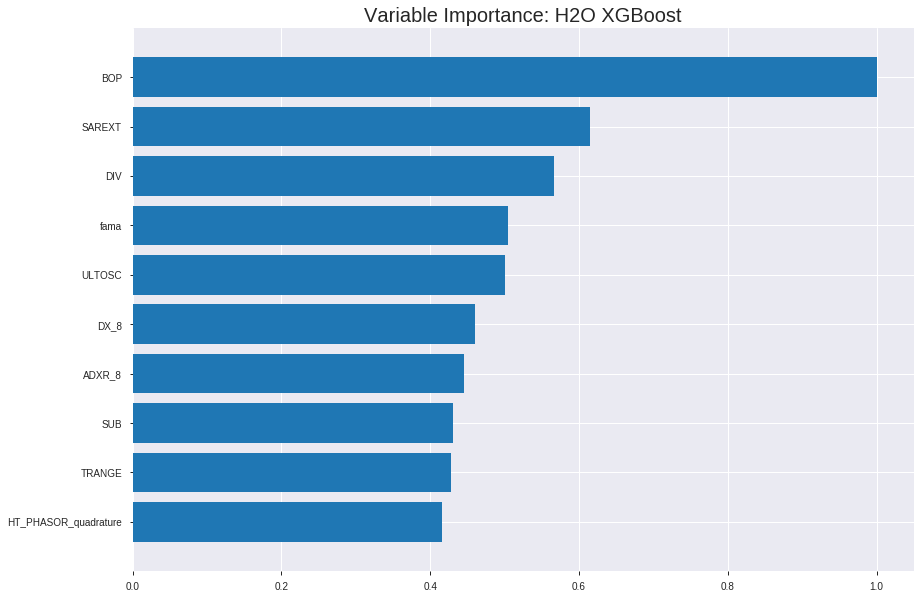

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_164003_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.03590449765220936
RMSE: 0.18948482169347855
LogLoss: 0.1980723132343637
Mean Per-Class Error: 0.0
AUC: 1.0
pr_auc: 0.9988998899889989
Gini: 1.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5387814044952393: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      879  0    0        (0.0/879.0)
1      0    909  0        (0.0/909.0)
Total  879  909  0        (0.0/1788.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value    idx
---------------------------  -----------  -------  -----
max f1                       0.538781     1        197
max f2                       0.538781     1        197
max f0point5                 0.538781     1        197
max accuracy                 0.538781     1        197
max precision                0.948518     1        0
max recall                   0.538781     1        197
max specificity              0.948518     1        0
max absolute_mcc             0.538781     1        197
max min_per_class_accuracy   0.538781     1        197
max mean_per_class_accuracy  0.538781     1        197

Gains/Lift Table: Avg response rate: 50.84 %, avg score: 50.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100671                   0.928209           1.967     1.967              1                0.935086   1                           0.935086            0.019802        0.019802                   96.6997   96.6997
    2        0.0201342                   0.918804           1.967     1.967              1                0.923711   1                           0.929399            0.019802        0.039604                   96.6997   96.6997
    3        0.0302013                   0.910011           1.967     1.967              1                0.913171   1                           0.923989            0.019802        0.0594059                  96.6997   96.6997
    4        0.0402685                   0.906469           1.967     1.967              1                0.908498   1                           0.920117            0.019802        0.0792079                  96.6997   96.6997
    5        0.0503356                   0.901075           1.967     1.967              1                0.903754   1                           0.916844            0.019802        0.0990099                  96.6997   96.6997
    6        0.100112                    0.884778           1.967     1.967              1                0.891862   1                           0.904423            0.0979098       0.19692                    96.6997   96.6997
    7        0.150447                    0.868549           1.967     1.967              1                0.876594   1                           0.895112            0.0990099       0.29593                    96.6997   96.6997
    8        0.200224                    0.852124           1.967     1.967              1                0.861049   1                           0.886644            0.0979098       0.393839                   96.6997   96.6997
    9        0.300336                    0.820985           1.967     1.967              1                0.83754    1                           0.870276            0.19692         0.590759                   96.6997   96.6997
    10       0.399888                    0.777757           1.967     1.967              1                0.801672   1                           0.853197            0.19582         0.786579                   96.6997   96.6997
    11       0.5                         0.657549           1.967     1.967              1                0.736149   1                           0.829761            0.19692         0.983498                   96.6997   96.6997
    12       0.600112                    0.23961            0.164832  1.66636            0.0837989        0.321694   0.847158                    0.745004            0.0165017       1                          -83.5168  66.6356
    13       0.699664                    0.189329           0         1.42926            0                0.212346   0.726619                    0.669214            0               1                          -100      42.9257
    14       0.799776                    0.152603           0         1.25035            0                0.169953   0.635664                    0.606719            0               1                          -100      25.035
    15       0.899888                    0.11751            0         1.11125            0                0.135391   0.564947                    0.554284            0               1                          -100      11.1249
    16       1                           0.0503428          0         1                  0                0.0965631  0.508389                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2698620095017847
RMSE: 0.519482443882163
LogLoss: 0.7406511381181824
Mean Per-Class Error: 0.4425038520801232
AUC: 0.5407087827426811
pr_auc: 0.4839704705969411
Gini: 0.08141756548536216
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.14969341456890106: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    273  0.9927   (273.0/275.0)
1      0    236  0        (0.0/236.0)
Total  2    509  0.5342   (273.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.149693     0.633557  397
max f2                       0.149693     0.812113  397
max f0point5                 0.394009     0.535326  302
max accuracy                 0.518511     0.551859  223
max precision                0.883025     1         0
max recall                   0.149693     1         397
max specificity              0.883025     1         0
max absolute_mcc             0.518511     0.11578   223
max min_per_class_accuracy   0.551433     0.521186  196
max mean_per_class_accuracy  0.518511     0.557496  223

Gains/Lift Table: Avg response rate: 46.18 %, avg score: 53.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.836476           1.08263   1.08263            0.5              0.8515    0.5                         0.8515              0.0127119       0.0127119                  8.26271   8.26271
    2        0.0215264                   0.81808            1.7322    1.37789            0.8              0.825384  0.636364                    0.839629            0.0169492       0.029661                   73.2203   37.7889
    3        0.0313112                   0.804011           0.866102  1.21796            0.4              0.807316  0.5625                      0.829531            0.00847458      0.0381356                  -13.3898  21.7956
    4        0.0410959                   0.796459           0.866102  1.13418            0.4              0.798689  0.52381                     0.822188            0.00847458      0.0466102                  -13.3898  13.4181
    5        0.0508806                   0.792528           0         0.916069           0                0.794779  0.423077                    0.816917            0               0.0466102                  -100      -8.39309
    6        0.101761                    0.752644           0.83279   0.87443            0.384615         0.772828  0.403846                    0.794873            0.0423729       0.0889831                  -16.721   -12.557
    7        0.150685                    0.722108           0.952712  0.899846           0.44             0.736275  0.415584                    0.775847            0.0466102       0.135593                   -4.72881  -10.0154
    8        0.201566                    0.699867           1.33246   1.00905            0.615385         0.710665  0.466019                    0.759394            0.0677966       0.20339                    33.2464   0.905052
    9        0.30137                     0.649467           1.10386   1.04045            0.509804         0.676056  0.480519                    0.731795            0.110169        0.313559                   10.3855   4.04468
    10       0.401174                    0.599153           1.14631   1.06678            0.529412         0.620624  0.492683                    0.704138            0.114407        0.427966                   14.6311   6.67838
    11       0.500978                    0.548792           0.976487  1.0488             0.45098          0.572893  0.484375                    0.677991            0.0974576       0.525424                   -2.35128  4.8795
    12       0.600783                    0.503174           1.27368   1.08615            0.588235         0.528649  0.501629                    0.653182            0.127119        0.652542                   27.3679   8.61536
    13       0.700587                    0.445872           0.934031  1.06448            0.431373         0.473795  0.49162                     0.627627            0.0932203       0.745763                   -6.59688  6.44825
    14       0.800391                    0.382618           0.976487  1.05351            0.45098          0.413571  0.486553                    0.600935            0.0974576       0.84322                    -2.35128  5.351
    15       0.900196                    0.288816           0.806663  1.02614            0.372549         0.328539  0.473913                    0.570735            0.0805085       0.923729                   -19.3337  2.61422
    16       1                           0.126306           0.764207  1                  0.352941         0.232083  0.46184                     0.536936         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 16:40:38  18.191 sec  0                  0.5              0.693147            0.5             0                  1                0.491611                         0.5                0.693147              0.5               0                    1                  0.53816
    2019-08-22 16:40:40  19.885 sec  5                  0.444477         0.587348            0.975187        0.969208           1.967            0.0743848                        0.502044           0.69724               0.505478          0.482008             1.4435             0.522505
    2019-08-22 16:40:41  20.689 sec  10                 0.396648         0.503394            0.9956          0.994831           1.967            0.0341163                        0.501882           0.69701               0.531595          0.485169             1.4435             0.510763
    2019-08-22 16:40:42  21.489 sec  15                 0.356199         0.436682            0.999202        0.995943           1.967            0.0123043                        0.505009           0.703637              0.523482          0.472252             1.08263            0.51272
    2019-08-22 16:40:43  22.358 sec  20                 0.319967         0.380165            0.999708        0.998624           1.967            0.00727069                       0.505432           0.704949              0.53567           0.48075              1.4435             0.479452
    2019-08-22 16:40:43  23.208 sec  25                 0.289661         0.33468             0.999928        0.998831           1.967            0.0033557                        0.507684           0.710155              0.541133          0.489041             1.80438            0.46771
    2019-08-22 16:40:44  24.072 sec  30                 0.262973         0.296317            0.999981        0.997781           1.967            0.00111857                       0.511003           0.718037              0.536726          0.479068             1.08263            0.51272
    2019-08-22 16:40:45  24.912 sec  35                 0.240245         0.264763            1               0.9989             1.967            0                                0.513269           0.723637              0.537111          0.483865             1.80438            0.520548
    2019-08-22 16:40:46  25.761 sec  40                 0.220079         0.237553            1               0.9989             1.967            0                                0.516454           0.731854              0.5352            0.476963             1.4435             0.530333
    2019-08-22 16:40:47  26.595 sec  45                 0.202825         0.214897            1               0.9989             1.967            0                                0.51891            0.738163              0.53604           0.481447             1.4435             0.500978
    2019-08-22 16:40:48  27.412 sec  50                 0.189485         0.198072            1               0.9989             1.967            0                                0.519482           0.740651              0.540709          0.48397              1.08263            0.534247

Variable Importances: 


variable                 relative_importance    scaled_importance       percentage
-----------------------  ---------------------  ----------------------  ----------------------
BOP                      674.9068603515625      1.0                     0.02766225042478918
SAREXT                   415.2166748046875      0.6152207055480203      0.017018389223384823
DIV                      381.9096984863281      0.5658702273190547      0.01565324393603207
fama                     340.278564453125       0.5041859617131053      0.013946918333571087
ULTOSC                   337.5534973144531      0.5001482680715673      0.013835226640920285
---                      ---                    ---                     ---
MA_20_0                  0.5703039765357971     0.0008450113786644913   2.3374916368413514e-05
BBANDS_lowerband_30_5_5  0.42159897089004517    0.0006246772638678352   1.7279978907784163e-05
EMA_30                   0.2948782742023468     0.00043691699036626055  1.20861072023567e-05
SMA_14                   0.2777146100997925     0.0004114858307339319   1.1382624096014436e-05
BBANDS_lowerband_14_3_4  0.03498729690909386    5.1840185608527956e-05  1.4340161963706523e-06


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6015625)

('F1', 0.6852367688022284)

('auc', 0.6098484848484849)

('logloss', 0.7172373938297876)

('mean_per_class_error', 0.40249266862170086)

('rmse', 0.5096715556942039)

('mse', 0.25976509468375)

xgboost prediction progress: |████████████████████████████████████████████| 100%


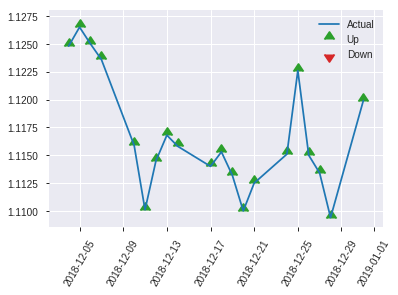


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25976509468375
RMSE: 0.5096715556942039
LogLoss: 0.7172373938297876
Mean Per-Class Error: 0.40249266862170086
AUC: 0.6098484848484849
pr_auc: 0.5777642839541177
Gini: 0.21969696969696972
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44008708000183105: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      20   112  0.8485   (112.0/132.0)
1      1    123  0.0081   (1.0/124.0)
Total  21   235  0.4414   (113.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.440087     0.685237  234
max f2                       0.440087     0.841313  234
max f0point5                 0.684903     0.58      93
max accuracy                 0.684903     0.601562  93
max precision                0.898251     1         0
max recall                   0.309739     1         252
max specificity              0.898251     1         0
max absolute_mcc             0.440087     0.26125   234
max min_per_class_accuracy   0.648199     0.564516  124
max mean_per_class_accuracy  0.684903     0.597507  93

Gains/Lift Table: Avg response rate: 48.44 %, avg score: 62.70 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.862339           0.688172  0.688172           0.333333         0.877939  0.333333                    0.877939            0.00806452      0.00806452                 -31.1828  -31.1828
    2        0.0234375                   0.844804           1.37634   1.03226            0.666667         0.851425  0.5                         0.864682            0.016129        0.0241935                  37.6344   3.22581
    3        0.03125                     0.821403           2.06452   1.29032            1                0.831586  0.625                       0.856408            0.016129        0.0403226                  106.452   29.0323
    4        0.0429688                   0.811462           2.06452   1.50147            1                0.81616   0.727273                    0.845431            0.0241935       0.0645161                  106.452   50.1466
    5        0.0507812                   0.804773           1.03226   1.42928            0.5              0.810079  0.692308                    0.839992            0.00806452      0.0725806                  3.22581   42.928
    6        0.101562                    0.778169           1.27047   1.34988            0.615385         0.79158   0.653846                    0.815786            0.0645161       0.137097                   27.0471   34.9876
    7        0.152344                    0.759334           1.42928   1.37634            0.692308         0.769116  0.666667                    0.800229            0.0725806       0.209677                   42.928    37.6344
    8        0.203125                    0.733824           1.42928   1.38958            0.692308         0.744691  0.673077                    0.786345            0.0725806       0.282258                   42.928    38.9578
    9        0.300781                    0.699188           0.908387  1.23335            0.44             0.712285  0.597403                    0.762299            0.0887097       0.370968                   -9.16129  23.3347
    10       0.402344                    0.674107           1.11166   1.20263            0.538462         0.687445  0.582524                    0.743404            0.112903        0.483871                   11.1663   20.2631
    11       0.5                         0.641016           0.825806  1.12903            0.4              0.658702  0.546875                    0.726861            0.0806452       0.564516                   -17.4194  12.9032
    12       0.601562                    0.614717           0.952854  1.09929            0.461538         0.62668   0.532468                    0.709947            0.0967742       0.66129                    -4.71464  9.92878
    13       0.699219                    0.574602           0.825806  1.06109            0.4              0.595833  0.513966                    0.694009            0.0806452       0.741935                   -17.4194  6.10921
    14       0.800781                    0.521436           1.03226   1.05744            0.5              0.549332  0.512195                    0.67566             0.104839        0.846774                   3.22581   5.74351
    15       0.898438                    0.448667           1.15613   1.06816            0.56             0.485928  0.517391                    0.655037            0.112903        0.959677                   15.6129   6.81627
    16       1                           0.192793           0.397022  1                  0.192308         0.379039  0.484375                    0.627006         

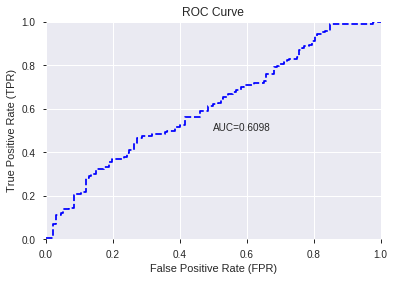

This function is available for GLM models only


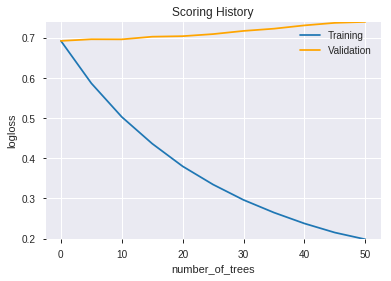

--2019-08-22 16:41:02--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.36.236
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.36.236|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_164003_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_164003_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_a064',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'SAREXT',
 'DIV',
 'fama',
 'ULTOSC',
 'DX_8',
 'ADXR_8',
 'SUB',
 'TRANGE',
 'HT_PHASOR_quadrature',
 'CCI_8',
 'STOCHF_fastk',
 'ADX_8',
 'BETA_12',
 'BETA_14',
 'HT_PHASOR_inphase',
 'WILLR_12',
 'WILLR_8',
 'HT_DCPERIOD',
 'STDDEV_8',
 'STOCH_slowd',
 'CMO_8',
 'CCI_12',
 'MACDEXT_hist',
 'BETA_8',
 'MINUS_DI_8',
 'PLUS_DI_8',
 'ADXR_12',
 'CORREL_12',
 'PLUS_DM_8',
 'ADXR_14',
 'DX_12',
 'STDDEV_30',
 'MOM_8',
 'BETA_24',
 'MACDFIX_hist_8',
 'DEMA_8',
 'MINUS_DM_8',
 'CORREL_8',
 'STOCH_slowk',
 'STDDEV_12',
 'CORREL_24',
 'STOCHRSI_fastd',
 'MOM_24',
 'MOM_12',
 'MACDEXT_signal',
 'LINEARREG_ANGLE_12',
 'CORREL_14',
 'DX_24',
 'DX_20',
 'PLUS_DM_12',
 'MOM_30',
 'DX_14',
 'ROC_8',
 'MACDFIX_8',
 'ADX_24',
 'aroonup_8',
 'MINUS_DI_30',
 'CORREL_20',
 'DX_30',
 'WILLR_24',
 'AROONOSC_30',
 'CDLDRAGONFLYDOJI',
 'BETA_30',
 'LINEARREG_ANGLE_8',
 'ADX_12',
 'aroondown_8',
 'MINUS_DI_24',
 'STDDEV_20',
 'CCI_30',
 'AROONOSC_20',
 'MOM_14',
 'ATR_8',
 'CCI_24',
 'BETA_20',
 'ST

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.613
GLM             0.609
XGBoost         0.617
dtype: float64

DeepLearning    GLM  XGBoost
All          0.613  0.570    0.613
DLF          0.578  0.609    0.617
Fwe          0.586  0.559    0.586
RFE          0.586  0.559    0.602
XGBF         0.586  0.609    0.617





F1


DeepLearning    0.678
GLM             0.661
XGBoost         0.685
dtype: float64

DeepLearning    GLM  XGBoost
All          0.660  0.661    0.668
DLF          0.659  0.653    0.669
Fwe          0.661  0.658    0.661
RFE          0.678  0.661    0.685
XGBF         0.654  0.653    0.669





auc


DeepLearning    0.595
GLM             0.594
XGBoost         0.626
dtype: float64

DeepLearning    GLM  XGBoost
All          0.592  0.563    0.625
DLF          0.581  0.594    0.626
Fwe          0.566  0.546    0.566
RFE          0.595  0.543    0.610
XGBF         0.582  0.594    0.626





logloss


DeepLearning    0.753
GLM             0.696
XGBoost         0.717
dtype: float64

DeepLearning    GLM  XGBoost
All          0.753  0.691    0.693
DLF          0.683  0.690    0.675
Fwe          0.688  0.696    0.691
RFE          0.723  0.694    0.717
XGBF         0.685  0.690    0.675





mean_per_class_error


DeepLearning    0.419
GLM             0.453
XGBoost         0.417
dtype: float64

DeepLearning    GLM  XGBoost
All          0.388  0.433    0.383
DLF          0.419  0.391    0.378
Fwe          0.419  0.447    0.417
RFE          0.417  0.453    0.402
XGBF         0.414  0.391    0.378





rmse


DeepLearning    0.521
GLM             0.501
XGBoost         0.510
dtype: float64

DeepLearning    GLM  XGBoost
All          0.521  0.499    0.499
DLF          0.495  0.498    0.491
Fwe          0.497  0.501    0.499
RFE          0.509  0.500    0.510
XGBF         0.496  0.498    0.491





mse


DeepLearning    0.271
GLM             0.251
XGBoost         0.260
dtype: float64

DeepLearning    GLM  XGBoost
All          0.271  0.249    0.249
DLF          0.245  0.248    0.241
Fwe          0.247  0.251    0.249
RFE          0.259  0.250    0.260
XGBF         0.246  0.248    0.241

{'F1':       DeepLearning    GLM  XGBoost
 All          0.660    NaN      NaN
 DLF          0.659    NaN      NaN
 DLF            NaN  0.653      NaN
 DLF            NaN    NaN    0.669
 All            NaN  0.661      NaN
 All            NaN    NaN    0.668
 XGBF         0.654    NaN      NaN
 XGBF           NaN  0.653      NaN
 XGBF           NaN    NaN    0.669
 Fwe          0.661    NaN      NaN
 Fwe            NaN  0.658      NaN
 Fwe            NaN    NaN    0.661
 RFE          0.678    NaN      NaN
 RFE            NaN  0.661      NaN
 RFE            NaN    NaN    0.685,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.613    NaN      NaN
 DLF          0.578    NaN      NaN
 DLF            NaN  0.609      NaN
 DLF            NaN    NaN    0.617
 All            NaN  0.570      NaN
 All            NaN    NaN    0.613
 XGBF         0.586    NaN      NaN
 XGBF           NaN  0.609      NaN
 XGBF           NaN    NaN    0.617
 Fwe          0.586    NaN      NaN
 Fwe     